In [26]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from inversion.Strategies.SeismDiffInversion1D import inverse
from inversion.optimizators.optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient, AxOptimizer
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from inversion.Strategies.SeismDiffInversion1D import func_to_optimize
from Visualization.Seismic import visualize_model1D, visualize_rays_model_1D, visualize_time_curves


In [3]:
import json


In [4]:
from Visualization.Seismic import visualize_seismogram
from scipy.optimize import approx_fprime


In [5]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None, ax=None, 
                err_func=None, err_func_params=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    
    if err_func is None:
        err_func = func_to_optimize
        err_func_params = [None, placeholders, forward_params, None, False]
    
    for val in val_x:
        err_func_params[0] = val
        errs.append(err_func(*err_func_params))
       
    show_flag = False
    if ax is None:
        fig, ax = plt.subplots()
        show_flag = True
        
    ax.plot(val_x, errs)
    if dot:
        ax.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        ax.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    if show_flag:
        plt.show()

def optimization_func_2D(forward_params, x, y, err_func, err_func_params):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            err_func_params[0] = [x[ind1, ind2], y[ind1, ind2]]
            Z[ind1, ind2] = err_func(*err_func_params)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None, fig=None, ax=None, err_func=None, 
               err_func_params=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    if err_func is None:
        err_func = func_to_optimize
        err_func_params = [None, placeholders, forward_params, None, False]
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y, err_func, err_func_params)
    
    if ax is None and fig is None:
        fig, ax = plt.subplots()
    
    im = ax.contourf(X, Y, Z, ncontous, cmap='seismic')
#     fig.colorbar(im, ax=ax)
    
    if points is not None:
        ax.plot(points[0], points[1], marker='o', color='green', markersize=5)

# Четырехслойная модель с газоосадками

In [6]:
h = [
    67.5,
    22.5,
    20
]

In [7]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

def get_layer2_rp():
    return {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": True,
                      "min": 20,
                      "max": 60
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": True,
                      "min": 20,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": True,
                      "min": 10,
                      "max": 50
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": True,
                      "min": 1,
                      "max": 20
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_2_rp = get_layer2_rp()

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [8]:
optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

decrease_boundaries = True

for key in layer_2_rp['components'].keys():
    if key in optimization_list:
        layer_2_rp['components'][key]["optimize"] = True
        
        if decrease_boundaries:
            layer_2_rp['components'][key]["min"] = layer_2_rp['components'][key]["value"] * 0.7
            layer_2_rp['components'][key]["max"] = layer_2_rp['components'][key]["value"] * 1.3
        
    else:
        layer_2_rp['components'][key]["optimize"] = False

In [9]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [10]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [11]:
# Многоканальная коса

In [52]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

In [53]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=False)

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


In [54]:
true_vals = model.get_optimization_option('val')

In [55]:
true_vals

OrderedDict([(1,
              {'Ksh': 21.5,
               'Gsh': 7,
               'rhosh': 2.43,
               'Vsh': 0.7,
               'phi': 0.74})])

In [56]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [57]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

In [58]:
# fig, axes = plt.subplots(figsize=(15, 9))

# max_depth=300
# dz = 20

# visualize_model1D(axes, model, observe, max_depth, dz, 'vp', only_boundaries=True)
# visualize_rays_model_1D(axes, test_seismic[OWT.PdPu_water]["rays"])
# axes.invert_yaxis()

# Inversion

In [59]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

## Create start indexes

In [60]:
def formula(v, h, x):
    return np.sqrt(x**2 + 4*h*h) / v

In [61]:
start_times = formula(1500, 60, np.array(x_rec))
start_indexes = (start_times / dt).astype(int)

In [62]:
# fig, ax = plt.subplots(figsize=(12,8))

# visualize_seismogram(fig, ax, test_seismic[OWT.PdPu_water]['seismogram'], wiggles=False)
# ax.plot(x_rec, start_times)
# plt.show()

In [63]:
wave_types

[<OWT.PdPu_water: 6>]

In [64]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"],
        start_indexes=start_indexes
    )

In [23]:
json.dumps(placeholders[OWT.PdPu_water].rays[1][0])

TypeError: Object of type Ray1D is not JSON serializable

## Create optimizers

In [65]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 50000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= True,
          polish= True,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [66]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=100,
        maxls=50,
        pgtol=1e-7,
        epsilon=1e-7,
        iprint=1,
        disp=1
    )
]

In [67]:
optimizers_cg = [
    ConjugateGradient(
    )
]

In [68]:
optimizers_ax = [
    AxOptimizer(num_evals=30, log_scale=False)
]

In [69]:
min_vals = forward_params['model'].get_optimization_option('min', vectorize=True)
max_vals = forward_params['model'].get_optimization_option('max', vectorize=True)
start_vals = np.random.uniform(min_vals, max_vals)

print(min_vals, max_vals)
print(start_vals)

[15.05   4.9    1.701  0.49   0.518] [27.95   9.1    3.159  0.91   0.962]
[24.67811265  7.55144173  1.87648523  0.56635322  0.94064832]


In [70]:
start_vals = forward_params['model'].get_optimization_option('val', vectorize=True)*0.9
start_vals

array([19.35 ,  6.3  ,  2.187,  0.63 ,  0.666])

In [71]:
start_vals = [0.85, 0.7]

In [30]:
forward_params['model'].set_optimization_option(start_vals)

func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

ParamOutOfBoundException: 

## Check sensitivity

In [59]:
def func_(xk):
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

def func_min_max(xk):
    xk = min_vals + xk * (max_vals - min_vals)
    
    return func_to_optimize(xk, placeholders, forward_params, helper=None, show_tol=False)

nrepeats = 5

grads = []

for i in range(nrepeats):
    start_vals = np.random.uniform(min_vals, max_vals)
    start_vals_minmax = (start_vals - min_vals) / (max_vals - min_vals)
    
#     grads.append(approx_fprime(start_vals, func_, epsilon=[1e-6]*len(start_vals)))
    grads.append(approx_fprime(start_vals_minmax, func_min_max, epsilon=[1e-6]*len(start_vals)))
    
grads

[array([-0.02389677, -0.00118447,  0.00511412, -0.07431884, -0.01222486,
         0.00653593,  0.03492057,  0.7575626 ]),
 array([-4.24749347e-03, -8.83493279e-05,  1.44636645e-02, -5.81149443e-01,
        -7.33540736e-01,  2.00665568e-01,  2.51103741e-01,  1.19375249e+00]),
 array([ 4.11396750e-03, -1.05365716e-05, -1.22040432e-02,  2.56779170e-02,
        -3.54525004e-02, -4.24796873e-02, -7.71417930e-04,  9.28113112e-02]),
 array([-3.84250498e-03, -2.86084045e-04,  1.64208513e-03, -1.49465619e-01,
        -1.13557008e-02,  2.29438997e-02,  5.07049505e-02,  1.24711769e+00]),
 array([ 4.01821598e-03, -1.63325631e-04,  1.22964465e-02,  1.57634512e-02,
        -1.44172000e-02,  4.02019774e-02,  6.72925271e-04, -3.21535841e-01])]

In [98]:
model.get_optimization_option('val')

OrderedDict([(1, {'Vsh': 0.7, 'phi': 0.74})])

# Run inversion process

In [104]:
# scale="minmax"
scale=None
# scale="lg"

start_time = time.time()
inversed_vals, stats = inverse(optimizers_de, error=None, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"time: {time.time() - start_time}")

/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.44711063088758285
2.510246127829943


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.9326769086864602
2.0641434034486883


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.7762614141576663
1.834249250670578


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.827790239088381
1.726303159367971


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


1.6660876833948304
1.1225996292788514
2.436328182375126
0.47662487690421873
2.716061621983836
1.1990076385440689
2.4810085858529916
2.675473277639763
1.7807026733487759
1.3829155241277558
2.7950684807439026
0.5291830806115521
2.76558814047248
differential_evolution step 1: f(x)= 0.447111
2019-11-02 15:02:20.200665
1.4851347851059693
0.4165909838901662
2.108975563167798
1.568805787225312
1.657881007913326
2.649825506450372
0.9770000885194058
1.542686042487309
1.8945836111037442
differential_evolution step 2: f(x)= 0.416591
2019-11-02 15:02:20.642163
1.0016567818678277
2.8635842315113473
0.5555588702689944
1.1090699377635829
1.9027947742280744
1.0678437324720753
1.7671516405408954
1.0355744618851501
2.2308056080209084
0.08619755610777294
1.1556676862072228
differential_evolution step 3: f(x)= 0.0861976
2019-11-02 15:02:21.101847
1.131907508616565
1.6408982801729564
1.1641539643047432
1.9327053295710666
2.2418365938322418
0.7045538357515536
0.6041762771172944
1.1337338020578085
2.49346302

1.9810927374526455
0.08216211574887929
0.026286472398880222
0.376312669323923
0.06849296167847828
0.08593042868943866
0.0475803770716566
0.1002402219078846
0.16124512099254956
0.17073315878060932
differential_evolution step 32: f(x)= 0.00801585
2019-11-02 15:02:36.035474
0.01666830711287607
0.5318808345316383
0.7073279966826339
0.08593042868943866
0.01666830711287607
0.1855238595748379
0.07726128991523298
0.18571511245641872
0.8820671473119325
0.16124512099254956
0.011549031222871124
differential_evolution step 33: f(x)= 0.00801585
2019-11-02 15:02:36.539147
0.1855238595748379
0.7655974835846988
1.0205411766968742
0.27872680708151704
0.2597661817213298
0.19594922017345381
0.5186408218134401
0.5169003999616429
1.0791319349100077
differential_evolution step 34: f(x)= 0.00801585
2019-11-02 15:02:37.098906
0.180171617627216
0.02370296725121592
0.049390781627899866
1.067931015481893
0.05405798640749062
0.05006631583304463
0.5440863899766152
0.13058278396088127
0.8994797665739329
0.896222121

/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.008015854115642542
0.008015879774573732
3.369906928955866
3.3699069286221097
3.369906941785376
0.1343687028784256
0.13436870174299828
0.13436868446347242
0.007930462473096265
0.007930463880234344
0.007930489517690171
0.07817560258809897
0.07817560136052766
0.07817558025531775
0.00786498129452253
0.00786498270682153
0.00786500832031327
0.05092098417657415
0.05092098290159382
0.05092096014497594
0.007819608768090968
0.007819610184718261
0.00781963577556108
0.03513056622120827
0.03513056488819294
0.03513054099543144
0.00778927068108649
0.007789272101061093
0.007789297672724514
0.01222666294572892
0.012226661593564475
0.012226636058472238
0.007713434197370373
0.007713435627915592
0.007713461128524204
0.008054559021581297
0.008054557693328818
0.008054531845539788
6.158843749297409e-05
6.158977531283268e-05
6.158827879366396e-05
6.124614856491337e-05
6.124727110219433e-05
6.123928610872017e-05
5.4616990860523805e-05
5.461822150115099e-05
5.4612958283687894e-05
6.475212493624514e-05
6.47522

In [105]:
forward_params['model'].set_optimization_option(inversed_vals)
forward_params['model'].scale=None
inversed_vals = forward_params['model'].get_optimization_option('val', vectorize=True)

In [106]:
inversed_vals

array([0.70000005, 0.73999999])

In [107]:
result = {key: {
    "real": val,
    "inversed": inv
} for key, val, inv in zip(true_vals[1].keys(), true_vals[1].values(), inversed_vals)}
result

{'Vsh': {'real': 0.7, 'inversed': 0.7000000520567508},
 'phi': {'real': 0.74, 'inversed': 0.7399999924754297}}

In [103]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

NameError: name 'inversed_model' is not defined

In [68]:
time_1 = time.time()
func_to_optimize(inversed_vals, placeholders, forward_params, helper=None, show_tol=False)
print(time.time() - time_1)

0.1377875804901123


Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


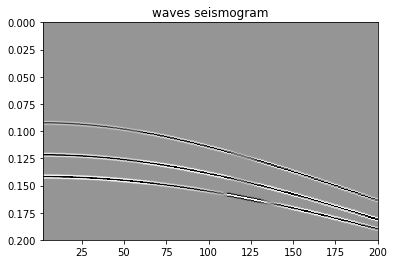

In [65]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
plt.show()

NameError: name 'inversed_vals' is not defined

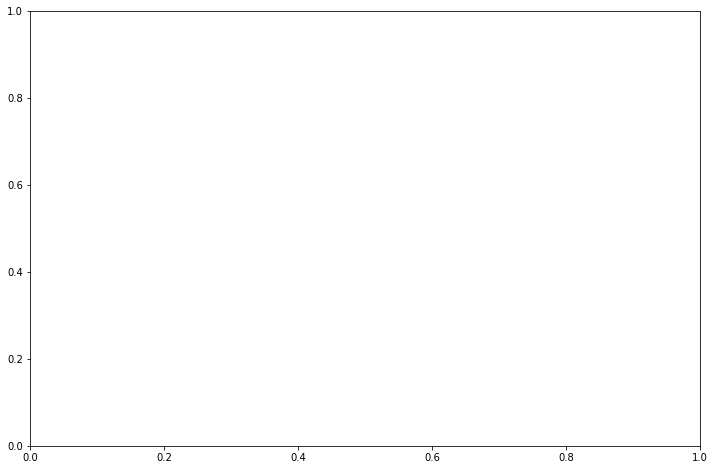

In [37]:
fig, axes = plt.subplots(figsize=(12,8))

plot_2D_err(forward_params, [8, 8], 15, points=[[inversed_vals[0]], [inversed_vals[1]]], fig=fig, ax=axes)

plt.show()

# Extra plot

In [34]:
import itertools

261.0299491882324


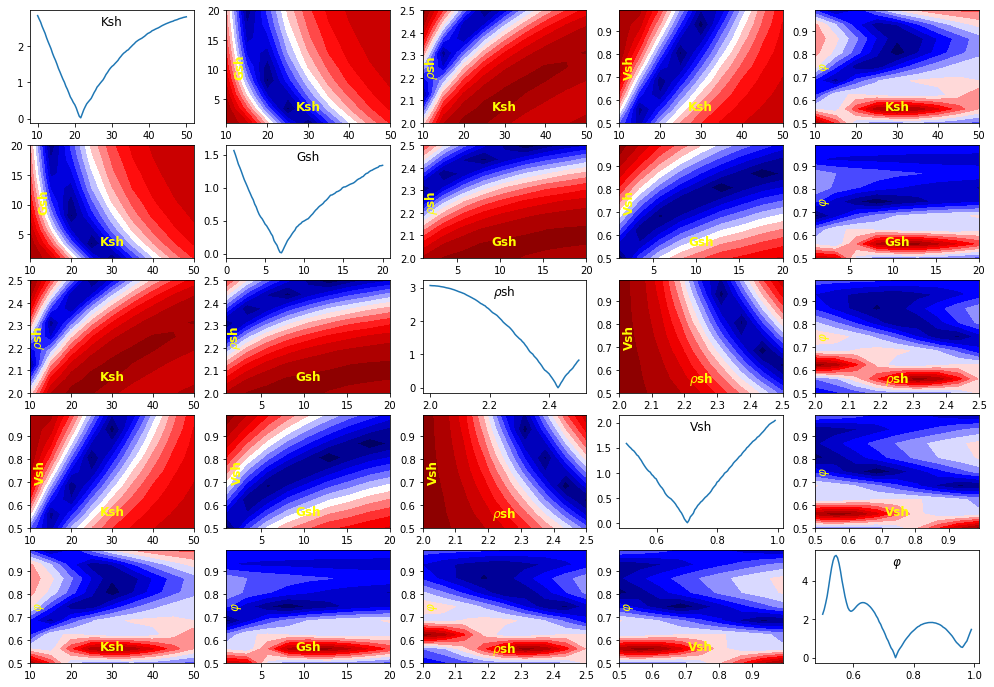

In [77]:
start_time = time.time()

optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

lables = [
    'Ksh',
    'Gsh',
    r'$\rho$sh',
    'Vsh',
    r'$\varphi$'
]

labels_dict = dict(zip(optimization_list, lables))

fig, axes = plt.subplots(len(optimization_list), len(optimization_list), figsize=(17,12))

for i, ol1 in enumerate(optimization_list):
    for j, ol2 in enumerate(optimization_list):
        layer_2_rp = get_layer2_rp()
        for key in layer_2_rp['components'].keys():
            if key in (ol1, ol2):
                layer_2_rp['components'][key]["optimize"] = True
            else:
                layer_2_rp['components'][key]["optimize"] = False
                
        layer_2 = Layer1D(h[1],
              rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
              seism_attribute=None,
              opt=LayerOPT.RP)

        forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

        if ol1 == ol2:
            plot_1D_err(forward_params, 100, ax=axes[i, j])
            axes[i,j].set_xlabel(labels_dict[ol1], labelpad=-15, fontsize=12)
            axes[i,j].xaxis.set_label_position("top")
#             axes[i,j].set_title(ol1)

        else:
#             print(ol1, ol2)
            plot_2D_err(forward_params, [8, 8], 15, fig=fig, ax=axes[i, j])
    
#             if j == 0 or i == 0 or j == len(optimization_list) - 1 or i == len(optimization_list) - 1:
            
            common_plot_params = {
                'labelpad':-40,
                'color': 'yellow',
                'weight': 'bold',
                'fontsize': 12
            }

            if i > j:
                axes[i,j].set_xlabel(labels_dict[ol2], **common_plot_params)
                axes[i,j].set_ylabel(labels_dict[ol1], **common_plot_params)

            elif i < j:
                axes[i,j].set_xlabel(labels_dict[ol1], **common_plot_params)
                axes[i,j].set_ylabel(labels_dict[ol2], **common_plot_params)

#                 if j == len(optimization_list) - 1:
#                     axes[i,j].yaxis.set_label_position("right")

#                 if i == 0:
#                     axes[i,j].xaxis.set_label_position("top")
            
            
        
        
print(time.time() - start_time)
                
plt.show()
            
          

# Extra plot VP/VS/Rho

In [42]:
[1,2,3]

[1, 2, 3]

In [74]:
def rmsre(obs, mod):
    arr = ((obs - mod) / obs) ** 2

    arr = arr[np.isfinite(arr)]

    return np.sqrt(np.mean(arr))

def vpvsrho_err_func(val, forward_params, vpvsrho_true):
    forward_params['model'].set_optimization_option(val)
    forward_params['model'].layers[1].calculate_rockphysics()
    vpvsrho = np.array([forward_params['model'].layers[1]['vp'], 
                        forward_params['model'].layers[1]['vs'],
                        forward_params['model'].layers[1]['rho']
                       ])
#     print(vpvsrho)
    
    return rmsre(vpvsrho_true, vpvsrho)

def single_param_err_func(val, forward_params, param_true, param_name='vp'):
    forward_params['model'].set_optimization_option(val)
    forward_params['model'].layers[1].calculate_rockphysics()
    
    param_ind = ['vp', 'vs', 'rho'].index
    
    vpvsrho = np.array([forward_params['model'].layers[1]['vp'], 
                        forward_params['model'].layers[1]['vs'],
                        forward_params['model'].layers[1]['rho']
                       ])
#     print(vpvsrho)
    
    return rmsre(vpvsrho_true, vpvsrho)
    
    

0.6744790077209473


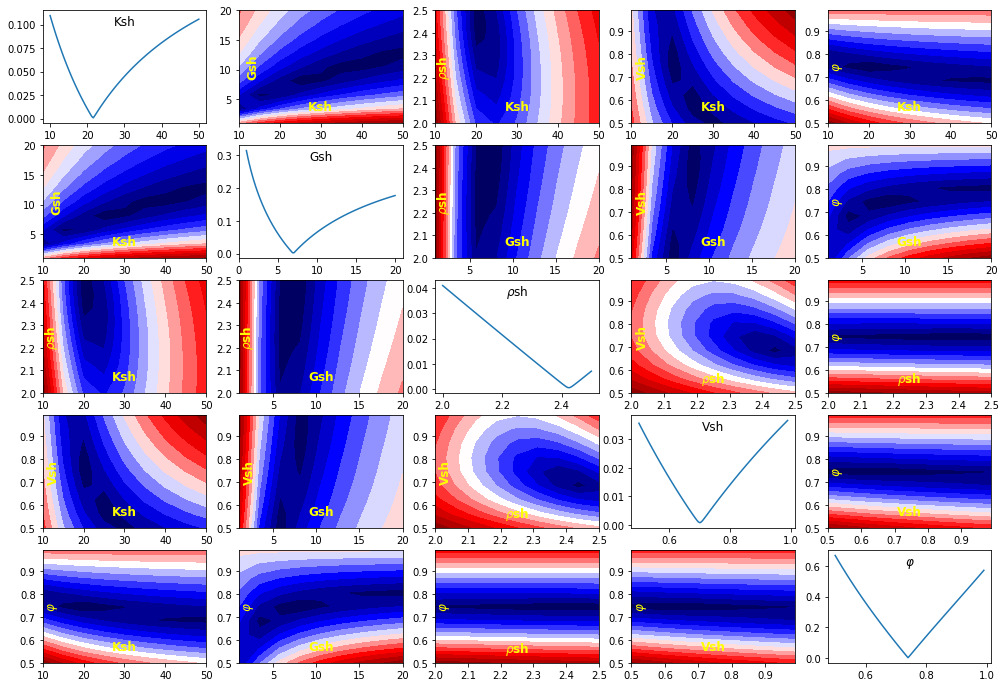

In [76]:
start_time = time.time()

optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

fig, axes = plt.subplots(len(optimization_list), len(optimization_list), figsize=(17,12))

lables = [
    'Ksh',
    'Gsh',
    r'$\rho$sh',
    'Vsh',
    r'$\varphi$'
]

labels_dict = dict(zip(optimization_list, lables))

vpvsrho_true = [1534, 200, 1352]
err_func_params = [None, forward_params, vpvsrho_true]

for i, ol1 in enumerate(optimization_list):
    for j, ol2 in enumerate(optimization_list):
        layer_2_rp = get_layer2_rp()
        for key in layer_2_rp['components'].keys():
            if key in (ol1, ol2):
                layer_2_rp['components'][key]["optimize"] = True
            else:
                layer_2_rp['components'][key]["optimize"] = False
                
        layer_2 = Layer1D(h[1],
              rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
              seism_attribute=None,
              opt=LayerOPT.RP)

        forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

        if ol1 == ol2:
            plot_1D_err(forward_params, 100, ax=axes[i, j], err_func=vpvsrho_err_func, err_func_params=err_func_params)
            axes[i,j].set_xlabel(labels_dict[ol1], labelpad=-15, fontsize=12)
            axes[i,j].xaxis.set_label_position("top")

        else:
#             print(ol1, ol2)
            plot_2D_err(forward_params, [8, 8], 15, fig=fig, ax=axes[i, j], err_func=vpvsrho_err_func, err_func_params=err_func_params)
            
            common_plot_params = {
                'labelpad':-40,
                'color': 'yellow',
                'weight': 'bold',
                'fontsize': 12
            }

            if i > j:
                axes[i,j].set_xlabel(labels_dict[ol2], **common_plot_params)
                axes[i,j].set_ylabel(labels_dict[ol1], **common_plot_params)

            elif i < j:
                axes[i,j].set_xlabel(labels_dict[ol1], **common_plot_params)
                axes[i,j].set_ylabel(labels_dict[ol2], **common_plot_params)
            
        
        
print(time.time() - start_time)
                
plt.show()
            
          

In [39]:
forward_params['model'].layers[0].seism_attribute.vp

1500

# Repeats optimizations

In [32]:
import itertools

In [33]:
start_time = time.time()

optimization_list = [
#     "Ksi",
#     "Gsi",
#     "rhosi",
    "Ksh",
    "Gsh",
    "rhosh",
#     "Kfl",
#     "rhofl",
    "Vsh",
#     "Vincl",
    "phi"
]

results = []
nrepeats = 8

for comb in itertools.combinations(optimization_list, 2):    
    res_tmp = []
    stats_tmp = []
    layer_2_rp = get_layer2_rp()
    for key in layer_2_rp['components'].keys():
        if key in (comb[0], comb[1]):
            layer_2_rp['components'][key]["optimize"] = True
        else:
            layer_2_rp['components'][key]["optimize"] = False

    layer_2 = Layer1D(h[1],
          rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
          seism_attribute=None,
          opt=LayerOPT.RP)

    forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])
    
    for i in range(nrepeats):
        inversed_vals, stats = inverse(optimizers_de, error=None, 
                                       placeholders=placeholders, 
                                       forward_params=forward_params, scale=None)
        forward_params['model'].set_optimization_option(inversed_vals)
        res_tmp.append(forward_params['model'].get_optimization_option('val'))
        stats_tmp.append(stats)
        
    results.append({
        "name": f"{comb[0]}_{comb[1]}",
        "vals": list(res_tmp),
        "stats": list(stats_tmp)
    })
    
print(time.time() - start_time)

/home/apenkin/.local/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.6585521200106617


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.9671223818809148


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


3.0996534370493523


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


2.422296013973252
2.040414885691666


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


1.5070898945779378


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.05878446784710307


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.6890116460132193
2.9367583585999166
2.2964504464758484
2.1994232872789965
0.3450730474328254
1.878029185837234
2.713812449504356
1.432281788979125
1.76178961976317
0.12154340604780682
2.0287476892844722
2.9357749829198094
2.844802498923592
0.12545634231435415
differential_evolution step 1: f(x)= 0.0587845
2019-11-30 21:56:17.283284
1.4400947276205722
2.182371644025
1.0061090048976444
2.861337077345662
0.9447860163303615
1.1526889946654342
0.36162235016256833
0.5919564258942017
0.5471513169347624
2.9652720621488275
differential_evolution step 2: f(x)= 0.0587845
2019-11-30 21:56:17.784740
0.5845248131233548
1.5203317916133872
1.773552426724125
0.8435126971238878
1.910781967857079
1.9838485900851872
1.4700692240213402
0.5845248131233548
0.7828652761654046
differential_evolution step 3: f(x)= 0.0587845
2019-11-30 21:56:18.330108
1.5881080927259752
1.6510716501198237
1.8871781267982566
1.7966655777074272
0.7525399354919033
0.05878446784710307
1.3969612667504088
0.8923294375130564
1.485066

differential_evolution step 31: f(x)= 0.00662513
2019-11-30 21:56:33.372445
2.5115839327740783
0.0777274130131154
1.3008140270168582
0.6386191993971475
3.2246991751420984
1.8898742450711676
0.2937985266720426
1.432646187909985
1.782005269850752
2.378894459020391
differential_evolution step 32: f(x)= 0.00662513
2019-11-30 21:56:33.915397
0.1013904615793476
0.44402760190343077
0.3034548902794127
1.1345753595720518
1.7796928225177284
0.2604062422575184
1.1223539867088788
0.7844083445078778
2.2258905399317226
differential_evolution step 33: f(x)= 0.00662513
2019-11-30 21:56:34.481254
0.5058696612764858
2.267021338628947
0.44391438880649564
0.1874441286712784
0.9701958563926308
0.5509498604325248
0.5642726491549489
0.584419718091714
0.4077474707458285
1.8657877856762488
differential_evolution step 34: f(x)= 0.00662513
2019-11-30 21:56:35.052870
1.5372274857688981
0.6386191993971475
2.9059042032831557
1.4494437244045029
2.589727952471867
1.1602269058173755
0.1381429867655968
0.40937556745927

0.44274768840227474
0.006625134280225371
0.006625134280225287
0.01973725245850446
0.006625134280225499
differential_evolution step 62: f(x)= 0.00662513
2019-11-30 21:56:53.684090
0.006625134280225434
0.055878110912628225
0.01973725245850474
0.006625134280225287
0.08187989486166393
0.006625134280225287
0.006625134280225371
0.28630483300661363
0.09494629703159664
0.006625134280225371
differential_evolution step 63: f(x)= 0.00662513
2019-11-30 21:56:54.509738
0.006625134280225287
0.006625134280225258
0.30865579096255497
0.006625134280225287
0.05587811091262863
0.006625134280225088
0.3086557909625549
0.006625134280225371
0.006625134280225518
0.0066251342802251725
differential_evolution step 64: f(x)= 0.00662513
2019-11-30 21:56:55.398963
0.006625134280225088


/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


0.0066251343078916215
0.006625134259396703
0.006613156189931375
0.006613156217258211
0.006613156168792074
0.1432069889494581
0.14320698889852382
0.1432069889360055
0.010212809116978952
0.010212809142964336
0.01021280909464131
0.00661259064804726
0.00661259067536634
0.006612590626899993
0.010259681464408265
0.010259681491013263
0.010259681442623127
0.006612404432108314
0.006612404459426889
0.006612404410959759
0.0066122192939535775
0.006612219321268944
0.006612219272801541
0.006580282066439228
0.006580282093317556
0.006580282044893249
0.010270520834676522
0.010270520861426808
0.010270520813022035
0.006580262128311577
0.006580262155189645
0.00658026210676594
0.006566380462261257
0.006566380488950562
0.006566380440546162
0.00656166304746909
0.0065616630740946875
0.006561663025696786
0.00656166304746909
0.0065616630740946875
0.006561663025696786
0.5176157686475554
0.5176157686208644
0.5176157686373121
0.010032272782918737
0.010032272807611221
0.010032272759465978
0.010270305077015757
0.010

1.466626687504004
1.024553597558507
0.47326405789905357
0.48070562194008487
0.7329869673596651
1.8772349500153922
1.0663030724591003
0.4773362483800871
0.7270068488851298
differential_evolution step 9: f(x)= 0.0326096
2019-11-30 21:57:39.913443
0.7699126112646953
0.23442040679250897
2.6366801200116354
2.040833685391754
2.189259387933587
2.853856567614682
0.24929388392546434
0.4773362483800871
0.7481599482698282
0.9474791641463624
differential_evolution step 10: f(x)= 0.0326096
2019-11-30 21:57:40.515441
0.33380338941591536
2.1294753936355884
0.5106682930884257
1.585115733389089
1.3670519412534166
1.5919902065079525
0.046718318959132636
1.4415402469445808
0.19843383529122485
1.9950944613696007
differential_evolution step 11: f(x)= 0.0326096
2019-11-30 21:57:41.064673
1.5098271457307342
0.0673216342165156
0.2679138298519393
0.7939876557760539
0.30134233937383564
0.034656610039563704
0.7230376573724324
0.07236491031964465
1.4477541727477927
0.3252591885137305
differential_evolution step 1

/home/apenkin/.local/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


0.03260961806349379
0.032609618019252
0.0325962396908293
0.0325962396996559
0.03259623965539568
0.2089939767178553
0.20899397672444
0.20899397673717215
0.03248656732843837
0.03248656733780178
0.032486567293512285
0.09098645843594727
0.09098645844952478
0.09098645847112181
0.03241628875047277
0.0324162887602041
0.03241628871589315
0.05291851581639414
0.05291851586700438
0.05291851585384177
0.03233532198707439
0.032335321997263224
0.03233532195291906
0.02710307834505259
0.027103078406624927
0.027103078360575864
0.04081250608505356
0.040812506070195556
0.04081250611034444
0.03063568701090549
0.03063568707381182
0.03063568702972565
0.02710167378007199
0.02710167384165619
0.02710167379561453
0.02703616060388482
0.02703616066609325
0.027036160620483755
0.030670484324146794
0.030670484386707705
0.030670484342227838
0.027035936316305263
0.027035936378516957
0.02703593633291172
0.027019886330086833
0.027019886392454603
0.027019886346975386
0.026993033723180775
0.026993033785814483
0.02699303374

2.000892923341239
0.6527841874872035
1.0839438428142198
1.516089250500877
1.9166152639643177
2.981531276483548
2.5736570862520707
0.0370961373245516
0.3957523153994504
0.5185394175425931
differential_evolution step 16: f(x)= 0.0370961
2019-11-30 21:58:30.719523
2.9688814196355358
0.34280520499812306
1.8250350934482087
0.6605380424782736
0.47890002078202654
1.7268837807855115
2.897860868352199
1.5328594546139065
0.36519093037467737
0.9236243103835693
differential_evolution step 17: f(x)= 0.0370961
2019-11-30 21:58:31.356310
0.06020276940708806
0.45563182193359747
0.9255155578415613
2.023232616946018
0.02686403748377973
0.8953080192045784
0.6159989871097927
0.04793383970637982
2.3693390823640073
1.8417072927735312
differential_evolution step 18: f(x)= 0.026864
2019-11-30 21:58:32.022414
0.5470486829047134
0.20013984064884258
0.3577812257793947
0.2070805360925501
0.17345303294622327
0.7200108874507063
2.4729340860240616
1.3294833696233854
1.9514211059812843
0.5470486829047134
differential

0.038098451929489956
0.047464776066599164
0.04639151975344562
0.03432925238787795
0.22043712569836849
0.1843634745537808
differential_evolution step 46: f(x)= 0.0214903
2019-11-30 21:58:49.806428
0.047464776066599164
0.1353341635778326
0.025926592905461215
0.20400259808389656
0.03449257105508737
0.1350715108513232
0.03751607760154405
0.042147203080332485
0.22080474269841402
0.024204647537276875
differential_evolution step 47: f(x)= 0.0214903
2019-11-30 21:58:50.434054
0.0318751605111863
0.15446951578751417
0.14217347703889688
0.022376872883532007
0.12211680221621557
0.3456059509048196
0.028878660291062938
0.10064578458247486
0.019850746964205537
0.03462050041249742
differential_evolution step 48: f(x)= 0.0198507
2019-11-30 21:58:51.071585
0.29615733345277134
0.030900047480076315
0.03215656905040045
0.4791763127530731
0.032385481034522504
0.11343129201826485
0.17112955666002433
0.03285656402081779
0.15026562385536735
0.17976607396253091
differential_evolution step 49: f(x)= 0.0198507
20

0.026905051697390426
0.031089962560351764
0.019431150423947732
0.03772811662016918
0.019466003880903453
0.019393136453502043
0.019813195152233183
0.06946108359556037
0.022809081387996415
0.016486804250512493
differential_evolution step 76: f(x)= 0.0160899
2019-11-30 21:59:09.778801
0.01675187373649355
0.022755338079368158
0.019446992049457403
0.016515937088108966
0.022701616836408266
0.04180767233861626
0.016147042520593454
0.04529021032318597
0.04167355050998067
0.016099539620529475
differential_evolution step 77: f(x)= 0.0160899
2019-11-30 21:59:10.673511
0.016075355617778654
0.04534408659759074
0.05155672828541823
0.02739196942631251
0.01958672778208172
0.022701616836408266
0.02256899418048722
0.016152755138342738
0.04528177071965367
0.0784764145042564
differential_evolution step 78: f(x)= 0.0160754
2019-11-30 21:59:11.361798
0.022600557541856803
0.023276675451009213
0.016089865648043045
0.01615438808847507
0.016501399367653147
0.03106296683529386
0.022366413982318912
0.022737955219

0.014653855805249893
0.01812639118922298
0.018126391144999428
0.018126391195757013
0.014653855781673969
0.014653855736656056
0.014653855788270326
0.014653855764693987
0.014653855719677356
0.014653855771291247
0.01812668363737602
0.018126683593146658
0.018126683643906433
0.014653855760449783
0.014653855715433102
0.014653855767046343
0.01812678307197131
0.01812678302774014
0.018126783078501255
0.01465385575860104
0.01465385571358476
0.014653855765198275
0.014653855756752234
0.014653855711735723
0.014653855763349037
0.018107301917384945
0.01810730187386415
0.018107301924299
0.014654370075645786
0.01465437003062004
0.014654370082238103
0.018122765660185582
0.018122765616112882
0.018122765666801325
0.014654368966403267
0.01465436892137841
0.014654368972995917
0.014654198364092185
0.014654198319072888
0.014654198370687887
0.018125037493488226
0.01812503744933327
0.01812503750005947
0.01465419810633343
0.014654198061313095
0.014654198112929026
0.014654197848626191
0.014654197803606288
0.01465

1.392085647589315
1.392085647589315
0.05280933281617079
1.7445651600880356
0.05280933281617079
1.3555134258680261
0.5516005288927681
2.187398767876273
1.392085647589315
1.16218037015946
differential_evolution step 24: f(x)= 0.00885158
2019-11-30 22:00:09.820888
0.031660728328512286
0.48805230322728593
2.15312051988166
2.9687881474841236
0.4132003730587547
0.7921403324189766
1.5400819925480953
1.1405245731141502
0.1931964879959964
differential_evolution step 25: f(x)= 0.00885158
2019-11-30 22:00:10.433872
1.2309481102208002
0.008851576698686452
1.392085647589315
1.162218960618176
1.9792890401499108
0.008851576698686452
0.4132003730587547
0.1931964879959964
0.44325401109025475
1.0141317093905613
differential_evolution step 26: f(x)= 0.00885158
2019-11-30 22:00:11.045643
0.1931964879959964
0.9323282623498427
1.667318244580582
1.7737834950563158
0.008851576698686452
0.008851576698686452
0.4807659327208549
0.008851576698686452
0.008851576698686452
1.2298736097319634
differential_evolution s

1.6848748257549238
0.39983567200881187
0.4839769405936414
0.44193444001387083
0.6643475614779772
2.3826242390591763
1.4039085135961318
0.5185614963040059
0.2520064380960246
2.0285570842723812
1.012478262995693
differential_evolution step 9: f(x)= 0.0740367
2019-11-30 22:00:51.032849
1.0293320555650967
0.6868593137396647
2.3092806561874486
1.6912812060895785
0.18423766568296654
0.3842346389217175
2.6125278879886125
1.6253179455058757
3.225435785249114
differential_evolution step 10: f(x)= 0.0740367
2019-11-30 22:00:51.642897
1.7464677191081417
0.5998074225083263
0.4901736951538642
2.8005349343829637
2.264307126945227
2.967574725346188
2.814490052441541
0.2005892984221829
0.07964540819795377
1.1743297871912763
differential_evolution step 11: f(x)= 0.0740367
2019-11-30 22:00:52.265778
1.9750666431750594
0.23729261051465825
2.4882616606982557
1.4494466361305158
0.08886084982798545
1.2825861446559932
2.8772252947578365
0.8051813643131578
0.35610807824608004
0.4410232742381189
differential_e

0.023340545741851074
0.026084151174447456
differential_evolution step 39: f(x)= 0.0156772
2019-11-30 22:01:10.220588
0.01564975909098918
0.026663190928732834
0.026266138128807695
0.019312597413029788
0.026000787471606935
0.023173363574573565
0.06356422124773416
0.1159791902746414
0.051878985596704986
0.026224929687539148
differential_evolution step 40: f(x)= 0.0156498
2019-11-30 22:01:10.867853
0.029354701063755387
0.026683959559227186
0.0329101004388769
0.026575308923102323
0.0226228613359933
0.026564423971695596
0.02597052143715368
0.05619326764063955
0.06682463972801234
0.019422605706803955
differential_evolution step 41: f(x)= 0.0156498
2019-11-30 22:01:11.486732
0.045753287773007245
0.018923168703198465
0.01594319515783743
0.026045106036469944
0.050398651264098523
0.03370782814702494
0.02315025523057535
0.051566284480532104
0.05536555805729736
0.1052592421258927
differential_evolution step 42: f(x)= 0.0156498
2019-11-30 22:01:12.166113
0.05158413232287231
0.03748720924408706
0.022

0.07021016910047083
0.012330175938547546
0.12333301284345335
0.06911173725174798
0.12333301284345335
0.37808394897371905
0.18950291375909845
0.008462439951891783
0.07981889456670396
0.006316883281462474
differential_evolution step 69: f(x)= 0.00631688
2019-11-30 22:01:30.196965
0.011542459608595613
0.05435108487906084
0.01755920982812522
0.006316883281462474
0.15026451591569245
0.031084424619399205
0.006316883281462474
0.006316883281462474
0.01358233665901046
0.06633071631877768
differential_evolution step 70: f(x)= 0.00631688
2019-11-30 22:01:30.854956
0.006316883281462474
0.017927213958506997
0.006316883281462474
0.006316883281462474
0.2508351532465442
0.006316883281462474
0.009540298687640884
0.006316883281462474
0.1291619000706382
0.006316883281462474
differential_evolution step 71: f(x)= 0.00631688
2019-11-30 22:01:31.515389
0.006316883281462474
0.006316883281462474
0.006316883281462474
0.006316883281462474
0.006316883281462474
0.007387760678587014
0.11041524435791558
0.1502645159

differential_evolution step 8: f(x)= 0.0696264
2019-11-30 22:02:10.545340
0.1691343767440042
0.16768603861941775
0.5391689990308046
0.5391689990308046
0.3977873036805767
1.2351310748098516
2.3029727476232136
2.4252931144156586
1.9397855220404825
2.298138833168503
1.6859154129479308
differential_evolution step 9: f(x)= 0.0696264
2019-11-30 22:02:11.277897
0.4956968773588664
1.1060675908528153
0.2110158436761962
2.3473815395894033
0.42268059545023484
1.0488886599170426
0.48286578425913396
0.8905627530454614
0.4425786421850951
differential_evolution step 10: f(x)= 0.0696264
2019-11-30 22:02:11.958072
0.27703177480089997
1.6401183457723463
1.0196905542562826
0.3321529595794538
2.3768927380502056
0.09855352883897597
2.381631866272073
1.6534245270903178
0.18174237162235124
0.7764081159715075
differential_evolution step 11: f(x)= 0.0696264
2019-11-30 22:02:12.628878
0.3216103332899428
2.2426222837213152
0.2145935666937598
0.9552449917329446
0.9858198147244664
2.495404668526677
1.2600007165813

differential_evolution step 39: f(x)= 0.0146507
2019-11-30 22:02:31.074994
0.4074809313128841
1.3946248510530614
0.7607193950175543
0.25040762720307963
2.1327772503128686
0.2594245915612824
0.592237084896051
1.5473654722804437
2.0289082415453237
0.5792293095896134
differential_evolution step 40: f(x)= 0.0146507
2019-11-30 22:02:31.698312
1.356092995223737
0.1544568664645472
1.0239024655431035
0.6648947140581367
0.5724842758190045
0.2678329942714461
0.584466553814665
0.3534919409975768
0.5516405019302714
0.6820677841112278
differential_evolution step 41: f(x)= 0.0146507
2019-11-30 22:02:32.373925
2.342356883470125
2.775950482832548
0.9083007798447611
1.5845899569754125
1.6617885981343328
0.9069693844060712
2.6794452837389597
0.12466373335730664
0.9204401462884699
0.9799645005216
differential_evolution step 42: f(x)= 0.0146507
2019-11-30 22:02:33.097225
0.39789328013503295
1.6434863490771237
0.41338374930123994
0.626941992861801
0.3633499771180244
0.4074809313128841
2.1406570338893776
0.

0.09386253146812452
0.820669272278774
0.16516437207530468
0.3338454000163711
0.017340872846741143
differential_evolution step 70: f(x)= 0.00874146
2019-11-30 22:02:51.899211
0.28762595782721456
0.48284745520940137
0.12628692129892055
0.39741551370060435
0.008741456901701946
0.16516437207530468
0.008741456901701946
1.1348143942049334
0.008741456901701946
0.017340872846741143
differential_evolution step 71: f(x)= 0.00874146
2019-11-30 22:02:52.568281
0.008741456901701946
0.48284745520940137
0.09386253146812452
0.5841779099396363
0.3621954814127121
0.26795983113997524
0.5841779099396363
0.017340872846741143
0.5276170679676151
0.008741456901701946
differential_evolution step 72: f(x)= 0.00874146
2019-11-30 22:02:53.252900
0.054044284031648085
0.008741456901701946
0.6731088346081959
0.008741456901701946
0.008741456901701946
0.008741456901701946
0.12372617838673587
0.8322210727038788
0.008741456901701946
0.09386253146812452
differential_evolution step 73: f(x)= 0.00874146
2019-11-30 22:02:53

1.4947926301084578
0.4265387876186493
0.46457653449529335
0.42151416863809454
0.2786257313818099
0.18987795853342004
0.19032820647911086
0.3614608556220394
0.29773501784131484
differential_evolution step 9: f(x)= 0.0609156
2019-11-30 22:03:27.582829
0.08310070328423254
0.32964349955577166
0.2590725061121289
0.6216829545247475
0.38631625345200915
1.929010931294371
2.763783440328498
0.08127529548497921
0.27479985988406896
0.14374577803219749
differential_evolution step 10: f(x)= 0.0609156
2019-11-30 22:03:28.209120
1.3377004767760334
0.8551423681993701
0.2940193833927587
0.34562123288871777
0.3031610937071386
1.4334722430383933
1.0878185230987771
0.10675223278899333
0.03600719282438303
0.3927284259584947
differential_evolution step 11: f(x)= 0.0360072
2019-11-30 22:03:28.882325
1.6568672072607151
0.40851469294313164
0.13513149247761477
0.35898922095205865
0.5393376922008212
0.5722656858163561
0.029538152978887105
0.11269537206234757
0.4761755365297824
0.353817407271655
differential_evolu

0.01620161411201663
0.03067079863187498
0.008764763536295928
0.2603070328041053
0.3088015865228931
0.008764763536295928
0.3273547290623393
differential_evolution step 39: f(x)= 0.00502888
2019-11-30 22:03:49.965881
0.18400943729126198
0.0068947412537413095
0.01620161411201663
0.19523906401072416
0.13571781348372022
0.05912265964372383
0.005028882072392158
0.005028882072392158
0.005028882072392158
0.005028882072392158
differential_evolution step 40: f(x)= 0.00502888
2019-11-30 22:03:51.182672
0.3088015865228931
0.18400943729126198
0.005028882072392158
0.18760309830758184
0.13014695068664212
0.2980276904355335
0.008764763536295928
0.005028882072392158
0.29213782110993214
0.005028882072392158
differential_evolution step 41: f(x)= 0.00502888
2019-11-30 22:03:52.260072
0.18400943729126198
0.005028882072392158
0.18400943729126198
0.005028882072392158
0.13014695068664212
0.13571781348372022
0.005028882072392158
0.01620161411201663
0.19523906401072416
0.010540580601481463
differential_evolutio

0.004950700221870951
0.004950700271153563
0.004950700258796656
0.004950700221867331
0.004950700271150475
0.0049506949767238
0.004950694939794558
0.004950694989078268
0.004950694976722943
0.00495069493979345
0.00495069498907655
0.0049506935390587195
0.004950693502131297
0.004950693551413056
0.008580718103989598
0.008580718067797264
0.008580718116242123
0.004950693539058768
0.004950693502131179
0.004950693551412707
0.0049506935390587195
0.004950693502131297
0.004950693551413056
0.01578835221077864
0.015788352180539433
0.01578835222720304
0.00858018602729797
0.008580185991123514
0.008580186039563162
0.004950693525494932
0.004950693488566203
0.004950693537849155
0.004950693511930694
0.0049506934750020845
0.00495069352428537
0.008580452984294646
0.008580452948111661
0.00858045299655257
0.004950693508539492
0.00495069347161151
0.004950693520893965
0.0049506933821450725
0.00495069334521701
0.004950693394499426
0.008580586407355607
0.008580586371168375
0.008580586419610915
0.004950693381298334

differential_evolution step 21: f(x)= 0.0199259
2019-11-30 22:05:21.452750
0.19155007790494102
2.007990490921382
0.5174886631393266
0.024839492817062683
1.8785187416385776
1.3482351826055636
1.7523600648189475
0.2345259998885327
0.0354836486829841
0.4503936500632374
differential_evolution step 22: f(x)= 0.0199259
2019-11-30 22:05:22.060778
1.7955068397002716
0.36141647294527174
0.1626932653213993
0.5976134478735174
1.534762635979374
0.522702558865017
0.19424482965698256
0.024645129278622186
0.39070778111723153
2.2854419252834846
differential_evolution step 23: f(x)= 0.0199259
2019-11-30 22:05:22.664565
0.40248291902205463
0.057271619768077785
1.7564718455304213
3.173960272660854
3.1419811122838284
2.1203730699247867
0.40248291902205463
2.5049600446945908
0.31591429439114965
0.057094921877281594
differential_evolution step 24: f(x)= 0.0199259
2019-11-30 22:05:23.315301
0.822002706038163
1.0218940800458656
0.02187986974395986
1.0117099044749276
0.2960091894926983
0.624595923123726
1.7462

0.011475807560269403
0.011475807560269403
0.004023522934227252
0.004023522934227252
0.011475807560269403
0.004023522934227252
0.004023522934227252
0.004023522934227252
0.004023522934227252
differential_evolution step 52: f(x)= 0.00402352
2019-11-30 22:05:41.182685
0.004023522934227252
0.004023522971487212
0.004023522921384735
0.004008141183783475
0.004008141219838732
0.004008141169764696
0.032328440776097936
0.03232844078538324
0.032328440741252684
0.003996618176511398
0.003996618212091647
0.003996618162029929
0.021595597539246024
0.021595597554098712
0.0215955975078537
0.00398875709363161
0.003988757128892466
0.003988757078839388
0.014461637850309364
0.01446163786931483
0.014461637821844722
0.003983156243104182
0.003983156278139363
0.003983156228092889
0.010960765964720637
0.010960765987399344
0.01096076593902549
0.003979574858198128
0.003979574893089477
0.003979574843047186
0.01107866619408835
0.011078666219700398
0.011078666171089576
0.0039780496450992605
0.0039780496799293645
0.003

1.3913935966149857
2.8922902466152585
2.5391957641004432
0.31828039528109964
1.266906017802016
2.887890610938813
1.6955413064103757
1.6210817850191226
2.07726920297902
differential_evolution step 12: f(x)= 0.0349783
2019-11-30 22:06:20.704094
2.781427479128436
1.8199575662467553
0.04223896395758868
1.0357557915878841
0.5242454399344304
2.517705539339339
1.9072266755309657
2.81694128752218
1.0928834201183322
1.6188509410490972
differential_evolution step 13: f(x)= 0.0349783
2019-11-30 22:06:21.326796
2.2903583310945876
1.8783750507249748
0.46907809216629087
2.9015280684211815
0.30758058160434215
2.990679102771994
1.352871853280348
2.8676583372572053
1.2296825712641433
1.5312012937329305
differential_evolution step 14: f(x)= 0.0349783
2019-11-30 22:06:21.932519
2.5634451656230386
3.0547188096186173
1.3080123728311661
0.22941665602960934
1.8652480640257514
0.018171797641396998
1.5312012937329305
2.9973365010529647
1.2898889769486064
2.6397112135149214
differential_evolution step 15: f(x)=

0.1496721876496406
1.8568356372572785
0.01911612032500049
0.13343730616075822
0.30936880359018765
0.44218066614653656
2.9838181938027986
0.037703724104270656
1.5148184085066843
0.14112005357857066
differential_evolution step 43: f(x)= 0.00903134
2019-11-30 22:06:40.026428
1.0674061728565882
3.0169369181723384
0.12498211482989907
1.920151589183245
1.4061780042528926
0.02052279854058206
1.755650079967817
0.8862430757435621
0.01911612032500049
0.2363863919318442
differential_evolution step 44: f(x)= 0.00903134
2019-11-30 22:06:40.615795
0.32786636342501063
1.0146901310158436
3.0401077309535482
0.004561629632503278
0.17054103134756765
0.3515357269556599
0.014096340857599032
0.3273505073587599
0.8428101320502944
0.0891871783264945
0.5563481828877342
differential_evolution step 45: f(x)= 0.00456163
2019-11-30 22:06:41.208673
1.758802448997672
0.31051440470498104
0.7699313262872453
2.624538449807987
0.7399959645397574
1.2899776274618175
3.03277631281524
1.354568042191828
0.013132444856230205


1.3506238081234104e-06
1.3506717340571398e-06
1.348595932336317e-06
3.0608582462016736e-06
3.0608452887920613e-06
3.063118729919784e-06
7.603317528367469e-07
7.604002892275822e-07
7.594516456111242e-07
4.250496165591174e-06
4.250447800689232e-06
4.252512249177062e-06
5.563515357153337e-07
5.563508137438368e-07
5.584660198418914e-07
1.5785801153037778e-07
1.5779030773598152e-07
1.5864074011904527e-07
5.225531798417987e-07
5.225939704209513e-07
5.20356410717066e-07
1.2576085806118426e-07
1.2573891936720978e-07
1.240937092229794e-07
3.4131677421123534e-07
3.4138052578478143e-07
3.4084049605140667e-07
5.651575831639526e-08
5.654991832739573e-08
5.4221070769679975e-08
1.2415211763650594e-07
1.2417279389853496e-07
1.2586477747818198e-07
3.77778558795924e-08
3.784648059079171e-08
3.6779549149055936e-08
6.32041495767073e-08
6.316302593244457e-08
6.540204488707693e-08
1.3587162154916779e-08
1.36181713638036e-08
1.5017371432618492e-08
2.3412777215583253e-08
2.3346304379778482e-08
2.4137173809946

0.752650757111238
0.7576093216085201
2.214247969715142
0.15701665223733088
0.752650757111238
0.11405598679729484
0.003701697092457204
0.003701697092457204
0.003701697092457204
0.003701697092457204
2.1628207163431235
differential_evolution step 26: f(x)= 0.0037017
2019-11-30 22:07:30.876614
0.003701697092457204
1.6436697756603844
1.0858749940033356
0.8864479488622452
2.7111697405553685
1.8952258267348037
0.5910371311184233
0.003701697092457204
0.003701697092457204
differential_evolution step 27: f(x)= 0.0037017
2019-11-30 22:07:31.504200
0.5752072374114265
1.6436697756603844
2.689140131483162
0.003701697092457204
0.003701697092457204
2.596062056327902
0.5147291451293186
2.977442998135978
0.003701697092457204
0.003701697092457204
differential_evolution step 28: f(x)= 0.0037017
2019-11-30 22:07:32.141949
0.003701697092457204
0.0037016970377294124
0.003701696935820574
0.22951446903814565
0.22951446900157815
0.22951446961982547
0.0037016418303285497
0.003701641775520952
0.003701641678233843

2.3971480862318573
3.0227648136398075
0.47077599971522016
0.7664745878307915
2.228837729054927
0.9760977757067538
2.992314036835949
1.468483788192787
differential_evolution step 11: f(x)= 0.0922555
2019-11-30 22:08:09.187666
1.8858938694569978
2.988731719339854
1.8801302139540779
3.039215941333198
2.4888608910895207
2.936074258310576
0.33061263949597675
0.7321722835663789
0.9992310403826608
2.984884296568361
2.942260873130073
differential_evolution step 12: f(x)= 0.0922555
2019-11-30 22:08:09.789958
2.081481537250499
0.7193524962024436
1.8833513598378968
2.256627366445897
1.5841399253484114
2.7461508431300468
0.8884677612135436
3.0208575588689923
0.909135618014705
differential_evolution step 13: f(x)= 0.0922555
2019-11-30 22:08:10.386745
0.2719305094391991
2.652318528821955
1.3334252912366718
2.5101308065068713
2.9232783209597066
0.8436274085911035
3.0298701594488335
2.3509352482896415
2.9665926560283786
0.480455423695038
differential_evolution step 14: f(x)= 0.0922555
2019-11-30 22:08

0.17447799748356918
0.3534122421833814
3.021190401098512
0.1623224345802283
0.09431199976753962
0.05073519162121862
0.01888622003132438
0.22824008704671792
0.459987220149903
0.5252547777615383
differential_evolution step 42: f(x)= 0.0109783
2019-11-30 22:08:28.536688
0.41386847187356135
0.05474457652136914
0.4112124975007224
0.026560084618312392
0.05033837201179446
0.05837723625269519
2.448648449694088
0.8977325185288442
0.5895343130672106
0.3235503629155977
differential_evolution step 43: f(x)= 0.0109783
2019-11-30 22:08:29.150720
2.9878229237223772
2.5444971772765337
0.06261639570489341
0.04359629871378645
0.12959920222371726
0.5105204833188862
0.050694854018439234
0.29668116148341667
0.1261544258404049
0.48256379921929915
differential_evolution step 44: f(x)= 0.0109783
2019-11-30 22:08:29.808152
0.03424780536545891
0.0693819975348284
0.07499579639896732
0.5834432179237075
0.05837723625269519
0.05033837201179446
0.35252897056578447
0.04359629871378645
0.006209170649125803
0.526127245

0.7045351898382646
0.12698258469591772
0.039346527282252367
0.3265383116756652
0.5247874843855295
0.0405177587139359
0.004240194385085521
0.2994567991849604
differential_evolution step 72: f(x)= 0.00202732
2019-11-30 22:08:48.166002
0.31964753209119273
0.3694891975048596
0.004240194385085521
0.024033215711247446
0.022956456187279005
0.0057061072753922725
0.053238339013772076
0.00485393216671278
0.2187138990619381
0.0072276606935025136
differential_evolution step 73: f(x)= 0.00202732
2019-11-30 22:08:48.819365
0.022956456187279005
0.4399671421410712
0.01477745319892002
0.1429308260066397
0.003960026842044651
0.0020273155745467617
0.4316872521865227
0.022956456187279005
0.0050767336512034895
0.3354887052634404
differential_evolution step 74: f(x)= 0.00202732
2019-11-30 22:08:49.480723
0.0020273155745467617
0.5360615262956867
0.00485393216671278
0.2669379697165996
0.005336956171510516
0.1073913002193706
0.005336956171510516
0.00485393216671278
0.006034615860141728
0.00485393216671278
0.00

0.005666751113503631
0.005666752063556206
0.0019769999305250616
0.00197699996877829
0.0019770008871382336
0.005667411505709066
0.005667411542916729
0.005667412489619433
0.0019769998513929844
0.00197699988964566
0.001977000808006707
0.0019769946506260653
0.0019769946888779535
0.001976995607264291
0.0056680511564777955
0.0056680511937432405
0.005668052137170881
0.0019769946506260653
0.0019769946888779535
0.001976995607264291
0.031202704472099035
0.031202704496326793
0.03120270589249023
0.005667773981688421
0.005667774018941328
0.005667774962928471
0.0019769946106142837
0.001976994648866085
0.001976995567252887
0.0019769919156600664
0.001976991953914009
0.00197699287231092
0.005668231454119389
0.005668231491408461
0.005668232433464898
0.001976991905715338
0.001976991943968358
0.001976992862365736
0.005668387084333771
0.005668387121633879
0.0056683880630333415
0.0019769919013822154
0.001976991939636187
0.0019769928580331384
0.0019769918970503862
0.001976991935305447
0.001976992853700414
0.

0.0019017158454406977
1.1049477154648706
1.1049477154855962
1.1049477133777974
0.0018893924300298047
0.0018893924710206946
0.0018893932347284527
0.009274150037478895
0.009274150098560752
0.009274149593173402
0.0018893243092519103
0.001889324350264168
0.0018893251126098718
0.005568249813080528
0.005568249871125945
0.005568249582350933
0.0018892651789731182
0.0018892652200083579
0.001889265981165956
0.0018755352453982078
0.001875535299282709
0.0018755353007148395
0.0018753407660575393
0.0018753408209581039
0.0018753407608549822
0.0018750674131393385
0.0018750674688194505
0.0018750673613152243
0.0018740653161939628
0.0018740653735020059
0.0018740651664033727
0.005562878956850548
0.005562879015337365
0.005562878699379921
0.0018740649447867496
0.0018740650020948426
0.0018740647949788683
0.005563597458729251
0.005563597516628342
0.00556359723719928
0.0018740647830610485
0.0018740648403698806
0.0018740646332440255
0.0055641270437077495
0.0055641271011745135
0.005564126848438448
0.001874064712

0.0017492336165405538
0.005437190905408714
0.005437190942123495
0.005437191920638744
0.0017492308903833992
0.0017492309285113317
0.0017492318583288875
0.001749229133054952
0.0017492291711813026
0.0017492301010086646
0.0017461200524263487
0.001746120090306231
0.001746121034009412
0.001744078745422034
0.0017440787831480879
0.0017440797355997438
0.0054375383559423455
0.005437538392685932
0.005437539369720476
0.001744078745422034
0.0017440787831480879
0.0017440797355997438
0.030864807536071823
0.03086480755717415
0.030864809067978793
0.005436359337801377
0.005436359374476792
0.005436360355210749
0.0017440785827565752
0.0017440786204825467
0.0017440795729354761
0.0054369891607197055
0.005436989197436887
0.005436990175949559
0.001744078511914097
0.0017440785496386072
0.0017440795020918878
0.005437405127737834
0.005437405164479955
0.00543740614151202
0.001744078481058886
0.001744078518783437
0.0017440794712389922
0.0017440784502063345
0.001744078487932733
0.00174407944038594
0.001743665116762

1.6314926981247697
0.8790596432754777
0.8790596432772527
0.8790596424300532
0.35479885273810474
0.35479885273118705
0.35479885232364844
0.12366040922448486
0.12366040923085538
0.123660407436362
0.0380511222615072
0.038051122325005717
0.03805112124497521
0.012468723067042057
0.012468723130107821
0.01246872247049879
0.0015315521956713438
0.0015315522441631643
0.0015315525771292234
0.0016054210734485648
0.0016054211128703453
0.001605421972062292
0.0016317761675323215
0.0016317762055247408
0.0016317771451038747
0.0016406550846464493
0.001640655122254097
0.0016406560831234921
0.0016436203074707949
0.001643620344959553
0.0016436213124424622
0.0016446082881755389
0.001644608325625737
0.0016446092952602815
0.0016449372365229
0.0016449372739622999
0.0016449382443075647
0.0016450467343576993
0.0016450467717908917
0.00164504774237465
0.0016450831803592988
0.0016450832177917556
0.0016450841884522427
0.0016450953109787075
0.001645095348412574
0.0016450963190992843
0.0016450993484799581
0.0016450993

0.01846519378437919
2.581454470996207
0.03508928848156987
0.5257971478327408
0.01846519378437919
3.029972077572992
differential_evolution step 21: f(x)= 0.0025756
2019-11-30 22:12:41.449101
0.35411614184326917
0.7450111216125127
1.0412591414465808
0.05308307144150657
0.9449955494248672
1.3443438573426552
0.03802581197968245
0.10144332822997236
0.00328846223446499
0.4001180211954605
differential_evolution step 22: f(x)= 0.0025756
2019-11-30 22:12:42.067125
0.2733178202277817
0.39864478571281314
0.5300286810782969
0.7430455107994917
2.9972784552521086
2.7970966112563347
0.3965568600637777
1.6887178555593438
0.6068475477681092
0.48581619017558897
differential_evolution step 23: f(x)= 0.0025756
2019-11-30 22:12:42.663170
1.0268399518276374
1.886756215485455
0.04548491942816959
2.9786346915424837
1.8221063094858725
0.48581619017558897
2.634162937357338
0.14731898798109563
0.10144332822997236
0.5097701303456216
0.956627021642214
differential_evolution step 24: f(x)= 0.0025756
2019-11-30 22:1

0.0025742403458863397
0.0025742405068487637
0.002573031369074426
0.0025730313093742362
0.0025730315306692064
0.00994378589682279
0.009943785835412526
0.009943786220294102
0.0025730299235887186
0.0025730298638874114
0.0025730300852253737
0.009945575619887057
0.009945575559274713
0.009945575895751216
0.0025730292942672682
0.002573029234565466
0.0025730294559229076
0.00994693216689251
0.009946932106901021
0.009946932405630172
0.002573029020221878
0.002573028960521975
0.0025730291818868802
0.0025730056631921277
0.00257300560347883
0.0025730058255296145
0.006252088922373071
0.0062520888628999835
0.006252089110539216
0.0025730055281585522
0.002573005468445541
0.0025730056905015988
0.0025729746070224753
0.002572974547294954
0.0025729747702577677
0.006252894102140922
0.00625289404304616
0.00625289426813291
0.0025729745746031463
0.002572974514876452
0.0025729747378397095
0.0025729728968967706
0.002572972837167112
0.0025729730601814094
0.0062533123068681095
0.006253312247970156
0.006253312461246

0.006237355475444611
0.00623735541640065
0.006237355638946096
0.0025585065550431277
0.00255850649595305
0.002558506681408521
0.0025585063321411222
0.0025585062730510786
0.0025585064585115424
0.0025574312898629
0.0025574312302588716
0.0025574314463254586
0.006237702137016485
0.006237702078127641
0.006237702291254438
0.002557431268462523
0.0025574312088583848
0.0025574314249278913
0.0025569836466741488
0.0025569835868574278
0.002556983815569235
0.0062377809036022755
0.006237780844752086
0.006237781055728927
0.0025569836466741488
0.0025569835868574278
0.002556983815569235
0.009916974430804713
0.009916974367901335
0.009916974846083277
0.002556972114645852
0.002556972054827615
0.00255697228375702
0.006236837818679777
0.006236837759556155
0.006236837986716318
0.0025569720614669893
0.0025569720016473535
0.0025569722305799187
0.0025569720082890992
0.002556971948470099
0.002556972177404667
0.006237376370748602
0.006237376311794033
0.006237376529008733
0.002556971994999911
0.002556971935178049
0

0.0025456188676148536
0.006226451076720396
0.006226451017769781
0.006226451235023184
0.0025456186903578966
0.002545618630451535
0.0025456188649564484
0.002545618639294245
0.0025456185793859792
0.0025456188138900217
0.006226573682212484
0.00622657362330136
0.0062265738382181295
0.002545618638628997
0.002545618578722139
0.002545618813226491
0.0025456186291709596
0.0025456185692636856
0.0025456188037688682
0.00622663514208218
0.006226635083190432
0.006226635296932838
0.0025456186290051873
0.0025456185690977116
0.0025456188036033344
0.0025456186288379153
0.0025456185689312744
0.002545618803437564
0.006226665912554463
0.006226665853671913
0.00622666606682437
0.0025456186288379153
0.0025456185689312744
0.002545618803437564
0.00989003724208622
0.009890037178109531
0.009890037725234155
0.006226653042858338
0.0062266529839760006
0.006226653197180876
0.0025456186287558373
0.00254561856884625
0.0025456188033509105
0.0025456186286692195
0.0025456185687618587
0.0025456188032661605
0.006226674872406

1.3592919846565348
2.205064873890079
0.34354768275569747
3.019427189416892
1.3898634463810173
3.0186239389371075
0.5911995166351872
1.471033175406721
differential_evolution step 14: f(x)= 0.0899184
2019-11-30 22:15:27.021207
0.17279712558554988
1.083964114977932
2.7507420517400165
2.668206018027535
2.952984372292436
0.6540879682383711
0.34354768275569747
2.957850020355542
2.4998773783075054
2.9860223983294114
differential_evolution step 15: f(x)= 0.0899184
2019-11-30 22:15:27.607766
1.8759448301947677
1.4027822412439834
2.9278444775654373
2.8566584547783904
1.471033175406721
1.902657876045669
2.9506843374910505
2.7910119635526525
0.28375402748027945
3.0309228071002936
differential_evolution step 16: f(x)= 0.0899184
2019-11-30 22:15:28.196835
2.9568043539432
0.17279712558554988
0.31602143464738053
1.0197132830141444
1.4397348743080276
2.3782057033461457
2.7810078717532223
0.9356785821430701
0.9220378142513774
0.9356785821430701
differential_evolution step 17: f(x)= 0.0899184
2019-11-30 

0.044934790547942534
0.044934623713847176
0.04493462363953743
0.04493462333260696
0.048146630184122484
0.048146630111132724
0.048146629785190034
0.044934623713215265
0.04493462363890556
0.04493462333197642
0.04493462370579764
0.04493462363148905
0.04493462332455931
0.04493456857332752
0.04493456849901399
0.04493456819225468
0.04493456857332752
0.04493456849901399
0.04493456819225468
0.0897348172456733
0.08973481716739375
0.08973481732823345
0.04814660860340314
0.04814660853041119
0.048146608204524495
0.04493456857302854
0.04493456849871537
0.044934568191955085
0.04493456857272832
0.04493456849841508
0.044934568191655935
0.044934530582466804
0.04493453050815082
0.04493453020150419
0.048146622038530325
0.0481466219655401
0.04814662163961443
0.04493453058243474
0.0449345305081185
0.044934530201471215
0.04493453058240171
0.04493453050808619
0.044934530201439456
0.04814663507954092
0.048146635006551294
0.04814663468058854
0.04493453058239413
0.044934530508077664
0.044934530201431226
0.04493

0.5080159681700317
2.4943245466015362
differential_evolution step 16: f(x)= 0.0720505
2019-11-30 22:16:28.760829
2.8881319965212287
2.211873165238409
2.7322944953403896
2.953597009602687
2.977993897636377
0.6887630849179969
0.8651800394585119
1.4065593080134036
1.0891154195881156
0.060105679578076915
3.047697185520886
differential_evolution step 17: f(x)= 0.0601057
2019-11-30 22:16:29.356138
0.680504403964729
0.18316011554994638
0.5163676349165941
3.039190565167372
2.7195325313942895
2.7828574120481115
0.45061289527105475
2.9303984799776286
0.4120698559290188
0.029914784184479327
differential_evolution step 18: f(x)= 0.0601057
2019-11-30 22:16:29.997202
3.028793800599237
1.5447110563468092
1.7600715922482366
0.12772245666858137
0.9856043364039326
2.720184858881246
2.9937295862818765
3.0410877456343672
2.703626469329767
differential_evolution step 19: f(x)= 0.0299148
2019-11-30 22:16:30.633585
1.150850010266412
0.3953724782189825
2.6152241230118007
1.1427538696279596
2.6379481226816024


0.2739564859183896
3.038237213888373
0.9511149433056086
0.042141026015736785
0.18765883706769448
differential_evolution step 47: f(x)= 0.00725323
2019-11-30 22:16:47.810655
0.01601741718695767
1.1308584341539796
0.2614954070528981
0.3595932720478219
0.01373266519713436
0.39094795470405236
1.4563730027417212
1.352040408582278
0.33118918132260483
0.34475194908779005
differential_evolution step 48: f(x)= 0.00725323
2019-11-30 22:16:48.492458
0.5225565211286408
0.13663238664576796
0.4530205624205514
0.2621826221411875
0.8110135895164284
0.7886465869072085
0.09120888234282272
0.008375427961707812
0.3040138493974061
2.80768236939079
differential_evolution step 49: f(x)= 0.00725323
2019-11-30 22:16:49.164507
0.04800490771050959
0.07883339535994253
0.5995470325820265
0.9349469067207512
0.5182075381866749
1.6187261115503244
0.008308676270637224
0.00895992247064575
0.6837717732331337
0.3040138493974061
differential_evolution step 50: f(x)= 0.00725323
2019-11-30 22:16:49.835422
0.9491769810088081

0.026366069159742735
0.00431497681463602
0.004568767589999957
6.984698405878514e-05
0.007723831087447274
0.0006482907170692659
differential_evolution step 76: f(x)= 6.9847e-05
2019-11-30 22:17:06.470067
0.0007240604840542109
0.0003678068437731405
0.0009356002665237934
0.000246947839313567
0.007627909990984989
0.03009631736830408
0.02286741033808144
7.915852333638724e-05
0.015488290374374799
0.022816876250170173
differential_evolution step 77: f(x)= 6.9847e-05
2019-11-30 22:17:07.066986
0.0009431122383623395
0.007723831087447274
0.004016569558949561
0.00015015326914139137
0.003794541888093439
0.004570102213977202
0.01908229570682819
0.008094636977898749
0.023218283445694148
7.915852333638724e-05
differential_evolution step 78: f(x)= 6.9847e-05
2019-11-30 22:17:07.712996
0.0075642129713068135
0.0001689608100842136
0.03760478075850663
0.007941433975269092
0.011374372961119837
0.0076654890656737045
0.041410481258254604
0.011339389145164965
0.022982742818353802
0.018874854293912263
differen

2.7170124365743414e-05
5.021756538644445e-06
7.916754026100104e-07
4.779406892543904e-05
0.0037855124739131565
4.727680293328857e-05
2.2506014710703702e-05
3.812586946104255e-05
differential_evolution step 104: f(x)= 7.91675e-07
2019-11-30 22:17:24.325947
5.2236203085157895e-05
1.8520996894596795e-05
1.3958681857200457e-05
6.022651998360116e-05
4.2350966149667586e-05
1.9541893621667398e-05
5.8196435526253486e-05
2.5993783365053265e-05
3.2626832858247906e-05
1.1751525425646237e-05
differential_evolution step 105: f(x)= 7.91675e-07
2019-11-30 22:17:25.041615
1.460062275657964e-05
2.250902985845742e-05
2.5937091420431486e-05
1.9767227706734706e-05
3.2826912793836414e-05
4.624551708376102e-05
1.5366411048659664e-05
2.1148457388421613e-05
3.75280598482591e-05
6.33415624745311e-05
differential_evolution step 106: f(x)= 7.91675e-07
2019-11-30 22:17:25.719472
3.8129900304180294e-05
5.547755445664477e-05
1.6550104929400898e-05
2.5598284789649516e-05
3.712964725970781e-05
2.3619747337050624e-05


1.9747678247758545e-06
2.7083453290300375e-06
2.743949971699273e-06
3.444114070984679e-07
4.910707342648471e-06
1.4252210791162892e-06
5.5583704706651375e-06
differential_evolution step 131: f(x)= 3.44411e-07
2019-11-30 22:17:41.923384
3.444114070984679e-07
5.466575603337961e-06
2.800076407648411e-06
8.4042437418329e-06
4.824033880728952e-06
7.916753517422868e-07
1.064638716132682e-06
2.71337254818744e-06
1.064638716132682e-06
3.6258374313977963e-06
differential_evolution step 132: f(x)= 3.44411e-07
2019-11-30 22:17:42.553818
1.475961229849941e-06
1.4252211115919563e-06
6.062284166206472e-07
3.3505545978744727e-06
2.850975539933009e-06
6.562803010721185e-07
3.6989566434331187e-07
7.916753950422676e-07
3.0752982428620735e-06
5.879657431940559e-06
differential_evolution step 133: f(x)= 3.44411e-07
2019-11-30 22:17:43.160402
3.81443801142814e-06
2.249788731201252e-06
5.2600397361326265e-06
1.0646387846560402e-06
7.916754162469323e-07
1.475961229849941e-06
1.6998840891807844e-06
8.77481847

2.92668431255344
0.31349587988312166
0.22300089156604508
0.9498603732691698
0.36988161779974843
1.4899832373100432
0.38145040545032877
0.22250000144194296
2.967233633559724
differential_evolution step 10: f(x)= 0.0142988
2019-11-30 22:18:02.779307
0.04034644817814123
0.3971020467750862
0.8590387636303501
0.5913308878434007
1.8297999559040392
2.4745603951325763
0.3275268112610962
1.5513148291171648
0.13124341072733134
0.8238587391462531
differential_evolution step 11: f(x)= 0.0142988
2019-11-30 22:18:03.411750
1.1088902226026696
0.3275268112610962
0.35209342075418726
1.932700149968411
1.4437957566268915
2.857263320821443
0.13868901523714358
0.4362132253936772
0.4910512810973039
0.909922896808691
differential_evolution step 12: f(x)= 0.0142988
2019-11-30 22:18:04.057530
0.909922896808691
0.3275268112610962
2.065648314990006
0.04034644817814123
1.7380638442219238
2.456930704873454
1.2325414535587702
2.799756691354354
2.232841920908264
3.01619736840356
differential_evolution step 13: f(x)=

2.7162299609881684
3.049041700018423
2.63751074515576
2.940675864850676
0.8160075657850181
2.0137496192509405
2.162580141632918
1.438429190232129
1.4390166432915925
2.9818710050210226
2.7635075386344923
1.436493376569941
2.414879128147687
1.2525210034549756
2.40112295620348
2.9049123059654933
2.839833197470109
2.846469502236011
differential_evolution step 1: f(x)= 0.0830108
2019-11-30 22:18:42.155066
2.7529487296674477
2.667564114083496
0.641757749343372
2.6292402402718755
2.9770093634917556
2.80217623810339
1.080398402310273
2.712298238440294
0.6580526891502523
differential_evolution step 2: f(x)= 0.0830108
2019-11-30 22:18:42.775410
1.5957557043159423
2.9720090895171416
3.042028707409799
3.013272430077885
1.0978981606803888
1.8960681914021404
2.642712266545882
3.0216234355126153
0.9402130700228915
2.9770093634917556
differential_evolution step 3: f(x)= 0.0830108
2019-11-30 22:18:43.363271
1.5505760806387
2.714871715402474
1.181996901826604
0.6330105414603228
0.6958297582338094
2.1182

0.017069740138475262
1.645136780704562
0.8475398418425273
0.8063552082558951
differential_evolution step 31: f(x)= 0.00695403
2019-11-30 22:19:00.850006
0.04202878542561519
1.603907681250067
0.006954032206401809
0.04700060087626328
0.18924975174138978
2.643801049859812
0.009724948862456168
0.014264140213759697
0.014247799384130328
0.014248801372694662
differential_evolution step 32: f(x)= 0.00695403
2019-11-30 22:19:01.453996
0.02158620180876516
2.832271683161002
0.014264140213759697
0.042047560139224324
0.03283259887115023
0.38669065325735547
0.02158620180876516
0.01788181519011416
0.014247799384130328
0.014264140213759697
differential_evolution step 33: f(x)= 0.00695403
2019-11-30 22:19:02.065882
0.042047560139224324
0.04700503283489804
0.02158620180876516
0.48370771739445273
0.5017066772212031
0.6592670092986357
0.006954032206401809
1.2951153884733335
0.746450886796294
0.017069740138475262
differential_evolution step 34: f(x)= 0.00695403
2019-11-30 22:19:02.720495
0.0069540322064018

1.4944047225652206
1.8570202389516501
1.2782288178435937
0.4170176805096137
2.424340585445318
2.1333282621582295
0.5635202945906128
0.20132582901612533
1.7199669829747706
differential_evolution step 5: f(x)= 0.142911
2019-11-30 22:19:28.388266
0.4357508552237381
0.5840225718371806
2.0786705397955076
1.8650834252246096
2.113060084192995
1.907745693167001
1.0164049710605971
1.8769994162231702
0.5635202945906128
0.42370520453114935
differential_evolution step 6: f(x)= 0.142911
2019-11-30 22:19:28.967714
1.8052260266640068
2.039182014906064
1.4139272262012275
0.9357790364055186
0.4414619095705928
1.3326023363626813
2.1247054601081516
0.4502014876484247
0.3077710001028268
0.5238818449745682
differential_evolution step 7: f(x)= 0.142911
2019-11-30 22:19:29.554194
0.5840225718371806
0.9949546177682526
1.4372850625826805
0.5107031583190317
2.8091465349594547
0.5099223389667461
2.089181038694176
1.8052260266640068
0.425823777909155
1.6875554925304082
differential_evolution step 8: f(x)= 0.14291

0.33385894244199193
1.6839308452081878
2.3034205252600635
0.8565469103973139
2.8596887414380365
0.14589723426859805
0.8882394715246186
2.723582369722217
2.7000631067854344
differential_evolution step 36: f(x)= 0.0235806
2019-11-30 22:19:47.780656
0.2328302743703428
1.6839308452081878
1.1695023434127139
0.3262029479042654
1.2207588657044506
0.5562729392460571
1.6394998808016925
0.6960711049657018
1.298985585988776
0.42542962557582864
differential_evolution step 37: f(x)= 0.0235806
2019-11-30 22:19:48.392553
0.023580592967045035
2.1969341429231655
0.9856309093042381
2.4338726042148107
0.6187776312941341
1.3398622414396895
1.9609148076089515
0.2241259839495088
0.19028431152484848
3.136639961519983
2.8267397162642216
differential_evolution step 38: f(x)= 0.0235806
2019-11-30 22:19:49.042406
0.5153502829015257
1.2812242360005053
1.785905877329409
0.33385894244199193
0.300195063050384
2.733275259189552
2.0910950332231257
2.433104362041386
0.023580592967045035
differential_evolution step 39: 

differential_evolution step 6: f(x)= 0.151583
2019-11-30 22:20:21.823135
1.021066004419344
1.2107051071654376
0.21217146886728666
2.3009688279925165
1.7319782451518944
2.3624420299812705
1.7143688535893191
1.6555093929506
2.575643459781817
0.4762601014353888
1.451954757802419
differential_evolution step 7: f(x)= 0.151583
2019-11-30 22:20:22.421886
0.47129705720835635
2.4622705981847557
1.5312451537299148
0.22546269784614195
1.033189042799024
1.8950623993778748
2.545820140769797
2.1755068034020315
0.848374797751254
differential_evolution step 8: f(x)= 0.151583
2019-11-30 22:20:23.007523
1.8428354638481865
0.5380666387826686
1.3723694498779644
1.812638313794486
0.8103546908445428
1.8298524659535
1.8758909606505252
0.7437967346433785
2.653203821620064
0.6849553747321026
differential_evolution step 9: f(x)= 0.151583
2019-11-30 22:20:23.614683
2.066196981593303
0.8103546908445428
0.5245052053305852
0.26420842267469397
1.8195056746887284
1.8195056746887284
2.5357868358630284
0.66756537216925

0.014662926724785818
0.018178423048436785
0.01817842299481564
0.018178423760930006
0.014662925781253553
0.014662925726589638
0.014662926516592102
0.014662925573101695
0.014662925518436938
0.014662926308439008
0.014661880025534832
0.014661879970950911
0.014661880757652618
0.018178768530791478
0.018178768477142455
0.018178769244376395
0.014661880025534832
0.014661879970950911
0.014661880757652618
0.05397340859293801
0.053973408554619746
0.053973408815941815
0.014661642564111734
0.014661642509545748
0.0146616432954998
0.04325368973184022
0.04325368968985553
0.043253690060540424
0.0146615008720927
0.014661500817537625
0.014661501603044016
0.028951643173081947
0.02895164312687353
0.02895164361850662
0.01466137793007695
0.014661377875532264
0.014661378660650622
0.02534614295988506
0.025346142911522807
0.025346143482436464
0.018178880007956016
0.018178879954298875
0.018178880721896575
0.014661377929835235
0.014661377875290135
0.014661378660408956
0.014661377929592498
0.014661377875048648
0.01

2.031968991410266
differential_evolution step 13: f(x)= 0.0529984
2019-11-30 22:21:29.780775
0.5812640302015039
1.515001064498199
0.39934343716464066
1.8202216908543505
2.464213721800519
2.182415936280074
1.0797981203380709
1.2656052947004222
1.8820515639340827
0.47761122406039414
differential_evolution step 14: f(x)= 0.0529984
2019-11-30 22:21:30.416650
2.006221520493894
0.34283967500119944
0.3191928831392757
2.6601334701863393
0.3537984006921502
2.8808066790450835
1.4254746931203086
0.4885895288411109
2.90303508464929
2.5159980634180297
differential_evolution step 15: f(x)= 0.0529984
2019-11-30 22:21:31.045423
1.8019222204397796
0.11854801767581524
2.320427394128447
1.8255667826770654
0.38153008444715275
0.4057025801908694
2.878331286246771
0.23391829506503456
2.048760288639801
2.569785865777083
differential_evolution step 16: f(x)= 0.0529984
2019-11-30 22:21:31.644872
2.201731345355706
0.7653241769936251
2.2615891502811643
0.2625158354445184
0.30438577635544906
0.42520612218849446
2

0.0210493257094873
0.02104932637526363
0.024666662093892105
0.02466666204351278
0.024666662701780383
0.6215827422307805
0.6215827422347387
0.6215827419063498
0.021051715418070324
0.021051715367069103
0.021051716041343642
0.05331814430143928
0.053318144263635694
0.05331814450912955
0.021051552469589747
0.021051552418604777
0.021051553092295623
0.046215897134750716
0.04621589709383034
0.04621589743361267
0.021051461742856454
0.021051461691878232
0.021051462365245823
0.031791248120668865
0.031791248076400366
0.03179124851121729
0.02105136956591958
0.02105136951495021
0.021051370187989055
0.024625987247129614
0.024625987200362746
0.02462598771198853
0.021051250012402756
0.02105124996144275
0.021051250634054344
0.024639553311891396
0.024639553263926462
0.024639553824043113
0.02105119826007178
0.021051198209117418
0.021051198881542988
0.02464923965345756
0.024649239604628472
0.02464924019978443
0.02105117580551287
0.021051175754559427
0.021051176426906487
0.02465597575046058
0.02465597570103

0.1664362828283172
0.12884674900183105
differential_evolution step 25: f(x)= 0.0216678
2019-11-30 22:22:22.396366
1.4035608751187982
1.7011367352813516
0.2704405724161499
1.721615794830814
2.4245847444662214
0.9041448273055148
0.1920754484995486
2.1899761286656525
1.3553287004925052
2.4191018778272557
0.14965528013432577
differential_evolution step 26: f(x)= 0.0216678
2019-11-30 22:22:23.020093
0.049723362313003644
0.1761541283536715
0.021667751327914434
0.3509760070587535
0.7028828164132277
0.21540697369951334
0.14965528013432577
0.7398200817113345
1.2345455476350609
differential_evolution step 27: f(x)= 0.0216678
2019-11-30 22:22:23.604972
1.718607994074843
1.4963223443362688
2.8976026863334896
0.15814254086567794
0.26929321795804073
0.017560316205667673
1.9246176325392013
1.5107878202532417
1.3336252167534723
1.3533903789007715
differential_evolution step 28: f(x)= 0.0175603
2019-11-30 22:22:24.200392
1.4072552488417112
1.5053734743582297
2.4502606745204933
1.2951786013911244
1.1436

0.01805989297300429
0.01805989264233725
0.01453871631258405
0.014538716355773513
0.01453871600899462
0.01453871630894649
0.014538716352136643
0.01453871600535747
0.014538577832872534
0.014538577876046385
0.01453857752985794
0.018059937731216835
0.018059937773559062
0.018059937442691094
0.014538577832478219
0.014538577875651777
0.014538577529464207
0.0180599673157758
0.018059967358121976
0.01805996702712184
0.014538577832306943
0.014538577875479857
0.01453857752929163
0.01453857783213441
0.014538577875308916
0.014538577529120189
0.014538547706574189
0.014538547749745235
0.014538547403684996
0.018059977081472507
0.018059977123820903
0.018059976792777023
0.01453854770655451
0.014538547749725895
0.01453854740366542
0.014538547706529995
0.014538547749700278
0.014538547403640885
0.01805998656127615
0.018059986603624224
0.01805998627253783
0.014538547706529995
0.014538547749700278
0.014538547403640885
0.03593371422948682
0.03593371426351752
0.0359337141877054
0.018059954284336162
0.0180599543

differential_evolution step 22: f(x)= 0.0148085
2019-11-30 22:23:25.168482
1.1961410120575204
0.28044512407747346
0.016099568277323086
0.01697067354388032
3.065740263871267
1.8457173715831776
0.04655003072070214
0.4587815551009866
2.6794078836772757
0.055346001932952325
differential_evolution step 23: f(x)= 0.0148085
2019-11-30 22:23:25.758246
1.3090651555060646
2.4791175047501572
0.04655003072070214
0.21651059246105508
0.9554173523994988
0.018203739461802548
0.027109823055894492
0.06024853574877412
0.06024853574877412
2.5885469729267943
differential_evolution step 24: f(x)= 0.0148085
2019-11-30 22:23:26.402450
0.9886088630847015
0.6704763038432278
0.016563502708572504
1.0943419498016669
0.7668446003931735
0.04655003072070214
0.41348873790244217
0.014648634221694962
0.04655003072070214
0.03192231412720097
differential_evolution step 25: f(x)= 0.0146486
2019-11-30 22:23:26.997568
0.016608993258427004
0.348802606869125
0.013528415552909057
0.05489369110398555
0.14643620529818174
0.145024

0.011685870958452456
0.01168587028786691
0.011685870235530419
0.011685870951621253
0.011685679506390602
0.011685679454073094
0.01168568016938881
0.011685553709246893
0.011685553656941261
0.011685554371746513
0.015242063899710258
0.015242063848270707
0.015242064546265605
0.011685553709160901
0.011685553656856222
0.011685554371660443
DE stat:
x: [18.17300159  0.61687268]
fun: 0.011685553709160901
nfev: 553
nit: 48
message: Optimization terminated successfully.
success: True
jac: [-0.0052337   0.06637635]

2.916199751560118
0.7700330149959301
1.6333658094071954
1.7329703448422682
1.034608938575325
1.5630716218935312
0.9206385801004442
2.2661463479335398
2.8897223699049652
2.6004566076273767
2.2155745258786013
0.42380638999452347
2.891118304389063
2.1636732695740375
2.091921427055765
0.4745031241575308
2.747967211543791
1.522186892259521
2.186541689888172
2.13347728586863
differential_evolution step 1: f(x)= 0.423806
2019-11-30 22:23:51.947659
0.7174261876512706
1.752236178631239
0.3722727

0.017073583520996395
0.00769523230348401
0.026416095501000176
0.43447558451757645
0.028458339412814528
0.03711521107323434
0.027611612726504583
0.01861382513777613
0.0005387514930545138
differential_evolution step 29: f(x)= 0.000538751
2019-11-30 22:24:10.199463
0.016877251064408978
0.2124578937767499
0.34464351026480505
0.0682964913487198
0.05962939059249345
0.6883648859234534
0.0005387514930545138
0.012823960165917714
0.4631113103001397
0.012823960165917714
differential_evolution step 30: f(x)= 0.000538751
2019-11-30 22:24:10.822084
0.49352424245081605
0.17474460155521238
0.0005387514930545138
0.02952128978867197
0.046622598795292694
0.05760019458068744
0.07002517607703493
0.016877251064408978
0.1762608574519613
0.046622598795292694
differential_evolution step 31: f(x)= 0.000538751
2019-11-30 22:24:11.478047
0.17295321576947978
0.05962939059249345
0.007867016827026991
0.8236308161167701
0.04414785974213815
0.3486767381408419
0.7865162516939042
0.040446027746870776
0.0790266517749119


0.0005323874989553543
0.0005323875310979287
0.0005323875776326153
0.0005323874989172202
0.00053238753106129
0.0005323875775930213
0.06815063451050711
0.06815063456862105
0.06815063318198328
0.0005324045829179765
0.0005324046150828371
0.0005324046608114434
0.0005315708794794014
0.000531570915428423
0.0005315708183121999
0.0005311985566551896
0.0005311985909390576
0.0005311985577086749
0.0005308243583050245
0.0005308243922770963
0.0005308243708516628
0.000529537652182039
0.0005295376850790815
0.0005295377038565997
0.007935098855382875
0.007935098884430086
0.007935099017327089
0.0005295359637498239
0.0005295359966464242
0.000529536015446698
0.007937038718227447
0.00793703874805585
0.007937038853384835
0.0005295352286444596
0.0005295352615406058
0.0005295352803516068
0.004231201252048526
0.004231201282745332
0.004231201366876744
0.0005295345882048169
0.0005295346210985872
0.0005295346399217293
0.004232231094638469
0.004232231125743464
0.004232231195157417
0.0005295343093643027
0.0005295343

0.5478270138560579
0.1663831041401744
2.7346108836300007
1.5163421805950548
2.6501402496105015
2.0809586032548943
0.2791283088470818
0.3266731286406319
0.28579889668398023
differential_evolution step 12: f(x)= 0.0259376
2019-11-30 22:25:30.678325
0.8154329898196856
0.9145758751951168
2.4741792567169485
1.4294916646049383
2.968297879821836
0.3179047929846477
0.5302732851602623
0.41620400384047596
1.946407253921044
0.1388543022793441
differential_evolution step 13: f(x)= 0.0259376
2019-11-30 22:25:31.300051
2.2784094262317405
0.12027348425967764
0.4073341906546352
0.42355956267534134
0.06617969850202457
1.1012912630117992
0.42355956267534134
0.5581908182521013
2.4772544990505345
0.895627362635096
differential_evolution step 14: f(x)= 0.0259376
2019-11-30 22:25:31.958119
2.9464524133660186
0.061443896899871495
0.6360264197185119
2.710114298665963
0.4813194476600283
0.8475431116350889
0.26702614723225165
2.730903087060051
0.5804141833061429
0.9423211703820138
differential_evolution step 15

0.03152192285698752
0.0019939694735466
0.043338892911295494
0.021283786549618617
0.04962310132605779
0.017008924451368285
0.8566674897832699
0.01913483840068881
0.4078491077838835
differential_evolution step 42: f(x)= 0.00199397
2019-11-30 22:25:49.090894
0.30274830934864433
0.5958417575926828
0.0011023946101918543
0.0205881355408987
0.33974280866988693
0.0205881355408987
0.043338892911295494
0.014592450875201878
0.014592450875201878
0.14908251313676993
differential_evolution step 43: f(x)= 0.00110239
2019-11-30 22:25:49.702114
0.0011023946101918543
0.4624239857124472
0.012416815574699988
0.12445955828793752
0.05612258029946008
0.02046073550873122
0.004196868967840922
0.04342431627341631
0.6723309061393364
0.01761101152209181
0.013669350930127685
differential_evolution step 44: f(x)= 0.00110239
2019-11-30 22:25:50.318111
0.37335996583564374
0.0011023946101918543
0.04152054695767635
0.04670275064940142
0.017596100716396428
0.023423573213941826
0.002648370131788337
0.0011023946101923737


0.0010861887668690826
0.001086188694864073
0.0010861887315807253
0.0010861887668675032
0.001086188694862499
0.0010861887315797452
0.0010861887668690826
0.001086188694864073
DE stat:
x: [21.81651728  0.70845945]
fun: 0.0010861887315797452
nfev: 767
nit: 55
message: Optimization terminated successfully.
success: True
jac: [ 0.00352893 -0.00367157]

2.630141963440772
0.5010089181599305
2.2383580625281687
0.9077305087742676
2.7696869924644036
3.173855803824176
2.86427882530011
1.8836123253954027
1.2155463417748333
2.3500732002870057
0.21258148669577537
2.7660506464565118
0.9010846843877224
2.547414838194461
2.484562772905041
2.712713384873479
0.11961838549118202
1.8782346560823535
0.38883965661685094
2.44885363365746
differential_evolution step 1: f(x)= 0.119618
2019-11-30 22:26:28.331077
1.3735175836825355
2.333281930568042
1.2926408022234577
0.2714456124653822
1.647988407743624
0.9506452965237577
1.8317112360361063
2.9967299430130403
0.6960868608493695
2.3181121737301527
differential_evo

0.12371680916169094
0.4345134594761055
0.04511561620841147
0.06127265862147371
0.687588757683865
1.8225670080480534
0.053145851183519804
0.22925498811284326
0.9116351859419128
0.2565024435643495
differential_evolution step 30: f(x)= 0.0121194
2019-11-30 22:26:46.093088
0.12093351717668345
0.04754604964253179
0.061434456066614844
1.8166048797277448
0.12976002571250736
0.02290134981752751
2.199625776806761
1.6404852522414999
0.03194055670309379
1.378522209392431
differential_evolution step 31: f(x)= 0.0121194
2019-11-30 22:26:46.752169
1.5312082247911551
1.0793250192968047
1.393622674595181
0.6005221600729621
0.12700934581556386
0.33642710150110355
1.0018477765894778
0.9610608441014817
3.079158633552774
0.5156876307280205
differential_evolution step 32: f(x)= 0.0121194
2019-11-30 22:26:47.387719
0.2672406056223718
2.194263491163134
0.12738817097619562
0.049989312776538494
0.5533091942685405
0.053145851183519804
0.1752687029440198
1.7265558731575485
0.6757356246421488
1.0871179305092031
d

0.0005403179015723413
0.0005403178646691652
0.0005403179978492835
0.0005370312018961809
0.0005370311582188052
0.0005370315603787878
0.0005272759882747021
0.0005272759388945459
0.0005272765719024636
0.00028874350930784546
0.00028874344215339224
0.00028874483215256903
0.024077648984992917
0.024077649011666168
0.02407764918763447
0.00026659186637435696
0.00026659179883727844
0.0002665932097343444
0.008129810032057361
0.008129810058446168
0.008129810280221975
0.0039621545981602495
0.003962154531463726
0.003962155930588962
0.0002665851328716646
0.0002665850653347681
0.00026658647623635593
0.003966239600843959
0.0039662395342138
0.00396624092937057
0.0002665822035371117
0.00026658213600295815
0.0002665835469054332
0.0002663534593470253
0.000266353391802744
0.00026635480292774047
0.003970096674451736
0.0039700966078903875
0.003970097999322386
0.00026635276860546153
0.00026635270106280495
0.0002663541121866361
0.003971409151837254
0.003971409085294133
0.00397141047546624
0.0002663524678585389


1.4736036469923854
2.9103757066411857
5.21617459868254
4.324053208598042
0.1975858516662895
4.771448037976928
0.9474665416497313
0.9474665416497313
0.30777402259747927
differential_evolution step 1: f(x)= 0.197586
2019-11-30 22:28:01.756067
5.276733706500387
2.311480632303202
2.5280105798977623
2.3425599273608575
1.2327526215941087
0.5770527897441717
1.2751550375518874
2.242538187233986
4.687657631101534
differential_evolution step 2: f(x)= 0.197586
2019-11-30 22:28:02.340747
3.2265016190588702
0.5206530455533973
2.8673002347859904
3.365189634606532
1.2751550375518874
3.0781879630474673
5.18590866365913
2.8631545219295544
0.7865498424995789
2.255949705802132
differential_evolution step 3: f(x)= 0.197586
2019-11-30 22:28:02.931367
2.5651691911807406
1.2751550375518874
2.8353420910554146
2.6963718218039694
2.5537318647687166
2.0491662392776084
0.6291181551111312
0.4996529941606575
2.831293606991269
1.4702434448756212
differential_evolution step 4: f(x)= 0.197586
2019-11-30 22:28:03.48544

2.397438301769549
1.0509901864340718
1.002771173624439
0.4250803913948586
differential_evolution step 32: f(x)= 0.00761964
2019-11-30 22:28:20.516169
2.0555645609064825
1.0957940993717443
0.1462731843429529
0.48630918922324334
0.47267049942833717
0.6159193533956743
2.0307468131272413
0.4259693699205943
0.37199635978236817
0.21013299409687586
differential_evolution step 33: f(x)= 0.00761964
2019-11-30 22:28:21.139240
0.5711775895860066
1.4250950046789304
0.6464725203710553
1.146602505746983
0.47127411991572327
0.4259693699205943
0.20956638717851447
0.7404248132637038
0.8954123879880016
0.8748823863233148
differential_evolution step 34: f(x)= 0.00761964
2019-11-30 22:28:21.788170
0.8984393857976939
1.8503389500526224
0.5499407542764156
1.6328078901563272
0.42783603793727376
2.159983079612003
0.4259693699205943
0.15700339236779054
0.3123694124430567
0.42337187055895187
differential_evolution step 35: f(x)= 0.00761964
2019-11-30 22:28:22.399054
0.5861440202904385
0.3881273725342244
2.83611

0.1922044876194325
0.012662472059842259
0.002087430152231979
differential_evolution step 62: f(x)= 0.00121085
2019-11-30 22:28:39.487676
0.00872249695163973
0.3631327605038908
0.044660212552471504
0.011000997390124475
0.26786348742033056
0.17735924670877226
0.025015074146737665
0.16344345160646329
0.021940367554097957
differential_evolution step 63: f(x)= 0.00121085
2019-11-30 22:28:40.097194
0.14894305574987338
0.008731094762835965
0.1382161436554977
0.019529691368035597
0.026632975796276166
0.02393310345787446
0.007755959191032114
0.030708758380785087
0.08068012045540111
0.029947794996217844
0.012662472059840744
differential_evolution step 64: f(x)= 0.00121085
2019-11-30 22:28:40.744878
0.011000997390119501
0.2151454450619932
0.012149819801721135
0.1120943439854438
0.06932686087672646
0.00873109476283321
0.025015074146740608
0.16344345160646329
0.012620420302347904
differential_evolution step 65: f(x)= 0.00121085
2019-11-30 22:28:41.380840
0.011000997390122625
0.002087430152238253
0.

0.0009187027756364469
0.0009186804414840308
DE stat:
x: [21.39779768  0.73945821]
fun: 0.0009187027472323788
nfev: 975
nit: 74
message: Optimization terminated successfully.
success: True
jac: [ 0.00284234 -2.23092664]

2.751114399040911
2.085377830492482
2.8145800833694423
0.45529931045291994
4.960077069485028
2.6173865652418855
2.8659667389029093
0.6067385364923529
2.0842243814434434
2.8378996055207586
2.36564466625473
0.785880046937623
2.299503370794562
0.7148433363217885
0.5396678279071804
3.1289380075880895
2.238623777129819
2.4511806220735126
2.5931233057128913
0.3842448241121039
differential_evolution step 1: f(x)= 0.384245
2019-11-30 22:29:21.362429
1.2156952756491866
1.9844891663805266
1.8222118119622388
2.850873787297645
2.1411645018622707
5.256772224568438
2.1256101547429096
2.9824108995759873
0.3701242332620832
0.661865264106386
differential_evolution step 2: f(x)= 0.370124
2019-11-30 22:29:21.949509
3.944451031167756
1.8713069641458586
0.5109328132148752
1.82109750229253
2

0.06420001283789539
differential_evolution step 30: f(x)= 0.0291074
2019-11-30 22:29:38.962266
2.1911125568207592
0.24718180198151002
0.3717210386329134
1.5783370910045569
0.0680614669458357
0.37688021781884434
0.4211149737292998
1.6191587601512807
0.34789533545197115
2.859541150982175
0.311141596407223
differential_evolution step 31: f(x)= 0.0291074
2019-11-30 22:29:39.597375
4.122639792219241
2.464104910675168
0.05327299443501475
0.10516273481491706
0.11933782389579359
0.29946575255713453
1.0261675078405552
0.2695178300544801
1.7532734105839998
0.31485930994958977
differential_evolution step 32: f(x)= 0.0291074
2019-11-30 22:29:40.236313
1.1038506081390214
4.209840623584124
2.7344366791927213
0.04301689695799262
1.7389060926850233
0.09677119383378911
2.432580332789014
0.440336570797121
0.08269351179470173
differential_evolution step 33: f(x)= 0.0291074
2019-11-30 22:29:40.851823
1.0077404592941608
1.2714272350887512
0.127963161159637
0.43938468516156426
0.05503761313067242
0.10516273

0.028679992324860376
0.025825661687914964
0.14227098130029447
differential_evolution step 60: f(x)= 0.0148677
2019-11-30 22:29:58.033024
0.02414255789273973
0.027417007797281606
0.020343791817704945
0.006847510873299737
0.019933916067460353
0.012972265075614423
0.13928135106698344
0.025825661687914964
0.15950427006764067
0.16446486804578675
differential_evolution step 61: f(x)= 0.00684751
2019-11-30 22:29:58.654098
0.05123573341367765
0.1364861122062284
0.020036364638273362
0.15186671501816115
0.04181601411879414
0.008107470910216187
0.016413769334087214
0.6451039625566759
0.0052650324137745305
0.012749343559515172
differential_evolution step 62: f(x)= 0.00526503
2019-11-30 22:29:59.245785
0.01839646481442433
0.036433928019385914
0.0770015508355851
0.02253721500518585
1.0402821804639113
0.015608443776849553
0.499367401053214
0.02464317935371419
0.07734903142929483
0.027073304259008214
differential_evolution step 63: f(x)= 0.00526503
2019-11-30 22:29:59.841613
0.6624688744285165
0.59835

0.015791665467933192
0.0036546473604273694
0.025717080786966946
0.0036546473604273694
0.2123562028340313
0.15876319751939483
0.4244516509139204
0.018399283666956968
0.01855669199322554
0.019816630787520495
differential_evolution step 90: f(x)= 0.00219506
2019-11-30 22:30:17.331724
0.020661096931831036
0.38489691761337474
0.01761558075367459
0.3547011573569171
0.014567544768614835
0.026070103076897513
0.07193016746743684
0.02474220013867346
0.06732071029996115
0.014567544768614835
differential_evolution step 91: f(x)= 0.00219506
2019-11-30 22:30:18.014334
0.011966637272491637
0.0155617684060915
0.019816630787520485
0.31040993347886753
0.4546916511597166
0.15970674902557394
0.15316731115137086
0.42534729973309665
0.02215207710538665
0.013233646680567458
differential_evolution step 92: f(x)= 0.00219506
2019-11-30 22:30:18.663671
0.016901084585626603
0.302904944985836
0.040250342063833426
0.004039143114217255
0.11429675827135319
0.2617014925481177
0.0036546473604273694
0.008075313163905706

0.0017044105906227432
0.005399464711283068
0.005399464678711547
0.005399487694811914
0.0017043873222736428
0.0017043872890240262
0.0017044105905129573
0.0017043873221631795
0.0017043872889113073
0.001704410590400206
0.005399489277198253
0.0053994892446241035
0.0017043857201819526
0.0017043873221167865
0.0017043872888687875
0.0017044105903557198
0.00170438732207463
0.0017043872888256174
0.0017044105903143666
0.005399501560163965
0.005399501527588188
0.0017043981552296945
0.001704387322064349
0.0017043872888149875
0.0017044105903037587
0.0017043873220618571
0.0017043872888106105
0.0017044105902997919
0.005399507701650323
0.005399507669078481
0.0017044043727627548
0.0017043873220598895
0.0017043872888092369
0.001704410590297797
0.0017043873220573642
0.0017043872888051533
0.001704410590293215
0.00539951077239508
0.005399510739822313
0.001704407481526572
0.0017043873220570639
0.0017043872888044052
0.0017044105902928046
0.005399511816447343
0.005399511783876621
0.0017044085385088375
2.238050

1.2779988998309229
0.2450665439604071
0.3078139463292744
0.2580591519513662
0.17606252418662902
0.21489255726777523
0.18977653461038116
0.4623384856158854
0.17606252418662902
1.7945421953272205
differential_evolution step 22: f(x)= 0.0742558
2019-11-30 22:31:26.537910
0.4202906296046025
0.560029895915146
0.08914178127541028
0.03065042554898163
0.6846734079451358
0.29250063471099413
0.04524702033969458
0.11522817195689913
0.08325139603158094
0.15874361413401367
differential_evolution step 23: f(x)= 0.0306504
2019-11-30 22:31:27.207494
0.10844800893239742
0.3068181130356468
0.3688772782500088
0.16887717525663576
0.048538435736433315
0.2832404429968812
1.1325318712347767
0.031454321538183394
2.925367355627423
0.025537453408051723
differential_evolution step 24: f(x)= 0.0255375
2019-11-30 22:31:27.826222
0.0750800599078501
0.5228339919056968
0.3300664975491823
2.085856364950798
0.0687861552670591
0.06076371916444087
1.173823675930129
2.5364522037085293
0.2963334363519914
0.2283750505608201

0.01265223212309574
0.01947209337158805
0.021227284307511758
0.050972721205830455
0.032473447311729964
0.0365185386046637
0.04315008269039911
0.015935875871636005
0.03272232012573413
differential_evolution step 52: f(x)= 0.00505829
2019-11-30 22:31:45.582459
0.029535391271210173
0.03209383753874858
0.06473598011310552
0.04315008269039911
0.015935875871636005
0.1542959164784884
0.031574369966700086
0.5729176408371639
0.021227284307511758
0.03492698446786187
differential_evolution step 53: f(x)= 0.00505829
2019-11-30 22:31:46.205970
0.024678752386019628
0.5478516530324234
0.024987517230873543
0.08270143296636147
0.02014629958989272
0.21667875747836257
0.01262448639660141
0.04315008269039911
0.026781256186353432
0.01254437259751769
differential_evolution step 54: f(x)= 0.00505829
2019-11-30 22:31:46.869404
0.0450236959434411
0.4592425721879785
0.01947209337158805
0.03592783217529821
0.04116554506562781
0.04315008269039911
0.02388658977064865
0.014107619640774319
0.03889977441570761
0.3432

0.008299661675113788
0.06792433067136852
0.21173908756182708
0.0505822761092968
differential_evolution step 81: f(x)= 0.00071938
2019-11-30 22:32:04.320559
0.26069753025837494
0.0026302804564338226
0.021609755266001982
0.2585122365547443
0.0007193796122537847
0.1293828733672008
0.20504848956637547
0.0010491710800835065
0.1397946826483198
0.12369765772627526
differential_evolution step 82: f(x)= 0.00071938
2019-11-30 22:32:04.931642
0.13539812788858574
0.0007193796122537847
0.004047154304754814
0.004047154304781208
0.08311884778272736
0.004047154304781208
0.00953681421270446
0.01744018126259076
0.014646370263172765
0.004047154304754814
differential_evolution step 83: f(x)= 0.00071938
2019-11-30 22:32:05.552195
0.0007193796122537847
0.032063236241602754
0.0007193796122537847
0.254404151193154
0.0007193796122537847
0.08311884778272736
0.005703615825439965
0.14924266558504645
0.06245842232503717
0.0007193796122537847
differential_evolution step 84: f(x)= 0.00071938
2019-11-30 22:32:06.1840

1.8859646740037406
3.1224263009786832
differential_evolution step 4: f(x)= 0.181633
2019-11-30 22:32:46.193432
3.0774161101001516
0.8478699347984122
1.3548424163946795
1.306385564202106
2.8689220732971275
1.4365298112804592
4.116043002624919
2.8476694860554677
2.8881787248195234
1.7304285171080858
differential_evolution step 5: f(x)= 0.181633
2019-11-30 22:32:46.811176
0.7045539527786371
5.2334091586732825
0.4149928834143079
0.5318614717765647
0.6741763067723197
2.036217252795431
4.897599591029486
2.9167083750906717
0.582789381120529
2.90478361304823
differential_evolution step 6: f(x)= 0.181633
2019-11-30 22:32:47.391500
0.7089839740930809
1.1790595940183923
0.3455456245881617
0.9821603284798622
1.8939436435462138
0.960157366362952
2.7522498027266598
2.667294107709784
1.40730202888798
2.6236689364009553
differential_evolution step 7: f(x)= 0.181633
2019-11-30 22:32:47.955312
0.4126985385101897
2.370964453431699
2.8427747674599635
1.6194327681852585
1.6943791807053852
4.064271692074191

1.8345969462369274
1.0057421065484067
0.8026222613140345
2.6027148157540205
0.5691233046802591
0.8329650904159079
2.151858242631585
0.13745553509685918
2.3287551540519082
0.13074300574400696
differential_evolution step 36: f(x)= 0.0624485
2019-11-30 22:33:05.960498
1.9177858305306443
0.4152371517917733
0.4393489000161532
0.22473780673532678
2.37210791638652
0.4152371517917733
0.5351139748697913
0.4152371517917733
2.2102468482164603
2.4675907447625978
differential_evolution step 37: f(x)= 0.0624485
2019-11-30 22:33:06.609390
0.4152371517917733
1.1425919615686373
0.7411397906907126
0.35804974088788244
0.35804974088788244
2.135961334898338
0.5061169570757018
2.0574481498206905
0.17644210653355863
2.342343508570953
2.46176345634702
differential_evolution step 38: f(x)= 0.0624485
2019-11-30 22:33:07.231084
0.4152371517917733
5.320784130937058
0.5632739775368938
0.28819745787963236
2.522279862315817
0.48988606732326745
0.7417955553131613
0.42933834022398953
0.43098251467773263
differential_e

0.06666138619600014
0.06666136372599483
0.05466471815122456
0.05466471820347616
0.054664694350159346
0.06360931872558137
0.06360931877435282
0.06360929601172617
0.05466123417810291
0.054661234230341325
0.0546612103789021
0.06044340239403315
0.06044340244413835
0.06044337935551431
0.0546589254571548
0.054658925509386155
0.05465890165919282
0.06053778736316537
0.06053778741360757
0.06053776427398473
0.05465793834603241
0.054657938398259456
0.05465791454859834
0.0575415937344225
0.05754159378542878
0.05754157034582089
0.05465707854942583
0.05465707860164985
0.054657054752452285
0.05758280132859982
0.05758280137975389
0.057582777917833367
0.054656710041631536
0.05465671009385414
0.054656686244854466
0.05460329517441736
0.05460329522644959
0.05460327140616044
0.05458514868484309
0.054585148736810044
0.054585124926239174
0.05458514868484309
0.054585148736810044
0.054585124926239174
0.7060571553316267
0.706057155303835
0.7060571635327598
0.06348377054978918
0.06348377059811984
0.0634837479017

2.606812015192898
0.08772060490126085
0.5462050925303575
2.7976397336062
2.759767654176031
0.5871988945968813
2.135715327865975
0.9438256526670861
2.850533886176359
differential_evolution step 11: f(x)= 0.0877206
2019-11-30 22:34:15.989300
4.019999724673782
4.520867847426367
0.18572693603643375
3.07336865899836
0.13062386252520913
2.931260217462622
2.422145974635943
0.4769253983646176
0.2659822997390793
1.4858163634006722
differential_evolution step 12: f(x)= 0.0877206
2019-11-30 22:34:16.614849
0.6028883171766717
0.6028883171766717
1.858374916694365
0.4424142587440864
2.6615588115376045
1.7455048843663201
0.2659822997390793
0.19790015844806358
2.29071891968951
2.442540136104971
differential_evolution step 13: f(x)= 0.0877206
2019-11-30 22:34:17.221084
2.7529348622563936
0.43341030514639417
0.7040529607706725
0.5050855765585873
0.3266508192579661
0.7279882201347944
0.6552567477390516
4.528548552073763
0.08182508561823708
0.4424142587440864
differential_evolution step 14: f(x)= 0.081825

0.02975499726632772
0.029754997236166314
0.029755019625137675
0.49193685273017995
0.4919368527338035
0.49193685407172233
0.04020563642048028
0.040205636392623124
0.04020565783849572
0.03332861738293377
0.03332861735310652
0.0333286394796828
0.029754997126019447
0.029754997095858597
0.029755019484830964
0.029754996985735437
0.029754996955572675
0.02975501934454401
0.033329474507379955
0.033329474477547034
0.03332949660475578
0.02975499695067086
0.029754996920510195
0.029755019309481105
0.029754996915608307
0.029754996885447003
0.029755019274419113
0.033329903044054324
0.033329903014219765
0.03332992514174121
0.029754996906845212
0.02975499687668326
0.02975501926565376
0.02975471073554172
0.029754710705380886
0.02975473309414657
0.033329952582283315
0.03332995255244904
0.03332997468000795
0.029754710735101293
0.02975471070494042
0.029754733093702575
0.033329985277408936
0.03332998524757571
0.033330007375158885
0.02975471073490755
0.02975471070474914
0.02975473309351028
0.0297547107347175

0.7953194924214216
2.5222946015804277
0.26061718739304296
0.9661737466852407
2.8393503337811303
5.27348713219126
1.4496923231375067
3.1059274890988915
3.453891633771763
2.8701385126088628
differential_evolution step 17: f(x)= 0.148044
2019-11-30 22:35:24.229193
2.1220764752358443
1.9366611425453517
2.503180226167987
0.38260421713403964
1.503849084775676
1.7861904616567017
2.1490909600976926
2.84659580809175
2.0553143184792098
1.5813509932886436
differential_evolution step 18: f(x)= 0.148044
2019-11-30 22:35:24.857190
3.2032413177484558
3.1866119033646085
1.7002306382292816
2.8768414719280577
1.3929105356826361
5.330217474343558
1.8933482700347795
0.2516546773853705
0.5288118781893737
0.7971763099922283
differential_evolution step 19: f(x)= 0.148044
2019-11-30 22:35:25.450550
2.2169336874984964
0.755794218738326
0.7520936941317928
0.7698246285847614
1.4605808962552282
1.471252410307628
2.1299410040771907
0.19952222929370922
1.3819320838294276
0.2703478422076968
differential_evolution st

0.18921262210726372
0.3788003206110063
0.015534966389959978
0.03402221343018155
0.29891778133614927
0.03402221343018155
0.03402221343018155
0.12195358852846108
0.44365761096401946
0.19225577951994988
differential_evolution step 48: f(x)= 0.015535
2019-11-30 22:35:43.639691
0.059173021847145985
0.03402221343018155
0.015534966389959978
0.03402221343018155
0.37941210087958605
0.059173021847145985
0.010613839838092134
0.015534966389959978
0.07905107408942684
0.5403792036719406
differential_evolution step 49: f(x)= 0.0106138
2019-11-30 22:35:44.252205
0.05848830217704893
0.05848830217704893
0.28990560981060837
0.04599474071606996
0.0550767094655382
0.43964874780367325
0.02757417605889089
0.02757417605889089
0.25437935963949987
0.015534966389959978
differential_evolution step 50: f(x)= 0.0106138
2019-11-30 22:35:44.871349
0.015534966389959978
0.601666784680966
0.059173021847144416
0.4316693128620885
0.5839593862470212
0.9974224576333767
0.02757417605889089
0.2714208037486285
0.25398174839750

0.8539096800463895
2.6806312315048966
differential_evolution step 14: f(x)= 0.156663
2019-11-30 22:36:08.659165
0.25316098554031813
2.089080088560407
0.4999883173633107
2.2270855019647597
2.744765894107826
0.42846801176304034
0.5600076401611412
1.8123296246261842
0.08289323618561913
0.6720545589146358
differential_evolution step 15: f(x)= 0.0828932
2019-11-30 22:36:09.353185
1.9263512749081155
3.303051039355517
2.393082345291786
0.14387714013000907
0.4665812777505228
0.5766965374206747
0.33120434759303435
0.5848130049327093
1.6259664676617984
0.8609691986091841
differential_evolution step 16: f(x)= 0.0828932
2019-11-30 22:36:09.934211
0.9359122899333487
2.0674762378598603
1.4926073502956523
0.40439938046158175
2.745205636981035
2.587023409234278
1.6495794201402618
1.4278440132411565
2.587023409234278
1.5303862313537617
differential_evolution step 17: f(x)= 0.0828932
2019-11-30 22:36:10.575295
0.14374514430702262
0.4479438130414875
5.007254628656925
0.4069688541963462
1.7171413899704975

1.1276095436540656
0.4620653144570633
0.0970912547976028
0.29821056940444746
differential_evolution step 45: f(x)= 0.0175237
2019-11-30 22:36:28.324882
0.01752371924177406
0.23656861816617944
0.13125557361946785
0.002832095087886528
0.03395862872072771
0.10614528791944887
0.16816416226310674
0.0786415961931312
0.06002502536404488
0.016300733162501257
differential_evolution step 46: f(x)= 0.0028321
2019-11-30 22:36:28.929271
0.08734137764266317
0.07707516668625207
0.09678280280291983
0.009035974909580918
0.623488717932911
0.17769071429484037
0.0970912547976028
0.5314198545068437
0.02652450078828725
0.03395862872072681
differential_evolution step 47: f(x)= 0.0028321
2019-11-30 22:36:29.589678
0.002832095087886528
0.008465729329786616
0.3283112668436537
0.04604346388287618
0.12382308816979326
0.008465729329784972
0.002832095087886528
0.33954746856933277
0.02859130310636579
0.015300973438380248
0.2302074106437152
differential_evolution step 48: f(x)= 0.0028321
2019-11-30 22:36:30.279118
0.

0.0006750349936017764
0.0006750572983962667
0.004378546413907854
0.0043785463867388385
0.004378568396070884
0.0006750348685154895
0.0006750348406187188
0.0006750571454135622
0.0043791651457181415
0.004379165118522593
0.004379187133228103
0.0006750348018888183
0.0006750347739901173
0.0006750570787886278
0.0006750347352715908
0.0006750347073707425
0.0006750570121677332
0.004379765757652104
0.004379765730425978
0.004379787750348772
0.0006750347186152805
0.0006750346907195942
0.0006750569955159696
2.2410895501899177
2.241089550268306
2.24108951766167
0.38983673634903204
0.38983673635659993
0.3898367348077583
0.007908542667029885
0.00790854265098618
0.007908562025564782
0.004379618673158792
0.0043796186459448315
0.004379640664588251
0.0006750745922263924
0.0006750745643273699
0.0006750968694688214
0.004379886292449471
0.004379886265223587
0.0043799082861890395
0.0006750745797721753
0.0006750745518724522
0.0006750968570132915
0.0006747273057969388
0.0006747272779095767
0.0006747495800516127


0.04461521372497573
0.08191582943905383
0.08191582943905383
0.523835531337383
0.2078387533310922
0.040715887840831674
0.135121980588964
0.040715887840831674
0.14587821558463063
0.1608541538924452
0.06833379241712097
differential_evolution step 18: f(x)= 0.0407159
2019-11-30 22:37:32.505023
0.04099387815659627
0.06453278739444258
0.14587821558463063
0.3059618632418024
0.14587821558463063
0.10849671413030985
0.08191582943905383
0.15621728221198913
0.135121980588964
differential_evolution step 19: f(x)= 0.0407159
2019-11-30 22:37:33.092744
0.10748344074536172
0.07776780463171903
0.8378391956662219
0.04387255024245853
0.09141462774744852
0.40385648685904757
0.04337357985996946
0.040715887840831674
0.4503014201686786
0.0974276991587127
differential_evolution step 20: f(x)= 0.0407159
2019-11-30 22:37:33.756903
0.3059618632418024
0.2713819847101639
0.04387255024245853
0.05136020582649546
0.0580122402754316
0.33312610502005907
0.040715887840831674
0.9627862022263717
0.040715887840831674
0.0407

2.7204002632786874
0.9006406002369413
2.164733713475318
2.9899101667980785
0.6972162653407905
2.964338779735991
3.0037448421252626
1.653812146844737
0.881855033826198
1.453199312545735
differential_evolution step 3: f(x)= 0.0290427
2019-11-30 22:38:03.566909
3.0413716659270795
1.4988776547657223
3.0030253230810517
0.6282944450175321
1.6190522667524032
2.786031526150937
1.0388210921795034
0.4826030837148127
3.0517374910169464
0.02588566895637706
differential_evolution step 4: f(x)= 0.0258857
2019-11-30 22:38:04.152283
1.7905801505386223
1.0968537071117013
0.5929128838683464
0.7125712030610616
2.2239148906212782
2.509319445763511
1.486674425955541
2.67152697432046
2.174680805834992
1.7791014936748744
differential_evolution step 5: f(x)= 0.0258857
2019-11-30 22:38:04.745687
1.9010161981021638
2.606019240671997
1.5570068361487246
2.9097870401120707
0.25741032177721546
0.4069838658688333
1.2309218160803397
0.93819513749673
2.606019240671997
2.5674754440201437
1.2397516277873282
differential

0.25743517392017584
0.03542825994890378
0.08698117193809148
0.01966728199149959
0.02103722444812951
0.011393627860314162
0.15478685045428395
0.011393627860314162
0.0029402537734693392
0.030158712884626095
differential_evolution step 34: f(x)= 0.00294025
2019-11-30 22:38:22.760142
0.12224154253173805
0.01919528691170669
0.3267596831177443
0.22057375897224277
0.14715671994645443
0.08698117193809148
0.08698117193809148
0.011393627860314162
0.00891573087459721
0.01654100190964295
differential_evolution step 35: f(x)= 0.00294025
2019-11-30 22:38:23.382643
0.1247350229860277
0.02588771790578438
0.011309685057050939
0.22057375897224277
0.02103722444812951
0.031228669380688957
0.00891573087459721
0.00891573087459721
0.07262417932499436
0.4914487626708145
differential_evolution step 36: f(x)= 0.00294025
2019-11-30 22:38:23.983717
0.0029402537734693392
0.10140834268036243
0.05993122415187227
0.05709250926714706
0.011979201017681088
0.5555581460186331
0.01633444583950566
0.011055323981518445
0.33

2.3756042833075965
1.3069211889952543
2.5671771194826816
0.6021493863835324
0.9123378142951716
1.4691989772185696
0.9801552467948174
differential_evolution step 8: f(x)= 0.0238632
2019-11-30 22:38:48.298693
0.2196001167886741
0.625013985841919
0.6439667195971757
0.06685413241552166
2.7710575183948327
0.2896183132410418
0.7262858503285778
0.9490256275209865
2.193843872817377
0.9260403298518932
differential_evolution step 9: f(x)= 0.0238632
2019-11-30 22:38:48.926558
0.04109516299826948
0.1061516561310517
1.5511290484851656
0.9155361825810853
0.41318752168028045
2.1269863138055287
0.33810060400972675
0.7102988384155442
1.1121813484186864
1.174519258073008
2.5010952672329116
differential_evolution step 10: f(x)= 0.0238632
2019-11-30 22:38:49.553190
0.6133332852488586
1.8410860830814817
0.8767853223680283
2.739304697187408
1.7180551034631957
1.669672725844866
1.8720567477154375
0.18352601151822445
1.3924440140686256
differential_evolution step 11: f(x)= 0.0238632
2019-11-30 22:38:50.166896

0.1979455951604293
3.012585164058909
0.93766501359676
0.05831342433410532
0.6616282813241
0.1610416706092608
0.9276017665827861
2.7846851009567946
1.4316690327091344
0.014710329701505109
differential_evolution step 39: f(x)= 0.00765287
2019-11-30 22:39:07.957343
0.03892117653481504
0.07042092714819115
0.18908663656783042
2.0934366322842597
0.2511527833528406
0.6788914197308333
1.7968807217151137
0.07038080222690872
2.9993772643913608
0.21069865001849966
differential_evolution step 40: f(x)= 0.00765287
2019-11-30 22:39:08.568509
1.0310275403995495
0.7048710669825036
0.021040336374884235
0.1806229504242796
0.08134897031615951
0.11296589937091728
0.009946179368833368
0.4255832761992784
0.48316019283159023
0.058313905253632614
differential_evolution step 41: f(x)= 0.00765287
2019-11-30 22:39:09.184103
1.1347191037253999
0.9789734681104472
0.024817754281583795
0.009995114825336677
1.4850773341150745
0.8211428799970104
1.4393814361769892
0.9680969913411567
0.21069865001849966
0.0099951148253

0.018854356537659926
0.004134867529227982
0.0001884985420079658
0.03365132808897147
differential_evolution step 68: f(x)= 4.61233e-05
2019-11-30 22:39:26.843095
0.00030731887562592864
0.00760460543384207
3.568130710932887e-05
0.00021813463331903218
0.0041111421499241884
0.00033592476723554574
0.003949512058804623
0.0041111421499241884
0.00773896840086733
0.030265879140740425
differential_evolution step 69: f(x)= 3.56813e-05
2019-11-30 22:39:27.503024
0.004179235380963831
0.026491465581479454
0.00014423698791786517
0.00027756149981612806
0.0001794836256574543
0.03189492743989567
0.01893167053534872
0.018900623345084414
0.00023583681483241802
0.0006025901620831728
differential_evolution step 70: f(x)= 3.56813e-05
2019-11-30 22:39:28.154736
0.00016632970604753538
0.00027756149981641054
0.0002376078322827308
0.0005424556257073723
0.004120077695846577
0.0004901167647721849
0.015120787795844094
0.000307132538711884
0.0001239472591677258
0.018832750146937353
differential_evolution step 71: f(

2.1284499079745723e-05
3.7933394726626145e-05
1.7481653182484572e-05
2.2180595489280883e-05
1.7316981183648674e-05
7.475609952658796e-06
1.5967471148915985e-05
4.267250059828028e-05
3.522910493400748e-05
4.1620453354979925e-05
differential_evolution step 96: f(x)= 2.42608e-06
2019-11-30 22:39:45.410856
2.6427293378860498e-05
4.107753770080209e-05
2.7456051999595726e-06
4.0144434655575835e-05
5.6193349641375825e-05
2.3812419697803914e-05
2.8079077934774103e-05
1.796184257493753e-05
3.586816716940702e-05
1.2044247750284282e-05
differential_evolution step 97: f(x)= 2.42608e-06
2019-11-30 22:39:46.063573
2.4120612477873434e-05
9.697635352620533e-06
1.7000013360800977e-05
3.1944094430851875e-05
3.1944094430851875e-05
3.205482896708447e-05
1.623623116034957e-05
1.713459840293789e-05
2.3603769599234507e-05
1.505144528281459e-05
differential_evolution step 98: f(x)= 2.42608e-06
2019-11-30 22:39:46.687479
6.2351550307019e-06
3.2020769943041223e-05
2.0618507130971543e-05
2.8191092783085453e-05
2

8.048551066340092e-07
8.074159678805573e-07
1.2206811807987332e-06
8.05047840515283e-07
8.062370108170637e-07
1.0909266811002526e-06
8.12958699420714e-07
differential_evolution step 123: f(x)= 8.04395e-07
2019-11-30 22:40:03.057610
8.062373294235439e-07
8.040440106522983e-07
8.048551066340092e-07
8.05040024791319e-07
8.132363822541074e-07
8.074159678805573e-07
8.385089492410062e-07
8.211225837450476e-07
8.062373294235439e-07
8.046128727342679e-07
differential_evolution step 124: f(x)= 8.04044e-07
2019-11-30 22:40:03.719197
8.05139085645199e-07
8.079692392535236e-07
8.043949472140135e-07
8.044124852246156e-07
8.058304211472583e-07
8.094031263440909e-07
8.070395022273915e-07
8.066824496018704e-07
8.052967771151399e-07
8.058304211472583e-07
differential_evolution step 125: f(x)= 8.04044e-07
2019-11-30 22:40:04.396470
8.053226766447905e-07
8.052967771151399e-07
8.151689903664501e-07
8.041650821925299e-07
8.059052854645103e-07
8.066824496018704e-07
8.048518702532298e-07
8.052967771151399e-0

0.6193319076111322
0.8913380792013744
0.3279414760439671
2.9891748179469366
0.4968622060746976
1.0900360827304667
1.9980308279373902
2.011338060470114
differential_evolution step 7: f(x)= 0.0581809
2019-11-30 22:40:24.620197
0.3449715177593945
1.9431942132265139
0.4046118869768733
0.4046118869768733
2.128307076088488
2.966784861262762
2.8736690843948964
2.5004445614921393
2.5729981125308075
2.048412058904651
differential_evolution step 8: f(x)= 0.0581809
2019-11-30 22:40:25.255673
0.16842149710168744
2.2233965422165456
0.6178312726246171
2.061351304974471
0.11235359454857963
0.24987736778049316
3.0258925299136563
2.8133640714711503
2.785992440189859
0.6333976014157418
1.1982983359901251
differential_evolution step 9: f(x)= 0.0581809
2019-11-30 22:40:25.896387
2.523274457312198
1.8499981476452103
2.7545918178107978
1.9987839925565039
2.844240791164908
3.0052978483955863
2.242684626963068
2.71032791044761
1.443462698003703
differential_evolution step 10: f(x)= 0.0581809
2019-11-30 22:40:

0.4904341543610803
1.6457438574596313
1.8050137813507041
1.119362768944374
0.790536680106066
0.4583083676110319
2.9772512241751725
3.0386913423334425
0.028069075046407495
3.0261049581921116
differential_evolution step 38: f(x)= 0.00604934
2019-11-30 22:40:44.925392
0.5402386096571594
0.72592048638105
2.9711707600566886
0.8335857144628692
0.03697493048348074
0.15473271787495846
3.0113728515943974
1.9894249671859483
0.2000079865228112
0.018592209874542596
differential_evolution step 39: f(x)= 0.00604934
2019-11-30 22:40:45.593386
0.04619903205994494
0.8036051417717721
2.9724520004653536
0.009283425994752643
1.2558251243265641
0.9304141635818617
0.5090509268935314
1.9559043617474383
0.5455443518276809
0.07469947693812914
differential_evolution step 40: f(x)= 0.00604934
2019-11-30 22:40:46.314286
0.45885475660635233
1.2924753679737793
0.657372921292928
1.0085364888756412
0.09615929730859943
0.5479492081612054
0.08669821069745018
1.2239887932355356
0.04094503935102425
3.0420838967362136
dif

0.00010972307797746249
0.00010972306420623396
0.00010972137526792686
0.007626790305625606
0.007626790351920709
0.007626789674109961
0.00010861805797847949
0.0001086180443869881
0.00010861634501858174
0.0038182397199292136
0.00381823976714555
0.0038182389405694117
0.00010765796293162349
0.0001076579495028451
0.00010765624120776363
4.861257092563946e-05
4.8612606854248746e-05
4.8610709614168076e-05
4.795001468421301e-05
4.795001470516103e-05
4.794779477980206e-05
3.547342957064073e-05
3.547344575562544e-05
3.547110229524987e-05
3.1376574001292046e-05
3.137662165970081e-05
3.137569897280308e-05
1.3325486296695709e-05
1.3325532173276785e-05
1.332431148726712e-05
6.177262928478764e-05
6.177258217362539e-05
6.177324411224723e-05
7.891639342062417e-06
7.891638040290264e-06
7.889448070170334e-06
2.017742962902071e-05
2.0177399083094594e-05
2.0179527215985862e-05
4.503977295531583e-06
4.503932641392617e-06
4.504325452396209e-06
1.2719060827593902e-05
1.271907791039127e-05
1.272056546003864e-05


0.8198826422227597
1.0862566046491102
0.39196787584909387
0.765968951630552
0.053901225320971066
0.036502491885108866
0.015559888378051957
1.0296461283695877
0.03264576910202788
0.061091982152173395
differential_evolution step 23: f(x)= 0.00327769
2019-11-30 22:41:37.203033
1.0199997459932304
0.10586679059184032
0.1684547605338209
0.026697670023811758
0.34277924388119035
2.2448737996430355
0.06548239522546473
1.2580105692053254
0.2990257164212449
0.40408750669153815
differential_evolution step 24: f(x)= 0.00327769
2019-11-30 22:41:37.855208
0.1909276928261259
0.06828003135462493
2.86601212852806
0.18618547600321003
0.39196787584909387
1.4030773841390487
0.27755325094692673
2.0353614609619393
0.02871917267336449
0.5874541678777977
0.176968720924267
differential_evolution step 25: f(x)= 0.00327769
2019-11-30 22:41:38.502837
0.03264576910202788
2.4593082744805814
0.026697670023811758
0.01538650335964555
0.14035109265559467
0.0922645756294517
0.08689476787359364
0.061091982152173395
0.0850

0.006933731259432249
0.0032678349593894254
0.003267834924743055
0.0032678343523863023
0.0032672656693945334
0.0032672656344908623
0.0032672650781299254
0.0032627938974960874
0.0032627938604004826
0.0032627934403616876
0.010617346211823827
0.010617346170129483
0.010617346091001598
0.0032627897972110805
0.003262789760112428
0.0032627893402078175
0.003262393361282699
0.003262393323978448
0.0032623929169919015
0.010619996485368018
0.010619996445654187
0.010619996240691659
0.0032623924490585636
0.0032623924117532706
0.0032623920047960887
0.0032623023205165646
0.0032623022831636673
0.003262301879166275
0.006933868716182145
0.006933868677597438
0.006933868381932786
0.0032623018822808326
0.0032623018449289905
0.003262301440944627
0.0032622603814878802
0.003262260344112883
0.0032622599414946236
0.006935113368683898
0.006935113330819559
0.006935112989896248
0.0032622602755104815
0.003262260238135321
0.0032622598355205247
0.0032622503955881564
0.003262250358208904
0.0032622499559190896
0.00326151

1.2719952947935254
0.45431723473001023
0.8312423176345711
differential_evolution step 11: f(x)= 0.0243694
2019-11-30 22:42:41.981405
0.25052137201716457
0.9430550771416653
0.3474703968924169
1.2275894208287141
0.05965774544522317
0.6964004921678971
0.1539699531676754
1.1916390427296728
0.2619004192223913
0.1293343693577215
0.29470025524558674
differential_evolution step 12: f(x)= 0.0243694
2019-11-30 22:42:42.615219
0.4313032204375277
0.42618864996723127
0.3521676334663753
0.29730523970775274
0.9738252877346603
2.080715152485448
0.16119095215959947
0.7473352929562436
0.29353507362853326
differential_evolution step 13: f(x)= 0.0243694
2019-11-30 22:42:43.248853
0.2941555993883452
0.004307687594819738
0.7897835349081739
2.786561332228809
0.9155920779872337
0.004307687594819738
0.5040598085965354
0.5309729932952245
0.645517010816687
0.2917413597279926
differential_evolution step 14: f(x)= 0.00430769
2019-11-30 22:42:43.849030
0.9682659908594764
0.3108594878112965
0.3822811491239391
0.5379

0.013021728828171908
0.008418115054174741
0.70768264659137
0.14386959204514294
differential_evolution step 41: f(x)= 0.00114101
2019-11-30 22:43:00.891960
0.008584436092110901
0.3983546883971184
0.12846664505357103
0.024966360316413944
0.014221117589581406
0.07203748123022308
0.05565653163012971
0.16650759375798935
0.006515481976439142
0.12846664505357103
differential_evolution step 42: f(x)= 0.00114101
2019-11-30 22:43:01.563920
0.01109854607084116
0.43916112303520516
0.5167846214149211
0.024917490050281734
0.0017974817381680424
0.01158558503704116
0.021324224060675072
0.3267980094413375
0.06663792204644998
0.5097798935940266
differential_evolution step 43: f(x)= 0.00114101
2019-11-30 22:43:02.246331
0.04983985801254687
0.006515481976439142
0.0046561928123727515
0.7947283711213637
0.10345623892638547
0.21439774658256366
0.022770808181146743
0.006515481976439142
0.22730643784546506
0.41494188986843406
differential_evolution step 44: f(x)= 0.00114101
2019-11-30 22:43:02.883426
0.2598380

0.0012660698567761712
differential_evolution step 70: f(x)= 0.000127786
2019-11-30 22:43:19.551171
0.0008718369993775662
0.03786110077953493
0.00828538115877381
0.0007325972905842427
0.0001631457393301419
0.0005792114641137
0.011258843666789751
0.00828538115877381
0.00026566997040641484
differential_evolution step 71: f(x)= 0.000127786
2019-11-30 22:43:20.155279
0.00767875706265302
6.812576354031949e-05
0.003981149762058123
0.0005531161366759697
0.07675307950364087
0.008030539905865835
0.00044906830259247056
0.011692105608532384
0.037824126681804154
7.906331646167838e-05
differential_evolution step 72: f(x)= 6.81258e-05
2019-11-30 22:43:20.811843
0.015327315467755547
0.015114054679532148
0.00032067781861260333
0.011513940176720078
0.007914264849047812
0.0076669723645767405
0.0006435397247412148
0.0077754667727065905
0.00821100016794314
0.00413306462750409
differential_evolution step 73: f(x)= 6.81258e-05
2019-11-30 22:43:21.435814
0.018914246519049747
5.904019654191921e-05
6.8125763540

2.589445874273417
0.47810093005160137
0.13819282861529017
0.13819282861529017
1.1743015430298367
0.12977263427041186
1.7056866877478816
1.483809132546335
differential_evolution step 4: f(x)= 0.121192
2019-11-30 22:43:49.584314
0.7466479899188292
0.17058230111131648
0.34331725488376647
1.1529851716089932
1.5165626308556672
3.0274720986881136
0.9308783966112684
1.1617238405742818
1.9301903831230192
0.448408678481653
differential_evolution step 5: f(x)= 0.121192
2019-11-30 22:43:50.298469
0.448408678481653
0.5390326853909047
0.34530231416562446
0.9082710861517392
0.527668410401101
0.8286791180989097
0.9346138181964837
0.12119246902712805
0.12119246902712805
1.0585463993940984
differential_evolution step 6: f(x)= 0.121192
2019-11-30 22:43:50.892762
2.8813334760849982
1.4138969852554093
1.1444165561693282
2.9131159582282486
1.9914441289381384
0.7414333215042154
1.3368037426660837
0.12119246902712805
1.001486083843683
0.5088518506223354
0.2551778975765584
differential_evolution step 7: f(x)=

0.029464172277512725
0.025947490636530377
0.025947490655316208
0.025947491032934117
0.02946499936000235
0.029464999378765514
0.029464999727438733
0.025947490491552882
0.02594749051034068
0.025947490887955674
DE stat:
x: [12.00937324  2.48970633]
fun: 0.025947490491552882
nfev: 399
nit: 20
message: Optimization terminated successfully.
success: True
jac: [0.00187144 0.04041072]

2.9380693709297128
3.0037605805068774
2.5257357072885345
1.5413932137222845
0.9701906065394027
1.7707875018687216
2.8951743163175565
1.4953858774686652
3.0045865761848756
2.2996243378866774
2.209713967936901
1.5256569458771425
2.2903350615032285
0.2057555847774128
2.561789332830939
2.779461164842056
2.8111980616827466
2.47344386859866
0.9240087099067852
1.0205427013916788
0.7083486145865668
differential_evolution step 1: f(x)= 0.205756
2019-11-30 22:44:28.578227
1.6834516867431002
2.9467154613787456
0.40029711517327776
3.0319079854006814
0.7350404006370613
1.9360278791279457
0.7526698862608836
2.5690411561439555

1.1339869716819262
1.6256331198644711
0.13536840077205595
1.8622999438245118
2.339546188965845
3.0319599897669014
0.1532899667652982
0.5362383426579468
0.9728531915085562
2.051075030401559
differential_evolution step 30: f(x)= 0.0271742
2019-11-30 22:44:46.517005
0.07366078119984296
3.0066642691658836
0.05724140618375591
0.07389576928899959
2.6186162071173387
0.02717424033850915
3.0280464864502
2.3723587915779505
2.438729480492037
0.3258659413634508
differential_evolution step 31: f(x)= 0.0271742
2019-11-30 22:44:47.172226
1.9775542353746
2.158656345278853
0.27574496045438485
2.0779110236299503
0.5384722864313963
0.3676442804967925
0.6196807708346795
0.02717424033850915
1.798007130744478
2.482933782890831
differential_evolution step 32: f(x)= 0.0271742
2019-11-30 22:44:47.838290
0.26401202744036384
2.4395100416028948
2.0510773411660104
0.0636702596218718
2.389510228702841
0.20229229681095934
0.16191446374221724
0.5604427450829115
2.7317880417955194
0.073666237113238
differential_evolut

0.02714701595197081
0.02714701589480666
0.02714701533085144
0.030762384686319283
0.030762384629578903
0.030762384061350043
0.02714701595196937
0.02714701589480451
0.02714701533084926
DE stat:
x: [3.26301603 2.35984044]
fun: 0.02714701595196937
nfev: 672
nit: 41
message: Optimization terminated successfully.
success: True
jac: [-0.00571636 -0.06211217]

1.3286807660009268
0.2578135362994382
2.9732234202421375
1.0850272794004585
2.966273888578838
2.7307442367794215
2.434276833304972
2.846600341092352
2.319532009383353
0.7492513996269854
1.3442094410975025
1.926323989647975
2.982376220758431
1.8251983154274134
2.6251045363877723
0.5493494273856694
2.9940652995347743
0.8338803812399368
3.0429015948445044
2.3762785830750945
differential_evolution step 1: f(x)= 0.257814
2019-11-30 22:45:31.804350
0.4113489399163592
2.5215350018226412
2.2286167572112268
2.820185168193179
0.8778807209769095
1.5406307862904267
1.5048021191624499
3.034225682790371
1.6162806383602113
2.2386331033093243
differenti

0.010133182856954505
0.010133183015419028
0.010133182529060696
0.010133182484405598
0.010133182642872888
0.01382912043224446
0.01382912038778205
0.013829120548445704
0.010133182435951368
0.010133182391299202
0.010133182549764093
0.010133175740255022
0.010133175695603203
0.010133175854104986
0.010132463708174104
0.010132463663463482
0.010132463826001952
0.01382936109205517
0.013829361047612435
0.013829361206952917
0.010132463698305153
0.010132463653593137
0.010132463816131887
0.010132463688433659
0.010132463643723232
0.010132463806262497
0.01382959532083174
0.01382959527640485
0.013829595434451843
0.010132463685967485
0.010132463641258152
0.010132463803794
0.013829734441271923
0.013829734396856407
0.013829734554129206
0.010132463685557999
0.010132463640846637
0.010132463803387682
0.01013246368515016
0.010132463640437154
0.010132463802978307
0.013829782306169549
0.013829782261758494
0.01382978241876688
0.01013246368515016
0.010132463640437154
0.010132463802978307
0.03221084727977796
0.03

0.002611522950430784
0.002611522927199135
0.00261152169590793
0.9436194204841106
0.9436194204499365
99999
0.374965288436107
0.3749652884202415
0.37496528890970954
0.0026065338535469665
0.0026065338295933912
0.0026065326422008233
0.00994136864239524
0.009941368602773797
0.009941368446969743
0.0026064283252141196
0.0026064283012438593
0.002606427114864177
0.002590213725319252
0.0025902136978285984
0.002590212727413365
0.009939287550776846
0.009939287507576312
0.009939287585988063
0.002590094039881873
0.0025900940123552933
0.002590093044123908
0.0025782332564846583
0.0025782332243796686
0.0025782325410741162
0.009940027785925615
0.00994002774508306
0.009940027668316987
0.002578218652310076
0.0025782186201981343
0.0025782179373418264
0.0025767873312391356
0.0025767872984021715
0.0025767866610042897
0.002568392037194833
0.002568391999159183
0.002568391690805794
0.009939788946326791
0.009939788905313631
0.009939788839750843
0.0025683911198501734
0.002568391081816094
0.0025683907735040883
0.0

1.2177159644967979
0.782218884779295
0.4161147612941277
0.052120893603037795
0.052120893603037795
0.782218884779295
0.21837328335840864
0.4957224717863402
1.4646029527502924
0.5352427882354814
differential_evolution step 12: f(x)= 0.0162906
2019-11-30 22:47:28.100602
0.4703657377858752
0.06410227551478392
0.4984463520920905
1.851070090316592
1.2888843424078344
0.1876965207297335
0.17565641262820741
1.7749641887800018
0.4223376192631801
0.19693684663919112
0.059373367471963215
differential_evolution step 13: f(x)= 0.0162906
2019-11-30 22:47:28.698850
0.2924044106478062
0.0722050494549697
0.08953823695801795
0.7849078523800075
0.9618555449527094
1.9229395305950565
0.1580196649681321
1.7985170476099874
1.005268583000808
differential_evolution step 14: f(x)= 0.0162906
2019-11-30 22:47:29.288067
0.5450943643250012
0.13304866393357415
0.9326750429997586
0.932756052435239
1.490224494883023
0.052120893603037795
2.3232722834549855
0.5678770201754209
2.060216467421461
0.44303907853148794
differe

0.050096167188154815
0.06052103619888253
0.2484567614187075
0.41422355654299353
differential_evolution step 42: f(x)= 0.0125157
2019-11-30 22:47:46.520367
0.023504327556443425
0.0648251571484948
0.067040152942115
0.0653870358881265
0.3097191980755894
0.03355262206476473
0.9421225121330506
0.07924299066923284
0.7417906033527067
0.021398404833113775
differential_evolution step 43: f(x)= 0.0125157
2019-11-30 22:47:47.190591
0.47391104929669126
0.028778041423685303
0.25997394222641396
0.044728713979148904
0.3944031154505203
0.04107108030129098
0.2934744564772248
1.023995007590617
0.41136201842034825
0.06052103619888253
0.06412722013734402
differential_evolution step 44: f(x)= 0.0125157
2019-11-30 22:47:47.808364
0.06489458886178796
0.061149511544371614
0.8882935342904624
0.04208564147371799
0.6671972182865024
0.8547080989822824
0.021398404833113775
0.10827646547930317
0.4961208213172074
differential_evolution step 45: f(x)= 0.0125157
2019-11-30 22:47:48.449614
0.025232190367974625
0.020748

0.029261343599417008
0.010523199090286525
0.010523199090286525
0.06274222058613368
0.010523199090286525
0.01645302740048357
0.010523199090286525
0.029261343599417008
differential_evolution step 72: f(x)= 0.0105232
2019-11-30 22:48:05.443622
0.010523199090286525
0.029261343599417008
0.011769861545649955
0.01645302740048357
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.06589469730157764
0.010523199090286525
differential_evolution step 73: f(x)= 0.0105232
2019-11-30 22:48:06.075042
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
0.010523199090286525
differential_evolution step 74: f(x)= 0.0105232
2019-11-30 22:48:06.677171
0.010523199090286525
0.0105231991048051
0.010523199431935042
0.3275233507445583
0.32752335074838895
0.3275233506755183
0.010522485746058153
0.010522485760644146
0.010522486083485784
0.1807303

1.0318979248192686
0.5141621634461045
0.7409221706583976
0.6974738154690414
0.523732569943646
1.562656333867883
1.688255642200749
1.8320323388994366
0.14011872909108716
0.2176159778333426
differential_evolution step 7: f(x)= 0.0603755
2019-11-30 22:48:50.132855
0.5281587497691712
1.0131515801924906
1.51307500818487
0.700553504153625
0.5231090184506989
0.14675032830310736
1.580216895440084
0.43948692405663087
1.0155374050477808
1.0417344445779837
differential_evolution step 8: f(x)= 0.0603755
2019-11-30 22:48:50.728876
1.3423540583114237
0.45268242351866883
0.2622280125741425
2.252974582746759
0.15330855615346603
0.6694892531669479
0.35261217931311145
0.15330855615346603
0.26156832548409353
0.08420675984470105
differential_evolution step 9: f(x)= 0.0603755
2019-11-30 22:48:51.319489
1.9131224269363738
0.39831078083762184
0.48982359254622143
0.23215057457420807
0.9026751507237959
0.034882770589460606
0.5452944379827503
2.183445558683476
1.499085596175344
1.1244295326211347
0.822895852277

0.29118554329203816
0.12383776199150537
0.08914289767540083
0.04676128761101664
0.7702461825848107
0.8380499242117432
0.5680223023335205
1.890085744774801
0.0413126967360024
0.5803021503400473
1.1897758856389757
differential_evolution step 38: f(x)= 0.0198024
2019-11-30 22:49:08.992836
0.7929098863894108
0.17897688983685928
0.45098809756581015
0.09906260751245259
0.7708773814870158
1.0020202446199877
0.6779285968355966
0.6298635009836041
1.456431636267432
differential_evolution step 39: f(x)= 0.0198024
2019-11-30 22:49:09.625839
0.7409811211110222
0.17025526500721636
1.7642509822480767
1.2839469332315747
1.1279748389738335
0.2901980785439283
0.8284777501286039
0.19282021342673633
1.4457779316260648
2.0251168142805707
0.33654441009850683
differential_evolution step 40: f(x)= 0.0198024
2019-11-30 22:49:10.271237
2.017342855504502
1.7665419748594418
0.012780705114598327
1.5152751829411493
1.9824478435438635
0.4910221693358187
0.32073883450099155
0.08131158809611798
0.6906652990609685
diff

0.012356205910488733
0.13237575618829653
1.8131913419991652
0.047510951470366616
0.010787682304379917
differential_evolution step 68: f(x)= 0.0107877
2019-11-30 22:49:27.903468
0.06033717846091027
0.523118255164735
0.7311180652319935
0.05115739213532704
0.06360896593057229
0.02939186815255744
0.960985884718722
0.5228629403742975
0.5230196367820653
0.07418791084932556
differential_evolution step 69: f(x)= 0.0107877
2019-11-30 22:49:28.534999
0.5184449825027361
0.010787682304379917
0.3521489022746316
0.033803156996220406
0.5086988054711511
0.05985391307075736
0.05985391307075736
0.13590216133159289
0.18776433517263197
0.03381718964508043
differential_evolution step 70: f(x)= 0.0107877
2019-11-30 22:49:29.136254
0.9657412724537567
0.4014199924763365
0.5975433286145008
0.010787682304379917
0.5086988054711511
0.19851362069159095
0.033824208626996
0.023003272519002277
0.07100256839601743
0.06033717846091027
differential_evolution step 71: f(x)= 0.0107877
2019-11-30 22:49:29.790769
0.02487038

0.1846869024928237
0.5239366077220468
0.7223097389949144
0.4602506560215172
1.9058349264438337
differential_evolution step 5: f(x)= 0.0616824
2019-11-30 22:50:02.786975
0.9305355860734688
1.1802228160780452
0.4820824971817946
0.10122242833660028
1.0295375234909667
1.2162513287585817
0.4878645282547711
1.005632596796674
1.4373839992153856
0.259078126921338
differential_evolution step 6: f(x)= 0.0616824
2019-11-30 22:50:03.463923
1.907238739343407
0.47634213685133575
0.5044091902037714
0.6124867868415971
0.1474972029736542
1.049578645775747
2.118846575198295
1.361664949635326
0.29424408587332174
0.5145998438463798
0.7504471806033426
differential_evolution step 7: f(x)= 0.0616824
2019-11-30 22:50:04.083653
1.5228584946436667
0.36959846950779457
0.12958751396772325
0.3953758929141192
0.03166328719146921
0.2076293159307052
0.2597513296752403
0.5229642958026394
0.455412996959664
differential_evolution step 8: f(x)= 0.0316633
2019-11-30 22:50:04.658807
0.7127321002981932
0.8197398466727729
0.

0.017288949292110754
0.0742492697943795
0.022061875443914525
0.01760985174462688
0.018162505509800676
0.02077196050389688
2.1519456274823177
0.022475731313601716
0.16092357294728077
0.02179577638415654
differential_evolution step 36: f(x)= 0.0172889
2019-11-30 22:50:22.166194
0.018242997295013174
0.0313608409900997
0.03341330853913962
0.019596091701804333
0.02521830957685835
0.45386854279549144
0.13138019903367104
0.09236173127039762
0.017026237444124858
0.02060538346365203
differential_evolution step 37: f(x)= 0.0170262
2019-11-30 22:50:22.781391
0.023757538170996698
0.26377271124542256
0.016761398551320094
0.21923959769913245
0.1075076727944996
0.07688051344878694
0.07864883343748079
0.03258586947006577
0.13445678965850116
0.029763612802719303
0.06643554047684341
differential_evolution step 38: f(x)= 0.0167614
2019-11-30 22:50:23.408046
0.24764089426484162
0.08937218800534787
0.02505434451500951
0.025148740660408307
0.02518535247840912
0.13401303718135876
0.3439374059426587
0.0271947

0.01282809983998949
0.013481092832154743
0.03194491985374494
differential_evolution step 65: f(x)= 0.0128281
2019-11-30 22:50:40.601743
0.01813459892025262
0.013909284221334757
0.048677346622501214
0.018134598920252615
0.014610687812115672
0.019320258247824396
0.013909284221334757
0.018134598920252615
0.05996058613213509
0.02117103517200385
differential_evolution step 66: f(x)= 0.0128281
2019-11-30 22:50:41.272346
0.014331911558948522
0.012828099839989485
0.14170496022034304
0.06058581896095463
0.014610687812115672
0.012828099839989447
0.03803152611231401
0.01813459892025262
0.17091370573047823
0.05996058613213507
differential_evolution step 67: f(x)= 0.0128281
2019-11-30 22:50:41.881509
0.012828099839989518
0.01282809983998949
0.012828099839989419
0.0128280998399894
0.18495554004576115
0.01282809983998949
0.018990186081134706
0.01813459892025262
0.04976027674195057
0.05996058613213507
differential_evolution step 68: f(x)= 0.0128281
2019-11-30 22:50:42.501268
0.08873669095797325
0.0128

1.0575385324495858
differential_evolution step 10: f(x)= 0.0176731
2019-11-30 22:51:14.725997
1.1865110147514277
0.844190322419865
0.1239793781329423
0.05328106335645509
2.392994630582337
0.8289652935081444
0.42771551692367915
0.0447824419064396
0.24693594946490968
0.6045961248402408
differential_evolution step 11: f(x)= 0.0176731
2019-11-30 22:51:15.365328
0.05789274386043996
1.7809496831900111
0.11851328429690737
0.4676881443956891
1.2477439006250621
0.4915726547155424
1.1742735060393954
0.13505213060301463
0.45255167023431137
1.0431827020635225
differential_evolution step 12: f(x)= 0.0176731
2019-11-30 22:51:15.964335
0.42771551692367915
0.9543180240530434
0.5089545138939822
0.42771551692367915
0.42771551692367915
0.4536632826796558
1.4574961597638305
0.3983237392347145
0.18595990347185604
0.935270131924923
differential_evolution step 13: f(x)= 0.0176731
2019-11-30 22:51:16.568478
1.603696631363394
0.1881950441670787
1.5340508940579485
0.29057168765352825
0.24385070261381062
0.41505

0.028764341162054487
0.02876434116936282
0.028764342016189073
0.002776295079892081
0.0027762951076478557
0.0027762950474218466
0.0027762086164255465
0.0027762086439079093
0.0027762085975605055
0.0027759393107436156
0.0027759393373512553
0.0027759393354294002
0.002775627930416415
0.00277562795644394
0.002775627983864544
0.002774274277706907
0.0027742743021120612
0.002774274411447707
0.002771122177887701
0.002771122200054301
0.0027711224219358773
0.0027614385339626768
0.002761438552548899
0.0027614389532657365
0.010096315051974213
0.0100963150662713
0.010096315650399711
0.0027614122442765634
0.002761412262858482
0.0027614126638054004
0.002758661883012321
0.0027586619011190578
0.002758662325739873
0.002744648392730158
0.0027446484087053228
0.0027446489389222955
0.017365293034707657
0.017365293044735098
0.017365293801121326
0.0027444912889291037
0.002744491304890697
0.0027444918357830183
0.01004067225877381
0.010040672270684508
0.010040672971495843
0.002744355003474466
0.002744355019423482

1.8396722046123606
0.6686104670150463
1.7221518134738079
0.5189308044482598
1.149844889075488
2.35479322261548
1.3206252263196259
0.7248562683193471
0.9704547531498051
0.8924208893646924
differential_evolution step 1: f(x)= 0.0336411
2019-11-30 22:52:40.566082
1.7744170547049551
0.03885592417367178
0.9033161098174695
0.7214535533816533
0.3378071927136441
0.2937072958470279
1.0050750139213673
0.9268744875839445
0.5905701139998132
0.8934081959187781
differential_evolution step 2: f(x)= 0.0336411
2019-11-30 22:52:41.133631
0.7201076112375269
0.3284347630317221
1.4750432869691221
1.1454589709417002
0.7538923052108749
1.2621331038523464
1.2371511056484097
0.5583968203418008
1.6723183867750193
1.2065978842073928
differential_evolution step 3: f(x)= 0.0336411
2019-11-30 22:52:41.696175
0.855358847556603
2.2132989336052034
1.0597523538582883
1.3503990285452725
0.020202971281587587
2.0176544766329796
0.6798953828324797
0.7201076112375269
0.5080649596843786
0.5583968203418008
differential_evolut

0.1790534677891356
0.2597636542182842
0.07113671871801894
0.39556531133600237
0.29462537917753684
0.45359435396601056
1.407904932915435
0.22913450895066725
1.7490280580869193
1.4803190340102894
differential_evolution step 32: f(x)= 0.020203
2019-11-30 22:52:59.048354
0.36442196918309117
2.0472539677305863
0.22913450895066725
0.1015957348375568
0.04734904872322894
1.1548459519843386
0.07113671871801894
1.9433631675987726
2.367635036875474
0.03650770755274766
differential_evolution step 33: f(x)= 0.020203
2019-11-30 22:52:59.644176
0.6997281537252295
0.049977482822397785
0.4655243114722131
1.5240220443826855
0.1030883088178716
2.0085243523152094
0.3512547478310508
1.0163681835317544
1.7612019831470562
0.25626643183944825
differential_evolution step 34: f(x)= 0.020203
2019-11-30 22:53:00.220740
0.037199809566758925
0.9401028827715256
2.043549831698658
0.8257303586852368
2.118900465458029
0.4467921089618691
2.21735413255701
0.5941420956920751
0.4055654006472397
2.218335285359275
differenti

differential_evolution step 62: f(x)= 0.0112713
2019-11-30 22:53:17.744793
0.44593570918388026
0.44202514787434566
1.0996727448244574
1.1154758200743118
0.8946764512038586
1.2820464785716854
0.24507972481853338
1.8292152516589792
1.915194032523257
1.410856560389652
0.12672082392572004
differential_evolution step 63: f(x)= 0.0112713
2019-11-30 22:53:18.379240
0.15805607431355229
0.12498956837309048
1.2822071602281684
1.446986172701891
1.0813800588355087
0.6873614758453314
0.01346621108475488
1.428938747753057
0.5810439372947922
0.4403962620814621
differential_evolution step 64: f(x)= 0.0112713
2019-11-30 22:53:18.993053
0.1416176714017898
0.1416176714017898
0.01346621108475488
0.020974106812057566
0.8331430041495518
2.1281821714586555
1.4085656066333534
0.12478186885568103
0.3444556960419366
differential_evolution step 65: f(x)= 0.0112713
2019-11-30 22:53:19.658778
0.32725101454676303
0.7013718130848375
0.07512910781582292
0.054980085189934864
0.25437475343304017
0.21132488998846333
0.7

0.009838445071257376
0.009838445034208726
0.009838445034474954
0.006233647159488302
0.006233647122208985
0.006233647107039193
0.006233645970955371
0.006233645933674295
0.0062336459185663145
DE stat:
x: [5.17236888 0.65591371]
fun: 0.006233645970955371
nfev: 968
nit: 82
message: Optimization terminated successfully.
success: True
jac: [-0.00372715 -0.00527618]

0.7361632270718299
0.2648563394021115
0.3511658955384251
0.6997821290204687
0.7201885805604681
2.5904382382101003
0.9364651499888439
0.5004871751453834
0.46683333528051296
1.402368773028429
0.6948109365762555
0.1342742441232775
1.0276232655090822
1.8781881293244056
1.473894078900724
0.5529872981090851
0.05903618357158809
1.3285624956481776
1.7697407770014573
0.4169582022360511
differential_evolution step 1: f(x)= 0.0590362
2019-11-30 22:53:51.884935
0.06173704661417273
0.06785479345521066
1.5164167145719614
0.6225124583343637
0.9157117800298568
0.2281005274486742
1.126350207397112
1.886381395678836
0.9276591107237968
1.0065356214

0.01723354838167825
differential_evolution step 29: f(x)= 0.00449824
2019-11-30 22:54:09.822374
0.6110341264781655
0.004498240155021262
0.24179882667087865
0.9359965842832966
1.6640594244787847
1.3524328564707977
0.0863982345136014
0.022561789937362558
0.020490035448995376
0.07068580127923284
0.08065823524370909
differential_evolution step 30: f(x)= 0.00449824
2019-11-30 22:54:10.480490
0.10129124694452349
0.020490035448995376
0.018952449249911057
0.019870640449248328
0.018952449249911057
0.3114952413337758
0.24341461497005756
0.007339255441241081
0.04577680316054302
differential_evolution step 31: f(x)= 0.00449824
2019-11-30 22:54:11.095582
0.4142581119078342
0.08152584789960927
0.1419373042428387
0.1913128696647032
1.496893815329947
0.5074788476506201
1.463955988715187
0.19362840896299482
0.41552730049734804
1.3039562360283001
differential_evolution step 32: f(x)= 0.00449824
2019-11-30 22:54:11.756798
0.17397169252379802
0.5215340488371707
0.2549630124778015
0.053651239420920226
0.03

0.01127320667205068
0.017337380932500725
0.07335343672058456
0.10214249805592382
0.0108774937494884
0.02589183682852954
0.004156484309906912
0.010996827162173761
differential_evolution step 59: f(x)= 0.00377683
2019-11-30 22:54:29.131994
0.0043505535063968264
0.017337380932500725
0.0038392276688320125
0.020531936707627815
0.17611964981342002
0.0038392276688320125
0.15571658297102994
0.008740633623479417
0.010936974147405664
0.010585471680860081
differential_evolution step 60: f(x)= 0.00377683
2019-11-30 22:54:29.748742
0.010442609879268363
0.003776827720676597
0.0039019928342769426
0.004092373758241136
0.014951604713058921
0.040724917476159334
0.003965113759291181
0.003964779221008421
0.0038705651293693905
0.00733215684817956
differential_evolution step 61: f(x)= 0.00377683
2019-11-30 22:54:30.393068
0.014647753700267297
0.0038705651293711543
0.00385171590682994
0.0781821252869185
0.010966853886392753
0.010847891968538102
0.07412940485212471
0.010981828816817609
0.003776827720676597
0.

0.0037611389116887052
0.0037611389085193585
0.0037607714822365324
0.003760771447989356
0.0037607714488151777
0.003759324784682611
0.0037593247500572395
0.0037593247667171495
0.0037538976855167718
0.00375389764944815
0.0037538977265853353
0.01100810953769096
0.011008109494897299
0.011008109894699306
0.003753639080307356
0.0037536390442093406
0.003753639122608247
0.011034918492087284
0.011034918450755429
0.011034918785205877
0.003753527193776852
0.0037535271576666167
0.0037535272366118087
0.007390717078224447
0.007390717041214116
0.0073907171827258394
0.003753522408395152
0.003753522372283386
0.003753522451251446
0.0037535176275165
0.003753517591405189
0.0037535176703970986
0.007395528321982073
0.007395528285520596
0.007395528403721259
0.0037535164337187833
0.003753516397606933
0.0037535164766051084
0.0037535152404758
0.003753515204363146
0.003753515283366753
0.007397969047292838
0.007397969011116258
0.007397969117261078
0.0037535149423295324
0.0037535149062181963
0.003753514985221887
0.

0.007376158261199438
0.007376158224679345
0.007376158346515742
0.0037333042327766155
0.003733304196607412
0.0037333042791334475
0.007377649135218465
0.00737764909889204
0.007377649212524578
0.003733303809237779
0.003733303773068899
0.0037333038555971134
0.0073786392687635455
0.0073786392325655365
0.00737863934071567
0.003733303624805278
0.0037333035886369798
0.0037333036711665363
0.003733285069574545
0.0037332850334035558
0.0037332851160320583
0.0037322924503054053
0.003732292414006687
0.0037322925020155016
0.007378964060081895
0.007378964023927479
0.007378964130271936
0.0037322924307859836
0.0037322923944871737
0.00373229248249574
0.003732292411267219
0.0037322923749695197
0.003732292462978265
0.007379279798675156
0.0073792797625622615
0.0073792798671498214
0.048207982377636883
0.04820798236757792
0.048207981527369305
0.0037334847787288735
0.0037334847425917264
0.00373348482375967
0.003733059130927634
0.003733059096672768
0.003733059099365632
0.0037327496073561225
0.003732749572992989

0.003719732213948519
0.0037197425019981543
0.0037197424656872156
0.003719742554974769
0.003719745992870716
0.0037197459565501923
0.0037197460462271275
0.003719747160219164
0.0037197471238958157
0.0037197472137016283
0.0037197475493575298
0.003719747513033237
0.0037197476028818987
0.0037197476789433558
0.0037197476426178264
0.003719747732481978
0.003719747722081091
0.003719747685755913
0.0037197477756240062
0.0037197477364400047
0.003719747700113994
0.0037197477899838633
0.0037197477412185525
0.003719747704894009
0.003719747794763403
0.0037197477428098434
0.003719747706483958
0.007367269500473406
DE stat:
x: [5.85584651 0.67355238]
fun: 0.0037197477428098434
nfev: 1741
nit: 69
message: Optimization terminated successfully.
success: True
jac: [-3.63245050e-03  3.64752176e+05]

0.4406217191014072
0.31837063637903706
0.7152924096402447
0.7011873241467234
0.6555724958119742
0.4937051332123658
1.2549898338300824
1.8256521253494844
1.8186439868961257
1.7074628761593211
1.0284765175083028
1.69

0.18960634393234632
0.8479548675115106
0.12866785857736152
0.40197591116344944
0.03824333835800937
0.5199662056502319
1.9732208142025403
0.06035630187885801
0.007623325063965974
1.5949730621056264
differential_evolution step 28: f(x)= 0.00762333
2019-11-30 22:57:18.607696
0.12094178675528325
0.18960634393234632
0.12866785857736152
0.4060751337565971
0.007623325063965974
0.12095674436699455
1.3729388031221823
0.007623325063965974
1.650048001082987
differential_evolution step 29: f(x)= 0.00762333
2019-11-30 22:57:19.225583
0.12095674436699455
1.2700879024396343
0.4174527133434941
1.259884198508944
0.007623325063965974
0.12094178675528325
0.007623325063965974
0.007623325063965974
0.5338398260192783
0.15610240014492635
0.007623325063965974
differential_evolution step 30: f(x)= 0.00762333
2019-11-30 22:57:19.819223
0.003915203873344092
0.0612547787375583
0.007623325063965974
0.007623325063965974
0.9416009508245559
0.007623325063965974
0.007623325063965974
0.007623325063965974
0.007623325063

0.003782850677687743
0.0037828506539580326
0.003782852155546995
8.667786843370099e-05
8.667786115448419e-05
8.667921405480065e-05
0.0037862129918593045
0.0037862129764578835
0.0037862144170243686
8.667103081338334e-05
8.66710235258325e-05
8.667237648235357e-05
0.003789357148067204
0.003789357136149222
0.0037893585370081377
8.666805733322719e-05
8.666805004924626e-05
8.666940302731109e-05
8.666508557524117e-05
8.666507828620172e-05
8.66664312914649e-05
0.0037928749997800525
0.003792874990527563
0.003792876354247991
8.666434347027925e-05
8.666433618363224e-05
8.666568919211478e-05
8.666360155378729e-05
8.666359426632995e-05
8.666494728324113e-05
0.003794768000696225
0.0037947679925752482
0.003794769338659031
8.666341616835018e-05
8.66634088783795e-05
8.666476189484751e-05
0.00379542904534193
0.003795429037579942
0.003795430377824654
8.666333543768546e-05
8.666332814763803e-05
8.666468116958711e-05
8.666325471799562e-05
8.666324742869214e-05
8.666460045162041e-05
0.003796078446895609
0.00

1.7086363825178226
1.0177734703026355
2.1049123414793223
0.47960142024783087
differential_evolution step 15: f(x)= 0.030045
2019-11-30 22:58:32.356783
0.2991764481937303
0.43893746492542435
0.2816380890340791
0.42398845003918706
0.4539263310673197
1.1704463147935003
1.006564495897198
0.08026366295328669
1.1195505247435997
0.15455721974713024
differential_evolution step 16: f(x)= 0.030045
2019-11-30 22:58:32.920022
2.333948254549986
0.3328652746288412
2.023733002541918
0.23534965894090412
0.24872077372031817
0.3580680073774321
0.7679454436857374
0.2053725553434435
2.120968141935778
2.196839387068693
differential_evolution step 17: f(x)= 0.030045
2019-11-30 22:58:33.490377
2.056802776186121
0.5285930206592785
0.5288753424452748
2.548772702076461
0.8007454517550425
0.30646697841693676
1.9785558206963347
1.7987129675107796
1.759477225726042
0.4472620380966203
differential_evolution step 18: f(x)= 0.030045
2019-11-30 22:58:34.070130
0.35202181297583945
1.16463789233503
0.5478071760579184
0.

0.018209698343497113
differential_evolution step 45: f(x)= 0.0146961
2019-11-30 22:58:50.340698
0.014696097735796174
0.014696097735796174
0.014702892045159892
0.014714639896857345
0.014696097735796174
0.014696097735796174
0.014707698977508465
0.014714639896857345
0.014696097735796174
0.014696097735796174
differential_evolution step 46: f(x)= 0.0146961
2019-11-30 22:58:50.930226
0.014696097735796174
0.014696097735796174
0.014696097735796174
0.014696097735796174
0.014696097735796174
0.014696097735796174
0.014696097735796174
0.014706321251853633
0.014696097735796174
0.014696097735796174
differential_evolution step 47: f(x)= 0.0146961
2019-11-30 22:58:51.512573
0.014696097735796174
0.014696097747409228
0.014696098114638529
0.34331145765166726
0.34331145765442317
0.3433114575965156
0.01469505816321242
0.01469505817487764
0.014695058538392662
0.18794950965706045
0.18794950967175253
0.1879495091997006
0.014694573402056547
0.014694573413744486
0.014694573775507399
0.028979987120420336
0.028979

1.560832271921677
1.8098219922347336
0.1978322936866868
2.8468915333538236
2.623286979932749
0.787112647503223
0.7440060138889831
1.8164200650966658
1.7246036167689984
0.8836531652296826
differential_evolution step 14: f(x)= 0.185532
2019-11-30 22:59:26.466092
1.1181588565147373
2.5803260913874526
0.7213539228676022
0.24994186899110224
0.24858969054247032
1.0510991133132241
0.8289133126693408
0.19395972417570115
0.5318601079579376
1.8734747379504992
0.8186885559870094
differential_evolution step 15: f(x)= 0.185532
2019-11-30 22:59:27.064814
0.18616354754580033
0.5034904553183931
0.18777848781790807
0.4629391964038224
1.070621823548744
1.7387401340876487
0.7458803302552877
2.6136805680130712
0.7982347654158871
differential_evolution step 16: f(x)= 0.185532
2019-11-30 22:59:27.647353
0.18736292766322898
0.310249591681725
1.065905607464971
0.417491624212885
1.5704140927446513
0.4667366890809414
0.22559969169704708
0.0928510815800803
0.18777848781790807
0.18866109085542387
differential_evo

0.09385814819735222
0.25909053573445695
differential_evolution step 44: f(x)= 0.0236104
2019-11-30 22:59:44.772332
0.20675969747400286
2.1591089414111573
0.4263800185930684
0.30173546464257256
0.6103142990780844
1.2290565572584666
0.3537572799443657
0.0930855962082571
0.48219082194709517
0.2578027101059184
differential_evolution step 45: f(x)= 0.0236104
2019-11-30 22:59:45.400954
0.5305336449886869
0.282135023286474
0.017281443828702354
0.23507626399085296
0.5629373982528713
0.5618411463477211
1.4619241893311872
0.22313947997725161
0.15268076525500737
0.5757450209961632
differential_evolution step 46: f(x)= 0.0172814
2019-11-30 22:59:46.023087
0.9769547322526071
0.1661966505563444
0.10707375884326199
0.7449460141456083
0.292727631067763
0.026114326947868274
1.5992195738560575
0.08844143709339734
0.024817276810335628
0.8657969305611501
0.06968432255747174
differential_evolution step 47: f(x)= 0.0172814
2019-11-30 22:59:46.680250
0.05320757533509092
0.0851640187434647
0.5257602835534138


0.011362100325702632
0.011362100320392941
0.0113621241504957
0.007740642568919797
0.0077406425635373685
0.007740666673151072
0.0077406425687117225
0.007740642563329899
0.007740666672943632
0.01136213356102446
0.01136213355571541
0.011362157385889185
0.007740642568660421
0.007740642563276793
0.007740666672891083
0.01136214486103895
0.011362144855730087
0.00774064448034489
0.00774064256862892
0.007740642563244033
0.007740666672858791
0.01136215231904329
0.011362152313734632
0.007740652025795518
0.007740642568615415
0.007740642563230203
0.007740666672846484
0.007740642568603295
0.007740642563218784
0.007740666672834215
0.011362159557685955
0.011362159552376995
0.007740659349311991
0.007740642568600501
0.007740642563216115
0.007740666672831663
2.1607156651654607
2.160715665306544
2.1607156283557507
0.4318522884735903
0.4318522884726492
0.4318522886232883
0.018398719129748997
0.018398719127256297
0.018398742013424
0.011361064059422348
0.011361064054124001
0.01136108788203286
0.0077406425359

1.747188065652585
0.1392516581140794
0.06310759228922826
1.334396795416836
0.6607961136314221
0.38743994857558317
0.7960405923201024
1.857913725546866
differential_evolution step 16: f(x)= 0.0358127
2019-11-30 23:00:55.302113
0.03581271878048351
0.44284315275096275
1.3002734827712676
0.06134486252117125
0.4231722466193155
0.6506164998757791
1.8342820710708807
1.3111554133767795
1.5605677606838322
0.4402500658323618
0.7057800814264986
differential_evolution step 17: f(x)= 0.0358127
2019-11-30 23:00:55.867092
0.2412414446498917
0.600780907757355
0.7110583082617379
0.38291274162741
0.5600191475454667
0.7675074923168022
0.03206947346757811
0.41538745974977775
0.6506164998757791
differential_evolution step 18: f(x)= 0.0320695
2019-11-30 23:00:56.497956
0.5627323153844801
0.3698156566888701
0.4959755162132848
1.9593032514332138
1.6855084411007204
0.4237844279959134
0.9183408386803801
1.806811174183933
0.5039175045706106
0.05151259963842009
2.050740902601476
differential_evolution step 19: f(

0.05446494933682231
0.07080881806897174
0.02960293470925847
0.3715215976563067
differential_evolution step 46: f(x)= 0.00187331
2019-11-30 23:01:13.571993
0.06586344103755774
0.045110456672727145
0.03588972236635179
0.014556519455016133
0.2684281638394689
0.04735626839934952
0.005853034295412232
0.05738781451197806
0.008110992919249722
0.02210113776811573
differential_evolution step 47: f(x)= 0.00187331
2019-11-30 23:01:14.170118
0.3499874699326072
0.0220080344621079
0.13375711553973849
0.0058111179719467325
0.029403708918730172
0.04006933767578479
0.018172100030606295
0.05399012997297636
0.2921257168905055
0.014556519455016133
0.03382541015033801
differential_evolution step 48: f(x)= 0.00187331
2019-11-30 23:01:14.771807
0.043584417357221746
0.019072555174768524
0.043584417357221746
0.006112832853409094
0.01753777026335331
0.019072555174768524
0.017101655972115118
0.043234072747841044
0.02470493294959609
differential_evolution step 49: f(x)= 0.00187331
2019-11-30 23:01:15.364741
0.019

2.7046856554971543
4.297860567552033
2.0278806477676734
1.5108626288798603
0.48738361811564407
1.0686619975105327
1.5577142414525773
0.7552141133870911
differential_evolution step 2: f(x)= 0.118728
2019-11-30 23:01:38.131061
1.705517424929315
5.218709930457493
1.7110062030906819
2.5105195565615417
1.7542884070662976
2.123536075962951
0.5036688602456483
0.4892980231494466
1.6718683873109317
0.9934814001122483
differential_evolution step 3: f(x)= 0.118728
2019-11-30 23:01:38.685733
1.029190730444505
0.7345615352085036
0.7579195522318948
2.794383977255729
5.19404316733031
0.6271042171538037
5.005793717630895
1.370069986829768
0.47651250180034826
1.2304330379993358
differential_evolution step 4: f(x)= 0.118728
2019-11-30 23:01:39.294291
1.8066160241355613
0.5200736446590516
1.9471634376260827
1.6370009771542455
1.7244224984373788
0.9032575534672103
1.4450623208226632
1.2931654344634396
1.5685505475530483
1.1674777591572894
1.224739418010227
differential_evolution step 5: f(x)= 0.118728
201

0.15827285627850546
0.046537178196078374
0.21103520208943113
0.030599445500936198
0.43040907201094347
0.13804480691941234
0.19057673630249425
0.0810898391427504
0.03641005963341533
0.2643371619172787
differential_evolution step 33: f(x)= 0.0122511
2019-11-30 23:01:56.869815
0.5563953992906944
0.1225376113413879
0.13548053418579029
0.14736467966149022
0.012251084642682711
0.6817503220040797
0.19057673630249425
0.47890704348170293
0.1329518515497857
0.14736467966149022
differential_evolution step 34: f(x)= 0.0122511
2019-11-30 23:01:57.496321
0.1602104286797855
0.053790171590563755
0.22114767364824642
0.2415109241073043
0.02964779049139606
0.4150402384843583
0.21103520208943113
0.013234393014985331
0.1329518515497857
0.5585872380332899
0.5011234017470068
differential_evolution step 35: f(x)= 0.0122511
2019-11-30 23:01:58.138017
0.06341318848320697
0.012251084642682711
0.14736467966149022
0.20401545762204662
0.6326658560358898
0.10673149318921041
0.014482881333727646
0.35993492651038483
0

0.011943173254195133
0.011943196216175924
0.008295495067787243
0.008295495065200612
0.008295518343791178
0.01194991468880203
0.011949914686613286
0.01194993766819079
0.008295487071843712
0.008295487069257491
0.008295510347824943
0.011954364494802423
0.011954364492546823
0.011954387487147004
0.008295483593697313
0.008295483591111754
0.008295506869666866
0.011957301575493386
0.011957301573195713
0.011957324576431316
0.008295482080016235
0.008295482077430302
0.008295505355983494
0.011959240142003969
0.011959240139679377
0.01195926314862979
0.008295481421059908
0.008295481418474804
0.00829550469702499
0.011960519637191183
0.011960519634846683
0.01196054264757692
0.008295481134134473
0.0082954811315485
0.008295504410096393
0.011961364122193919
0.011961364119833758
0.01196138713506444
2.1445134643916366
2.1445134645258173
2.144513429826377
0.42246806829520034
0.4224680682945152
0.42246806789935226
0.015412405100887048
0.015412405101431423
0.01541242736480873
0.008294592954127059
0.0082945929

differential_evolution step 10: f(x)= 0.0666661
2019-11-30 23:03:03.042165
0.5637836331407614
1.8401269943266456
0.22100171009688213
2.6855763054221415
1.6406212747829483
0.9968252423593978
2.601865962146023
1.6074526674538638
2.821501003186345
1.6128549200914135
0.9662606060153347
differential_evolution step 11: f(x)= 0.0666661
2019-11-30 23:03:03.661691
0.8951626563877259
0.9348851733724286
2.1521243286947374
0.0669630296168841
0.727059994923182
2.1302288155972815
1.034691848776432
1.3573982449007171
0.5339284614822198
2.8774535933859564
differential_evolution step 12: f(x)= 0.0666661
2019-11-30 23:03:04.260264
1.1051601563666025
0.9653555749363506
0.486428436258593
0.5865941636302925
1.3224635491481647
0.34760879456585053
1.0940620436888955
0.8576621641790652
0.5005670592356418
differential_evolution step 13: f(x)= 0.0666661
2019-11-30 23:03:04.847462
0.1855015550944057
0.9338284766429749
2.4490135477903605
0.9759686176183884
0.29388208941106
1.522946267464702
2.366823151648937
1.46

0.031768566769679686
0.5701850223987298
0.031768566769679686
1.7321219340517178
differential_evolution step 41: f(x)= 0.0317686
2019-11-30 23:03:21.818330
0.031768566769679686
0.031768566751155226
0.031768592075912296
2.1635245852659746
2.163524585407917
2.163524548175473
0.4273595082251891
0.4273595082244393
0.42735950829131725
0.02779315178391315
0.027793151766220273
0.0277931771798435
0.023834675395757163
0.02383467537971911
0.02383470075997057
0.22658167817182417
0.22658167819329103
0.22658166675219435
0.016370787995465184
0.016370787980290343
0.01637081353146701
0.01620984162829515
0.016209841614109332
0.01620986699072923
0.10259971405587874
0.10259971407417137
0.10259972499535536
0.01611787511137735
0.01611787509783455
0.016117900359335906
0.05981740566238755
0.05981740567230143
0.05981742312240977
0.01604309998734868
0.01604309997437202
0.016043125133291605
0.042632959069523184
0.042632959075663196
0.042632978702743324
0.01599207311860897
0.015992073106043437
0.01599209819015786

0.49218139149372886
1.166868180790032
0.6363491638984436
0.521561457041973
2.6420744074881686
1.3798456656592646
1.5771596986202818
0.5032903092322829
1.8042736400871486
0.2694915250029344
differential_evolution step 11: f(x)= 0.20004
2019-11-30 23:04:03.938723
0.32878944460159193
1.7753624742696867
0.47752036919250673
1.5248146883241493
1.8863760596118744
2.002163488725272
0.268752165308993
1.8293462580314392
1.5118479272713081
1.538278148850798
differential_evolution step 12: f(x)= 0.20004
2019-11-30 23:04:04.561590
0.12240309475758086
0.9140089009653646
0.8976481091479575
2.7616211547922402
2.328992397728722
0.8576061808451702
2.0461338495543533
0.3879993021948159
0.6180650484028596
differential_evolution step 13: f(x)= 0.122403
2019-11-30 23:04:05.180240
0.9154517718850383
1.57755890156432
0.4601057408473427
2.838118672982383
1.4839430932482236
0.5811977418469394
2.194512828394268
2.8203163031079295
0.19023526765495516
0.8347077967693343
2.8849669393813526
differential_evolution st

0.15644587053371528
1.082660447012748
0.14434057170845102
0.26383511706426377
0.08343812534645564
0.5783408150026498
0.13943108816661032
1.2449394540418215
0.7352606522786959
0.393545783810191
differential_evolution step 42: f(x)= 0.0565382
2019-11-30 23:04:22.898719
0.12525053129064462
0.3932032117190053
0.7177099912241861
0.34385591216992123
0.4985714320915297
0.1782596711733868
0.03362264554395078
0.48864954416135103
0.4304434279720871
2.3915438936363
0.05747647631165763
differential_evolution step 43: f(x)= 0.0336226
2019-11-30 23:04:23.517572
1.9183159240654795
0.17211068308184913
0.9032994937428312
0.4864468995253552
0.4448971402126989
0.01253990932296749
0.15302621837732958
0.046533965288165245
0.08000030943341963
differential_evolution step 44: f(x)= 0.0125399
2019-11-30 23:04:24.104623
0.5481073372411678
0.8573938692413363
1.0396188294022017
0.7089458398435233
0.07220036304331771
1.7737353397101145
0.6829263238008114
0.20042681810413693
0.1267282248785807
2.4212360660043717
di

0.008970397806016056
0.012811571196143302
0.023710122323185687
0.30267340659310754
0.06148452796186396
0.12704931197575373
0.30946180088757697
0.013185512643876494
0.066207414219485
0.14012575668371482
differential_evolution step 72: f(x)= 0.00215175
2019-11-30 23:04:41.508941
0.0825798317023639
0.22760098445733765
0.013185512643876494
0.0648455500062065
0.0021517537667939766
0.04844556623284712
0.2096715144809841
0.152554988200829
0.02404171371690812
0.03482566266907668
differential_evolution step 73: f(x)= 0.00215175
2019-11-30 23:04:42.115330
0.0021517537667939766
0.16885982080446688
0.4996713576510173
0.0021517537667939766
0.0021517537667939766
0.0021517537667939766
0.0015866922381167863
0.0021517537667939766
0.0015866922381167863
differential_evolution step 74: f(x)= 0.00158669
2019-11-30 23:04:42.773017
0.0015866922381167863
0.12602514551552899
0.2654101617001381
0.0648455500062065
0.007190533831767004
0.0021517537667939766
0.007190533831767004
0.0015866922381167863
0.02404171371

1.2061413309189095
1.125203088864056
0.24169498709454623
0.6610790503937383
2.379977324593065
2.8627749262779942
2.0484552166057144
1.3684113890299938
0.6248259810223208
differential_evolution step 12: f(x)= 0.0785003
2019-11-30 23:05:06.132774
2.0828123873684725
2.5578047787094462
0.4220054088892162
0.9850957354194475
0.5271651041405417
0.19101138604189
0.8390858779932305
2.087904078322255
0.5069975983778884
0.8390858779932305
differential_evolution step 13: f(x)= 0.0785003
2019-11-30 23:05:06.767268
1.7191981455070882
2.7753418927846862
1.3792114092315402
0.26381666453348984
1.546317869918138
0.8390858779932305
2.6879614278487667
1.8532611552837206
0.24169498709454623
0.699431023658552
differential_evolution step 14: f(x)= 0.0785003
2019-11-30 23:05:07.372601
1.4110027042766993
0.8570340246339115
2.8261933346361343
1.5106261091126334
0.530079689020253
1.7436668514200524
0.9607795769089932
2.3968742306327795
1.6938455736745617
2.0254554700958645
differential_evolution step 15: f(x)= 0

0.009214361529763128
0.03336661156309249
0.8957793749598347
1.2343606919188035
0.025171595206945632
1.0448839640681131
0.17336328710107285
1.838972408668499
0.07038704210106683
0.06646452235688152
differential_evolution step 43: f(x)= 0.00921436
2019-11-30 23:05:25.480632
0.2958455540693934
1.2035268808237687
0.05059531318218927
0.3774142624630969
0.025233276778934995
0.3690293504964992
0.06866935266162123
0.2707086274287962
0.07779009184840528
0.0191618883143532
differential_evolution step 44: f(x)= 0.00921436
2019-11-30 23:05:26.155738
0.035661470593319394
0.07978442264386372
0.26852942817292413
0.1612182415806334
0.03924090754600346
0.009214361529763128
1.1439922068926653
0.19392629427265465
0.19629916541409773
0.16658757940126873
differential_evolution step 45: f(x)= 0.00921436
2019-11-30 23:05:26.815011
0.09141151479381907
0.05059531318218927
0.2913873635486809
0.17596338344922716
0.07978442264386372
0.025233276778934995
0.14783729779077026
1.0399862939384041
0.34069479440701195
0

differential_evolution step 1: f(x)= 0.408797
2019-11-30 23:06:03.123909
1.2422796037368165
3.5913030524137395
0.7249195503275666
2.0559760372054554
0.8417052746033133
1.6211507189246959
1.6773615174350143
1.4118155916328472
1.4156788921021655
2.8705663608711594
1.8313013473789972
differential_evolution step 2: f(x)= 0.408797
2019-11-30 23:06:03.683703
1.7778450112026452
5.233131599963151
2.330913058558761
0.9868599435893588
1.4748281854038068
1.2107574786247637
2.4586959485746416
1.9269575324411568
2.6663234720901583
differential_evolution step 3: f(x)= 0.408797
2019-11-30 23:06:04.248180
1.8686204933991821
0.8142083785132279
0.6596248835121367
0.6535069713620664
1.6124574845256503
2.8885963250808087
2.798847885888344
0.2870802533413441
2.505587890830478
0.44899297977669034
differential_evolution step 4: f(x)= 0.28708
2019-11-30 23:06:04.822588
2.4833718363005417
2.5329753012125007
0.701119634318852
0.5004501614827283
2.3427516820993346
1.3410316638595203
2.364222348381427
1.085763853

0.9264125966088328
0.06328594456059025
0.0898157433206955
0.22619247543219542
0.21151031912233206
1.841911385182713
0.3273366171167327
0.07881452207507077
2.0312364134951597
0.27094777357309413
differential_evolution step 33: f(x)= 0.037282
2019-11-30 23:06:22.303778
1.3682344790265177
0.12763994430798684
1.554864139273265
0.053734803644965426
0.07585421575719195
0.05499461148530604
0.07894007828598591
1.4410752571651342
2.2448491428996293
0.07585421575719195
differential_evolution step 34: f(x)= 0.037282
2019-11-30 23:06:22.932020
0.5196825903032101
0.26833639196431275
0.053734803644965426
0.10916580892489612
0.9586412823130365
0.04769256971696306
0.5004883853394699
0.07894007828598637
0.12763994430798684
differential_evolution step 35: f(x)= 0.037282
2019-11-30 23:06:23.545014
0.39455829160211425
0.05692477458732411
0.21241194162821783
0.05489348986623421
0.13598378576913375
0.474495673632128
0.7528580010861972
0.07643190234420598
0.053734803644965426
0.6864919853419399
differential_

0.03727343879591023
0.037273463449321455
0.03727346346068278
0.037273438698736554
0.03727335982916816
0.03727335984052814
0.03727333507863458
0.04062589535142818
0.040625895362905395
0.04062587080351787
0.037273359828934996
0.03727335984029515
0.0372733350784024
0.03727335982725198
0.03727335983861209
0.03727333507671905
0.03727332563360547
0.037273325644965875
0.040625904717240244
0.03727335982700017
0.037273359838361
0.03727333507646661
0.03727333703127616
0.03727333704263645
0.037273312280754874
1.467242306756613
1.4672423067541456
99999
1.9361387686185205
1.9361387685683915
1.9361387882062568
0.1444040758092916
0.1444040757980529
0.14440406152631188
0.04389276883800408
0.04389276884889527
0.04389274459381498
0.037273380485674135
0.03727338049703449
0.03727335573513152
0.04058780211959008
0.04058780213091572
0.04058777759065898
0.03727330661794804
0.037273306629307876
0.040625885857229545
0.037273380485129244
0.03727338049648931
0.0372733557345843
0.03727333124005726
0.0372733312514

0.4347356818714944
0.12405485826775789
0.37306525401208784
0.5131044419477048
0.30983018577519644
0.8088305791186954
0.56643095928673
differential_evolution step 17: f(x)= 0.0206197
2019-11-30 23:07:25.630167
0.020619699544406688
0.9392404192271001
0.6372310443556312
1.1638275692897468
0.7872962671902614
0.2891845078386613
1.5363806214988494
0.08854044020914748
2.0299891372350456
0.20197681828792624
differential_evolution step 18: f(x)= 0.0206197
2019-11-30 23:07:26.222173
1.5185427095351387
0.6638178906278858
0.5372465946553762
0.18091989430203545
0.05259847457268957
2.0809436675862063
1.4054883739105999
0.8069766370668522
1.1591835839582099
1.2780722279727392
2.821641409118834
differential_evolution step 19: f(x)= 0.0206197
2019-11-30 23:07:26.828620
1.317119089145811
2.1075012940694036
0.05259847457268957
1.0055432536661295
0.046925747309151805
0.08023395731407358
0.9142804440176654
0.7012710696553884
0.18091989430203545
differential_evolution step 20: f(x)= 0.0206197
2019-11-30 23:

2.1676872795277653
1.1746253896155796
2.8593222594365595
0.8307824556566746
2.28603717015486
2.7182838924439547
2.4781597877329666
3.0773371684872557
2.783486451923664
1.556513520269067
3.0513551010392397
2.8727453974033827
0.6720048750250227
3.05072097768639
2.655602733900812
1.309389450457931
2.8122174987112727
1.232258920380429
3.0073180584681753
2.8933461610738864
differential_evolution step 1: f(x)= 0.672005
2019-11-30 23:08:04.452721
0.24972996133897077
2.148271371001937
3.047180239226584
1.2047897618363812
2.4814918667759103
0.5657424147001616
2.8818068203075624
2.640187214476013
1.7496741031931553
2.6334141443843833
differential_evolution step 2: f(x)= 0.24973
2019-11-30 23:08:05.038139
1.360678604606107
2.959003297220927
3.0476894716331975
2.4954635233789264
3.0226486454540007
0.6733017932984914
2.0332103530945362
0.2827855719301885
3.0549821421886816
2.7120249677091626
differential_evolution step 3: f(x)= 0.24973
2019-11-30 23:08:05.634412
2.495653836048196
1.542568332800548


0.06052082545100729
0.019767732777318636
2.0610720620314775
1.543993955184133
1.4742417719218655
differential_evolution step 31: f(x)= 0.0197677
2019-11-30 23:08:22.904815
0.08539937292605235
2.5076722416555
3.004065158138664
0.3520682831984123
1.4177622151824272
0.2271114495117171
0.8497483921480512
2.069084345939137
1.8899176566382025
2.5262454072682194
differential_evolution step 32: f(x)= 0.0197677
2019-11-30 23:08:23.512863
0.019767732777318636
0.06094704346326171
0.05131691197949645
0.06092858480116557
1.8474499196514522
1.179799258552175
0.05131691197949645
0.027608120527331543
0.03800679403336108
0.14414332367909208
differential_evolution step 33: f(x)= 0.0197677
2019-11-30 23:08:24.114288
0.9021724330958081
0.27281117564963825
2.560301289300103
0.0537174201070459
0.07325572889410481
0.3900561246726298
0.05131691197949645
0.8338050709167635
0.07325572889410481
0.08539937292605235
2.786874269411744
differential_evolution step 34: f(x)= 0.0197677
2019-11-30 23:08:24.785578
0.5399

0.004158374951225585
0.004158374951225585
0.004158374951225585
0.004158374951225585
0.004158374951225585
0.004158374951225585
0.004158374951225585
differential_evolution step 61: f(x)= 0.00415837
2019-11-30 23:08:41.792814
0.004158374951225585
0.004158374201321177
0.004158375378673212
0.5694311775914517
0.5694311782898895
0.5694311782817394
0.004142791555976166
0.004142790939219079
0.004142792062549458
0.35747977078117393
0.3574797712827366
0.35747977122824265
0.0041375049813570965
0.0041375044188589685
0.004137505520122991
0.014980595883960475
0.014980596301009876
0.014980596981304533
0.004136398378515739
0.004136397822031432
0.004136398920845397
0.011358582705621147
0.011358582939743655
0.011358583700660936
0.0041357722906317914
0.004135771737569754
0.004135772834989318
0.011398910266442932
0.01139891030386057
0.011398911145838356
0.004135502317479486
0.0041355017658971085
0.0041355028627138805
0.004084847527500756
0.004084847291692962
0.0040848482595310185
0.025677423355085396
0.025

0.003879193274041382
0.003879193216329431
0.0038791941121504984
0.007558778787116545
0.007558778706479419
0.007558779604489979
0.0038791932723978143
0.0038791932146859456
0.00387919411050744
0.003879193270753774
0.00387919321304274
0.0038791941088643905
0.5749394589198981
0.574939458286895
0.5749394586579211
0.0038654013673688065
0.003865401177467636
0.0038654021271040417
0.011141055947103833
0.011141054949614244
0.011141056201839366
0.0038651922551215605
0.003865192063010159
0.0038651930135433273
0.007489830141511102
0.007489829312460231
0.007489830509144095
0.003865011359390649
0.0038650111653643618
0.0038650121166749723
0.0038299811214899276
0.003829980480501336
0.0038299816114968975
0.014684597480207855
0.014684596340802504
0.014684597638711855
0.0038293914047803656
0.0038293907610174507
0.0038293918931146453
0.014738497677983142
0.014738496641949156
0.0147384979015053
0.0038291365799074588
0.0038291359349487465
0.003829137067520548
0.01109039949818699
0.011090398552316257
0.011090

0.007280331254499802
0.007280332455821729
0.003615577003122781
0.0036155761813508823
0.0036155773817299853
0.007289375129165841
0.007289374296846463
0.007289375492520547
0.003615576900546993
0.0036155760787749884
0.0036155772791563612
0.0036155767979859058
0.003615575976214446
0.0036155771765951816
0.007290117369287413
0.007290116538195942
0.007290117733400325
0.003615576772350282
0.0036155759505789183
0.0036155771509590855
0.0072903697563431215
0.007290368925670745
0.007290370120714781
0.0036155767611852773
0.0036155759394118194
0.0036155771397935075
0.0036155767500189342
0.0036155759282463446
0.0036155771286272994
0.007290614725750804
0.007290613895482742
0.007290615090370357
0.0036155767472273574
0.0036155759254548384
0.0036155771258347623
0.003615576643575203
0.003615575821801177
0.0036155770221832596
0.0036154526511826632
0.003615451829206885
0.003615453029666559
0.0072906563543006595
0.0072906555241027595
0.007290656718962774
0.0036154526508796144
0.003615451828903376
0.003615453

1.12463017059636
3.004603893702618
2.988907768685613
differential_evolution step 4: f(x)= 0.237112
2019-11-30 23:11:16.500020
0.1465029107585299
1.1134024370401348
1.6354546607009381
0.7894988945815476
2.7172246283811794
2.8303111408570043
2.9835568676769997
2.291313269978483
2.3015644793223013
1.2900799120964865
differential_evolution step 5: f(x)= 0.146503
2019-11-30 23:11:17.038592
1.303333738218185
1.1004025528491674
1.1045753215014
0.8017342936558195
0.7223446943844196
1.8370883721352884
0.3420553251021907
0.49598294597028586
2.305407509534378
2.272948415524581
differential_evolution step 6: f(x)= 0.146503
2019-11-30 23:11:17.605784
1.5632354678389684
0.10489561646032038
2.8749180473514038
2.542399857788743
0.7600211538480485
1.7144135994056136
2.412321324400419
1.1097281311541787
2.0332754921008096
1.2297740318308499
differential_evolution step 7: f(x)= 0.104896
2019-11-30 23:11:18.187732
1.1155230810365588
0.4225048968491137
1.4291160641234275
0.9682962923240354
2.72215293886386

0.02286061138332057
0.022860612306182103
0.026392638789464427
0.026392638616429185
0.02639263950148095
0.022860247546241157
0.022860247318182182
0.022860248240893048
DE stat:
x: [2.33263597 0.88716761]
fun: 0.022860247546241157
nfev: 373
nit: 30
message: Optimization terminated successfully.
success: True
jac: [-0.03254248  0.06561996]

3.031417902442945
2.0169862818539124
1.4721314333565672
1.3366754203136597
1.1937939506469013
0.8731971012539222
2.4708046297861275
3.0414466349167792
0.5935368106793965
2.4002462704346708
0.40586344034461996
2.5238805060944136
2.613793496639295
0.6157693163857357
2.341902308896475
0.8989400041167885
3.0386838720707163
1.1684225511005875
2.4451938881209725
2.9347893546855035
differential_evolution step 1: f(x)= 0.405863
2019-11-30 23:11:42.292722
1.1538558023858003
1.261345067556242
2.2460588702355397
2.6659988030390442
1.7239020663058555
3.0702660665800208
1.0293326114790542
0.9288346550751044
2.6994140271806235
2.2351267637134016
differential_evolutio

0.5873708647400048
0.3010376695528911
1.674667842741279
3.0402091320827425
0.01837582324896674
0.27419969495595214
1.7448067459616712
0.6644150189277442
0.6793346159512399
2.75324815913391
differential_evolution step 30: f(x)= 0.0183758
2019-11-30 23:12:00.156591
0.6606435283950726
0.09084162892039556
0.16609033497693393
0.01182535051384101
1.896008533380063
0.9306046263765093
0.7252477757761715
1.0244753578928647
0.8189170072526825
0.07973084783140838
differential_evolution step 31: f(x)= 0.0118254
2019-11-30 23:12:00.847107
0.1585020950278492
0.4087856542923657
0.5201410015960464
0.03943933297063059
0.03935644127227709
1.0241150287084544
0.28739629251478105
0.26182412361698293
1.5016444826741797
1.846689692170245
differential_evolution step 32: f(x)= 0.0118254
2019-11-30 23:12:01.498126
0.49124170860949395
1.1732819007722934
1.2948326359901452
0.5745533234626564
2.0655376449322653
0.14962662063560384
0.26777812133772494
0.24119233432251944
2.6008253646526382
1.0497064495557804
1.7667

0.0006059437486506212
0.007840289944453781
0.007840291368892981
0.007840290074219186
0.0006051915296068483
0.0006051928157289645
0.0006051915416423593
0.004195469652299003
0.00419547104562751
0.004195469746105934
0.0006045411780367537
0.0006045424646371333
0.0006045411904138514
0.004235606560062451
0.004235607923497226
0.0042356066320873315
0.0006042614688992228
0.0006042627557086147
0.0006042614814261496
0.0042620470379422975
0.004262048381984121
0.004262047095951751
0.0006041406372509477
0.0006041419241491236
0.000604140649841487
0.004279474536882603
0.004279475868188512
0.004279474585727055
0.0006040882893922815
0.0006040895763298376
0.0006040883020109858
0.004290966257959254
0.004290967580877161
0.0042909663007840975
0.0006040882893922815
0.0006040895763298376
0.0006040883020109858
2.371824897382784
2.37182489701387
99999
0.5433859328827629
0.5433859322829738
0.5433859327799208
0.0005540420621178813
0.0005540432553301384
0.0005540420037696435
0.011389783448996325
0.0113897823303253

2.857646616929866e-07
2.8768028728373563e-07
2.863117932542745e-07
1.384615366328914e-07
1.4071946931762217e-07
1.3982986397887096e-07
1.5227033734094228e-07
1.5029936499247966e-07
1.5080061557117778e-07
1.1917983708704676e-08
1.349738119589824e-08
1.2135265571204608e-08
5.237894496195782e-07
5.214889830122898e-07
5.227080026580317e-07
5.972012356287964e-08
5.739000352701815e-08
5.854748839186666e-08
1.000874701442628e-08
9.070874743485247e-09
8.512892652227349e-09
DE stat:
x: [2.43000003 0.69999991]
fun: 1.000874701442628e-08
nfev: 1014
nit: 56
message: Optimization terminated successfully.
success: True
jac: [-0.09378723 -0.14958544]

1.5312402859531344
2.8776230847136888
0.2264168985605976
2.136066892228746
2.0481368298300375
1.7580464475535476
2.6619038538213964
1.1610594237331704
1.2731562394174702
3.0034331668186924
0.7733748932006154
2.7997424447641124
0.9751915072570635
2.280377993411923
1.1520269639292045
1.7910527524448514
2.041696126351523
0.9577891014013619
0.99401562228760

0.14657700209978675
0.190795626840825
0.46636100526246066
1.131773656330202
0.04678330678315496
0.180932551747667
0.44568825846772964
0.036217363027744906
0.07628901556381693
0.1713770145659326
differential_evolution step 29: f(x)= 0.0249449
2019-11-30 23:13:35.303686
0.29826514090252837
0.190795626840825
1.8532362679686312
0.1399146058438299
1.5669272070560982
0.16505008452300138
1.102015040657941
2.3876816643434675
1.1347860289527065
0.11165755475789266
differential_evolution step 30: f(x)= 0.0249449
2019-11-30 23:13:35.913820
0.18956321464978498
0.05917937186839973
2.1546586784789765
0.7932964996823069
0.08914714220945635
0.9302852371751453
0.5297215470271339
0.3887589447001679
1.5855396245545479
differential_evolution step 31: f(x)= 0.0249449
2019-11-30 23:13:36.531973
0.14093051131027748
0.07628901556381693
0.16854745055689863
1.4381976398163938
1.6890885304203762
0.16624915886213304
0.09992892005977148
0.10199962837471545
0.40395629837919933
0.04283258346285346
differential_evolu

0.42485743432262013
0.004524835575338282
0.004524835055546024
0.004524836141044315
0.2596667761429627
0.2596667768409139
0.25966677697847074
0.004518874230066337
0.0045188737561730535
0.00451887482257191
0.015445189348610002
0.015445189711940375
0.015445190407971524
0.00451849174553893
0.004518491274671657
0.004518492339811986
0.011820157843610304
0.011820157811819606
0.011820158679731883
0.004518414147682842
0.004518413677431777
0.004518414742314095
0.004505642603043051
0.004505642239105791
0.004505643259687196
0.022533670323149287
0.02253367084840691
0.02253367146378887
0.004503926324342774
0.004503925967290234
0.004503926984998932
0.01160982710124658
0.011609827467005002
0.011609828169349978
0.004502075109797811
0.004502074760191603
0.004502075774793468
0.01168695201270611
0.011686952236999329
0.011686952998185904
0.00450128274131927
0.004501282394906831
0.004501283408175479
0.01174024234177141
0.011740242419215272
0.011740243241756404
0.004500941328986826
0.004500940983951569
0.004

0.004160288476664785
0.0041602896723999605
0.0078056777194328054
0.007805676892718966
0.007805678092007152
0.0041602615205114536
0.0041602607250459025
0.004160261920791273
0.007817660441691132
0.007817659626255335
0.007817660821142188
0.00416025438313338
0.004160253587660127
0.004160254783408053
0.007826408920584563
0.007826408113480938
0.007826409305105976
0.004160253772092442
0.004160252976618013
0.004160254172366696
0.0041602531612542895
0.00416025236578214
0.00416025356153055
0.007828220518262825
0.007828219712894503
0.007828220903841615
0.004160253008608912
0.00416025221313427
0.004160253408883615
0.007828836488104025
0.007828835683327404
0.007828836874040908
0.004160252942130092
0.004160252146655171
0.004160253342403685
0.007829243027522598
0.007829242223137077
0.007829243413697652
0.004160252913175355
0.00416025211770013
0.00416025331344785
0.00782951134324651
0.007829510539117528
0.00782951172957715
0.004160252900563188
0.004160252105089026
0.004160253300839003
0.00416025288795

0.0690977774557447
differential_evolution step 6: f(x)= 0.0112533
2019-11-30 23:15:35.805434
0.29363831903406296
0.6239159535318922
1.9851940191578823
1.7284702724773942
0.02080377571457826
1.6991393181492096
1.041324834662376
1.4635205784718437
0.22598942770195035
2.005412655160272
0.8378637755219851
differential_evolution step 7: f(x)= 0.0112533
2019-11-30 23:15:36.420830
0.4965585575542481
1.2870336746277529
2.6268553461678845
2.474955862459523
0.29668786422234544
0.5397940623376986
0.3487082355897051
2.5468119750843017
2.658769829528209
differential_evolution step 8: f(x)= 0.0112533
2019-11-30 23:15:36.993635
0.2574257707128704
2.1037740688592605
0.1368250806071901
1.6251580374871437
0.22598942770195035
2.192599347059749
2.5728223217098676
0.7070528745331629
0.5287746824070103
2.482517608788371
differential_evolution step 9: f(x)= 0.0112533
2019-11-30 23:15:37.543491
0.09956571487230366
0.5730327398089111
0.4164685238350147
0.012482888779762771
2.078791336876654
2.440841522378523
0

0.008190323603689358
differential_evolution step 36: f(x)= 0.00819032
2019-11-30 23:15:54.282905
0.011553293618090462
0.008565352747352076
0.008190323603689284
0.3412838652368157
0.07443979520972016
0.1365218537632659
0.059646964422219347
0.3917491323377326
0.08103139642340722
0.024016778797535922
0.136015928772289
differential_evolution step 37: f(x)= 0.00819032
2019-11-30 23:15:54.883588
0.012230660838116959
0.16285998478795652
0.01845159956086234
0.018137579603297094
0.04540700282232097
0.08103139642340725
0.24520743835608858
0.06458816708098519
0.10715918425812063
differential_evolution step 38: f(x)= 0.00819032
2019-11-30 23:15:55.535048
0.008858579282923421
0.008190323603689284
0.1305803176120933
0.008190323603689284
0.07443979520972016
0.5030641648142079
0.009194694882996098
0.1153224356363799
0.01849113455438453
0.14645963853698477
differential_evolution step 39: f(x)= 0.00819032
2019-11-30 23:15:56.177041
0.015072316964207518
0.018137579603296965
0.1511976319266151
0.008190323

0.015255501794507012
0.0152555015225511
0.015255502486683887
0.007975235644956497
0.007975235336360771
0.007975236331460805
0.007973503305111877
0.007973503001435048
0.007973503994147027
0.01161233914666973
0.011612338841329324
0.011612339827960602
0.007973500332015724
0.007973500028347808
0.007973501021055138
0.01161963110753391
0.01161963078147031
0.011619631778165222
0.007973500332015724
0.007973500028347808
0.007973501021055138
0.05870847524481145
0.058708475965795946
0.058708476399875226
0.01161082108452151
0.0116108207736185
0.011610821762954174
0.007973496121762139
0.007973495818102687
0.00797349681080583
0.011619309598217173
0.011619309271968048
0.011619310268753227
0.007973496070023327
0.007973495766362278
0.007973496759067
0.007973496018290303
0.007973495714629486
0.007973496707332758
0.011619839959691841
0.011619839632483926
0.011619840629734045
0.007973496005357393
0.007973495701696245
0.007973496694400527
0.007973495992426331
0.00797349568876608
0.007973496681469894
0.0079

2.5380495581352096
0.16559532982362482
0.4948596067777077
0.1280028809914103
0.6674801340493802
0.4948596067777077
0.25948116939888644
1.8333523097977142
0.42354695047708224
differential_evolution step 12: f(x)= 0.0114597
2019-11-30 23:17:22.014797
1.0193943794470777
0.12126012010855916
0.6572707470399552
0.6853188423856441
0.08659514318095098
2.9861948206740823
0.35368336923837634
1.3802286336731324
0.408495888837767
1.6846022161534848
differential_evolution step 13: f(x)= 0.0114597
2019-11-30 23:17:22.597213
2.2108518553140106
0.10577244324948003
1.7227993031130153
0.2361753033923847
3.0522880333880553
1.9289851100123223
1.2960534289527414
0.48300786054603223
0.20717839868313695
0.07069681707729925
0.06697498504268568
differential_evolution step 14: f(x)= 0.0114597
2019-11-30 23:17:23.197593
1.0828462954777318
1.6016815780640992
2.881425927271738
0.3431504667013443
0.39810573396097926
0.7906931520342438
2.222427151380485
0.2806690167138414
0.25395086040766385
differential_evolution s

0.4803636632269156
0.29515748120785745
differential_evolution step 42: f(x)= 0.000676824
2019-11-30 23:17:40.181739
3.0676602302285074
0.6239476111938536
0.05272330088214041
0.018714138958782267
0.5448582238834201
0.04730786522048995
0.29515748120785745
1.486972516298357
0.03580867898659695
differential_evolution step 43: f(x)= 0.000676824
2019-11-30 23:17:40.803232
0.9420084762053182
0.05424404040536588
0.2593462673753401
0.015933159798250933
0.3277113725806397
1.6661230362270805
0.827798369456133
0.022351033797393942
0.21383928542808484
0.1008022622125749
differential_evolution step 44: f(x)= 0.000676824
2019-11-30 23:17:41.392150
0.12421915783332511
1.848377463780416
2.545456753200416
3.0398511407060136
3.040106766532058
0.8182979011268213
0.015933159798250933
0.2600764104238341
1.211192148885438
2.3900335988284516
differential_evolution step 45: f(x)= 0.000676824
2019-11-30 23:17:42.037084
1.2249822786904367
1.7166783490047914
0.03903704524064993
0.4124915788054967
2.65590883871791

0.0005976009977035759
0.0005976004886669613
0.0005975997441342028
0.0005976009923907961
0.0005976004833535104
0.0005975997388222139
0.0005974291438358108
0.000597428634386164
0.0005974278899923451
0.0005974291438358108
0.000597428634386164
0.0005974278899923451
0.05370009450649646
0.053700092858586033
0.0537000941518308
0.004294292989782481
0.004294292471144525
0.0042942917372311585
0.0005974245865724031
0.0005974240771131503
0.0005974233327248232
0.004297678643255032
0.004297678131352802
0.004297677395102513
0.0005974226035330916
0.0005974220940734233
0.0005974213496849307
0.0005974206216804515
0.000597420112214623
0.0005974193678309548
0.004300968019969053
0.004300967514779416
0.004300966776208365
0.0005974201265906023
0.0005974196171205003
0.0005974188727388621
0.004302087439162924
0.0043020869363058194
0.004302086196929349
0.0005974199110033718
0.0005974194015332533
0.0005974186571508589
0.0005974196954589821
0.0005974191859889688
0.0005974184416045198
0.004303174307826922
0.004303

0.003968571074615714
0.003968569740696306
0.0002543007826863463
0.00025430021042797973
0.00025429949454265974
0.0002404186260010623
0.00024041957281538043
0.000240418383772135
0.00023251561437629388
0.00023251609216555277
0.0002325150434218493
0.00010399409737144071
0.0001039932885776728
0.00010399267013845008
0.012013979997992724
0.012013978517744583
0.01201397985398068
9.526233108037852e-05
9.526149182102337e-05
9.526088809121947e-05
0.007680309277070999
0.007680307676835226
0.007680309020826446
9.37747712090391e-05
9.377392649558235e-05
9.377332548518837e-05
0.0038663905598019144
0.003866388792061163
0.0038663901614146836
9.249296819559399e-05
9.24921187187039e-05
9.249152009933456e-05
0.0038011420724608997
0.0038011399925193556
0.0038011413346924552
9.193475583826401e-05
9.193390426840281e-05
9.193330670925362e-05
5.5495998052321686e-05
5.549366298583302e-05
5.5494787983064765e-05
4.1040134543264544e-05
4.1039131471775765e-05
4.1038624947306594e-05
1.3648057347096698e-05
1.36469680

1.3447567273348602
1.1123210357547968
1.576489645933933
1.2365255723832316
differential_evolution step 19: f(x)= 0.00707978
2019-11-30 23:19:27.548977
2.539975484995191
1.2592564637304346
2.718639621102688
2.199203713520369
2.595451801311087
0.036349992323229295
0.007076585979486858
1.7373495822302158
1.0382440647171605
0.692019159861249
differential_evolution step 20: f(x)= 0.00707659
2019-11-30 23:19:28.120126
1.9486546885504543
1.3955137570802332
0.5303117323201232
0.13182593745466706
3.057525144370935
1.4864099581988757
2.9141055175549426
2.50164725945636
0.38734579237060135
0.260171610540946
2.7309640755274134
differential_evolution step 21: f(x)= 0.00707659
2019-11-30 23:19:28.741432
0.5309583311156273
3.023023702374161
0.036253058491142624
0.16140533585751685
0.9609412644288333
2.554358392057039
0.036253058491142624
0.007076585979486858
2.1862541468094157
differential_evolution step 22: f(x)= 0.00707659
2019-11-30 23:19:29.330998
0.036253058491142624
2.7935934906815687
0.0674508

0.003226097873654848
0.0032260979722847248
0.0032260970261459958
0.0069045858447193366
0.006904585905944178
0.006904584975321406
0.0032260942448226913
0.003226094343431989
0.003226093397297386
0.006907573331474718
0.0069075734087077015
0.006907572474380356
0.003226092665611421
0.003226092764211869
0.0032260918180806973
0.006909555159023444
0.006909555246980118
0.006909554310175157
0.00322609197814069
0.003226092076737452
0.0032260911306064457
0.003223525812652579
0.0032235258972345797
0.003223524954331227
0.0069100009731642015
0.006910001063542541
0.006910000126179741
0.5979357252340419
0.5979357259736438
0.5979357259016193
0.0032127359914326404
0.0032127362595185
0.003212735274837151
0.010442621556802706
0.010442622575296458
0.010442621441266448
0.0032120582921065905
0.003212058564904917
0.0032120575791574845
0.010481820190449758
0.01048182107495342
0.01048181997018653
0.0032117664426269386
0.0032117667174585856
0.0032117657312522555
0.0031464161297733023
0.0031464168594943984
0.00314

0.006658803504264319
0.0029621706172615753
0.0029621714702801434
0.0029621703524770715
0.002962170611544137
0.002962171464563847
0.002962170346761861
0.006658979671536748
0.006658980545665448
0.00665897942772898
0.002962170611544137
0.002962171464563847
0.002962170346761861
0.053868820696191345
0.05386882273222712
0.05386882161684534
0.006643800456097558
0.006643801355594659
0.006643800231800121
0.0029621596897970366
0.0029621605428366378
0.0029621594250301073
0.006649008177883514
0.006649009068868294
0.0066490079470415304
0.0029621549400751625
0.002962155793121632
0.0029621546753111224
0.002962150194747124
0.00296215104780108
0.002962149929992276
0.006654067173633022
0.006654068056132593
0.0066540669362668385
0.002962149009782015
0.002962149862838064
0.0029621487450283966
0.0029621478253680335
0.002962148678424897
0.002962147560614481
0.006656598948504124
0.0066565998266814
0.006656598707810923
0.0029621475294326943
0.0029621483824896757
0.002962147264679593
0.006659051044015196
0.006

0.0027575078435226282
0.002755172169844582
0.0027551721989651405
0.0027551712719473347
0.002755172169844582
0.0027551721989651405
0.0027551712719473347
0.024288027628460784
0.0242880269692145
0.02428802629948099
0.006442419694846487
0.0064424197228620085
0.006442418803009472
0.002755171595548166
0.0027551716246674227
0.002755170697648555
0.002755171021436811
0.0027551710505530143
0.0027551701235349513
0.006444189506024422
0.0064441895398790775
0.006444188618587142
0.00275517087796614
0.002755170907082153
0.002755169980063776
0.0027551707345189204
0.002755170763635133
0.0027551698366178553
0.002754279981336179
0.002754280007506024
0.002754279081216037
0.006444490554088018
0.006444490588939257
0.00644448966740198
0.002754279965738447
0.00275427999190897
0.0027542790656166546
0.0027542799501408624
0.0027542799763114545
0.002754279050019355
0.0027539861440359667
0.002753986169236587
0.0027539852431836052
0.0027537922664319643
0.0027537922909927747
0.002753791365097544
0.0027537922664319643

0.0025858235557989166
0.002585822637025698
0.006271584916680213
0.006271584913302145
0.0062715840024430616
0.0025858217516410817
0.0025858217522177354
0.002585820833443919
0.0025858199490909105
0.0025858199496648637
0.002585819030890646
0.006274719182589834
0.006274719186477564
0.00627471827377664
0.002585819498774084
0.0025858194993435735
0.0025858185805718937
0.0062757854877210925
0.006275785494098994
0.006275784580767758
0.002585819302680582
0.002585819303249769
0.002585818384479135
0.0025857552648571656
0.002585755265277453
0.0025857543465426804
0.006276788907629189
0.006276788916352738
0.00627678800242735
0.0025857552188131624
0.002585755219235281
0.0025857543004991113
0.0025857551727729456
0.0025857551731948503
0.002585754254460926
0.006277290708358431
0.006277290718258018
0.006277289804035107
0.002585755161264499
0.002585755161686673
0.0025857542429514905
0.002585755149756588
0.0025857551501782777
0.002585754231442951
0.006277541631452128
0.0062775416419396934
0.0062775407275691

0.0023627648481480525
0.0023627655146035956
0.00236276443143524
0.009667872850393618
0.009667873846756193
0.00966787270056238
0.002362613216507172
0.002362613883899199
0.00236261280050178
0.0023114883675137902
0.0023114892816547983
0.002311488138251312
0.005995624503180785
0.005995625491899313
0.0059956243350436705
0.0023114759292496437
0.0023114768434340143
0.002311475700020887
0.006006427428768311
0.006006428382685233
0.006006427234242301
0.0023114759292496437
0.0023114768434340143
0.002311475700020887
0.03127812866385918
0.031278130096434716
0.03127812890865095
0.0023090394399894304
0.0023090403603783717
0.0023090392154511935
0.020370946602721002
0.020370947941134785
0.020370946744293923
0.002307358130251529
0.0023073590548518016
0.0023073579088974693
0.016795625479273827
0.016795626729717007
0.016795625546710446
0.0023064514935984865
0.0023064524204449792
0.002306451273944062
0.009514165910887782
0.009514167104937415
0.00951416590983558
0.006006034159542143
0.006006035109197871
0.0

0.0020915410957689207
0.002091542005673444
0.0020915408592691274
0.0021064887220312626
0.0021064896612470003
0.002106488508017736
0.0021114838787251997
0.002111484826878531
0.0021114836715907287
0.0021131485446010305
0.002113149495648444
0.002113148339693429
0.0021137028411315328
0.002113703793131373
0.002113702636960195
0.0021138873597319812
0.0021138883120513457
0.002113887155806439
0.0021139487782882837
0.002113949730709375
0.002113948574440921
0.00211396922136051
0.0021139701738188475
0.0021139690175412725
0.0021139760257431806
0.0021139769782109567
0.0021139758219302575
0.002113978290540109
0.005815329381594834
0.0021139780867302127
0.00211397941178196
0.005815330503724551
0.005815329346851586
0.0021139794186177977
0.005815330510568563
0.005815329353692756
0.002113979420061231
0.005815330512010343
0.005815329355134975
0.002113979420365292
0.005815330512314351
0.005815329355438575
0.002113979420429806
0.0058153305123807095
0.005815329355504967
0.0021139794204422745
0.00581533051239

0.024732202019464567
0.02473220335094471
0.010620130401934356
0.010620129367793238
0.010620130625615934
0.013872319612347878
0.013872318320556638
0.01387231965536742
0.010610654212590304
0.010610653169907103
0.01061065443076616
0.014014727151123877
0.014014725926491344
0.014014727241594752
0.010606733544325009
0.01060673249816629
0.010606733760258056
0.014108924555095303
0.014108923382226527
0.014108924681004855
0.010605080064639068
0.010605079017023986
0.010605080279633156
0.01417121793094425
0.014171216797086205
0.014171218083023093
0.01060437456375868
0.010604373515529189
0.010604374778355628
0.014212400742323474
0.014212399637041883
0.014212400913322864
0.010604071336202645
0.0106040702877053
0.010604071550627243
0.014239617653519573
0.014239616568609281
0.014239617837893119
0.010603940397953487
0.010603939349340844
0.010603940612302715
0.01425759873994891
0.014257597669232349
0.014257598933586545
0.010603883686186276
0.010603882637525914
0.010603883900502683
0.01427393451537651
0.

0.004046166399095815
0.004046165000491784
0.0040461663199210665
0.0003483979531193821
0.0003483965785435103
0.0003483979009079557
0.004049794963354341
0.004049793570399056
0.00404979488854876
0.0003483956547344581
0.00034839428015706007
0.0003483956025205033
0.004052191337398918
0.004052189948170148
0.004052191265466542
0.00034839465430724903
0.00034839327972917625
0.00034839460209353803
0.00034839365430592634
0.0003483922797235378
0.0003483936020876628
0.0040545179677068605
0.0040545165820954085
0.0040545178985572404
0.00034839340443528486
0.00034839202985601544
0.00034839335221721255
0.00034836027717745425
0.00034835890254298165
0.0003483602249205436
0.004055665435489261
0.00405566405165955
0.004055665367710742
0.00034836021647104745
0.00034835884183871717
0.00034836016421271
0.0040560556471206394
0.004056054263898246
0.004056055579812077
0.00034836019002906923
0.00034835881539844256
0.0003483601377733425
0.0003483601635894475
0.0003483587889578906
0.00034836011133484583
0.9132473857

2.8384075382544474
0.6586934164092781
2.5961754094788243
2.6596622652710296
0.9158436773826301
2.5309778977239685
differential_evolution step 5: f(x)= 0.204174
2019-12-01 11:41:40.369850
0.6958105365160534
1.567860567068494
0.5749356101470899
1.480545550483676
2.6305110231557145
0.8357464962457613
2.6001460894789226
0.7708706136455497
1.4769795310047005
0.7013764609706387
differential_evolution step 6: f(x)= 0.204174
2019-12-01 11:41:40.870308
2.835674099288587
1.0623437064544177
1.370027182967187
0.06117542764530169
3.004458235230453
2.545806125505864
1.6495572900624886
2.771634330268578
5.300139668008434
1.7079206383037417
differential_evolution step 7: f(x)= 0.0611754
2019-12-01 11:41:41.379087
2.64844007448755
0.2736585209916577
3.9729599474852946
2.640085922868274
1.5959478319536935
1.2369240424579837
1.220309304545157
0.3955863836121429
1.6473665263067847
0.6439177029299519
differential_evolution step 8: f(x)= 0.0611754
2019-12-01 11:41:41.894628
2.467550098820361
2.5252060103113

0.06446983908446939
0.06446981315350021
0.061115008262376334
0.061115008791550386
0.06111498267477916
0.0611139252954006
0.06111392582468916
0.0611138997081611
0.0644722807094647
0.06447228125944261
0.06447225532792049
0.061113924994882905
0.061113925524171435
0.061113899407642946
DE stat:
x: [2.49527448 0.71715673]
fun: 0.061113924994882905
nfev: 413
nit: 25
message: Optimization terminated successfully.
success: True
jac: [ 0.05291367 -2.55877113]

3.4576037251174654
2.2411113916800365
0.7910206632868425
0.752801059017144
2.5324705503582616
2.8457292259012736
2.2096781414734603
1.074973115918754
1.5298905488052403
0.6247855644650888
0.3986591831574795
1.8582601130800291
2.897706009356095
0.6443545558235247
2.162842703368363
0.6264273858511572
3.4064153374894013
0.9619939163840522
2.9600810166803777
1.2065378823480046
differential_evolution step 1: f(x)= 0.398659
2019-12-01 11:42:12.881434
2.8558986581577326
0.8958858498385972
1.03963011122915
2.9435223440484997
1.3790962477676534
2.9

0.03561688352761942
2.7297123784010275
0.20877513437847708
0.9803014121258383
1.781931878070761
0.9714535620411532
2.5951266180140773
0.1469740244128598
2.9207945879507107
2.6816384535256965
differential_evolution step 30: f(x)= 0.0356169
2019-12-01 11:42:32.073232
0.23814971260858997
0.07034844590108952
0.6695631898916382
2.6853252209088088
2.9036744506040546
0.5343899535814278
0.2142650444386123
1.7069062069220398
0.16940363062493746
0.3418283131951511
0.6240115665285483
differential_evolution step 31: f(x)= 0.0356169
2019-12-01 11:42:32.692902
0.20877513437847708
2.7032514959458216
1.021928619818518
1.3570417707955567
0.03561688352761942
0.09927895792531825
0.9578466422306325
0.3418283131951511
2.4602932620494804
differential_evolution step 32: f(x)= 0.0356169
2019-12-01 11:42:33.299084
1.8279083157055114
0.5410838718476512
0.10442679753205708
0.11080195675322013
0.11080195675322013
0.3837795729972552
0.2142650444386123
0.08838199399455726
2.8643597746437415
2.1778096761457486
diffe

0.013687751035810117
0.013687930576287866
0.013687930027816302
0.013687955276017997
0.013687795777744673
0.013687795229231484
0.013687820477368077
0.013687749946338626
0.01368774939781238
0.013687774645925285
0.013687749946338626
0.01368774939781238
0.013687774645925285
0.4817726160046274
0.4817726156745243
0.481772617005495
0.0237633034534619
0.023763302743187224
0.023763326985512187
0.01725148627291946
0.01725148571470375
0.017251510681958446
0.013687747266875685
0.013687746718349493
0.013687771966462066
0.017254032230055904
0.017254031672531492
0.017254056640932876
0.013687746100660193
0.013687745552134242
0.013687770800245719
0.01725801411475089
0.017258013558306435
0.01725803852850245
0.01368774605672203
0.013687745508195574
0.013687770756307019
0.017258340326331452
0.01725833976997644
0.017258364740319342
0.013687746037584325
0.01368774548905654
0.013687770737168436
0.013687746018447071
0.013687745469920564
0.013687770718031341
0.017258656926629472
0.01725865637035922
0.017258681

0.6157794084065829
0.4149437016323993
0.442891764742676
0.4894357674952531
differential_evolution step 20: f(x)= 0.250793
2019-12-01 11:43:32.699411
0.48430565447315965
0.34029204568811766
0.78408533336848
0.9600005325461385
0.3699990142327187
0.6787870991585367
0.28917614264854313
0.3910447641914155
0.3441687251816015
0.4644486657354958
differential_evolution step 21: f(x)= 0.250793
2019-12-01 11:43:33.416417
0.7323541929787022
1.0839260776189477
0.432680457756013
1.7935257353686236
0.7253041694963229
0.4428578327499919
0.45533219989944057
0.3441687251816015
0.2738871614572385
0.2593090041135528
differential_evolution step 22: f(x)= 0.250793
2019-12-01 11:43:34.045497
0.5223195847350679
1.5012874889116448
0.38176657075434256
0.5075994091985976
0.3441687251816015
0.3527600155144067
0.49092540002319945
0.36930911098692953
0.2031577398261147
2.298707945666331
differential_evolution step 23: f(x)= 0.203158
2019-12-01 11:43:34.636654
0.5060484162199699
0.2976431116667287
0.5898955964922239

0.20233414156184307
0.20233414121352333
0.20233416470534082
2.179490392541263
2.1794903885152817
2.179490349085892
0.47744888993740947
0.4774488896281233
0.4774489014088487
0.20788637953613476
0.2078863791804338
0.20788640232435043
0.2043464644790559
0.204346464127504
0.20434648747398532
0.20438695224840533
0.20438695189726092
0.2043869752436744
0.20233414890820278
0.2023341485598826
0.20233417205169976
0.20233414890669835
0.20233414855837725
0.20233417205019372
0.2043870198840387
0.20438701953289412
0.20438704287930737
0.20233414890632187
0.2023341485580013
0.20233417204981927
0.2023341489059464
0.20233414855762516
0.20233417204944315
0.2043870537014807
0.2023341145230061
0.20233413801482475
0.2023341489057795
0.2023341485574591
0.2023341720492758
0.20233414890257226
0.20233414855425227
0.20233417204606885
0.20233413188694915
0.20233413153862814
0.20233415503044766
0.20233413188692032
0.2023341315385989
0.20233415503041638
0.20233412065662837
0.20233412030830747
0.20233414380012552
0.

0.9951395985351019
1.7663972626257003
0.6890548749367856
0.5915997223249247
3.43869502568644
1.2146745186793193
0.17198252373385053
0.49676762942581504
0.9694189868472016
0.4808275955589907
differential_evolution step 22: f(x)= 0.0644114
2019-12-01 11:44:37.408894
0.6720274533599241
1.170447321583207
0.9951395985351019
1.9635758636522507
2.93526270824104
2.937916842442481
0.5956231590726848
2.896674038501156
2.9344945594236314
2.76563708035027
differential_evolution step 23: f(x)= 0.0644114
2019-12-01 11:44:38.082063
0.5915997223249247
1.575879700418182
4.2082643337867305
0.45311990371227184
1.9907036780074328
0.9951395985351019
1.7223961360047548
1.1183477234740884
2.6448615027164393
1.9907036780074328
differential_evolution step 24: f(x)= 0.0644114
2019-12-01 11:44:38.826532
1.2984763552211285
1.170447321583207
1.3313623820316598
0.5915997223249247
2.8984551920365798
2.4924870517854134
2.7520545465547466
1.2296264975095827
0.45311990371227184
0.3392589719712952
differential_evolution

0.0296372803945307
0.14457461227248666
0.6681513026218877
2.7631409164456673
0.06274019170704066
0.03222815594299283
0.05222095413981875
0.4174438273281869
0.263479582723217
0.04949583046206878
differential_evolution step 53: f(x)= 0.0296373
2019-12-01 11:44:56.899563
0.03670051784440528
0.9458259830788955
0.03609821694349424
0.0312505696164572
0.332469311171416
0.5453399342334395
0.13942297375262847
0.042052944339565794
0.007400235847918063
0.5760833453754465
differential_evolution step 54: f(x)= 0.00740024
2019-12-01 11:44:57.529355
0.1899190354433363
0.4416513472588865
0.07662286173073077
0.024696375819072507
0.0048432189006946845
0.22786002867576688
0.33421305916716176
0.0508997939681746
0.07559438170390112
0.02298849940459958
differential_evolution step 55: f(x)= 0.00484322
2019-12-01 11:44:58.133714
0.03366223678677753
0.13217094736414384
0.016429488992000287
0.5207951927684338
0.0581591711795519
0.058227308589347146
0.09740085383439501
0.0074002358479307
0.38225485499461903
0.74

0.004026538523654767
0.0077310196329722835
0.007731018163210628
0.007731040650145993
0.004026516678402299
0.004026515199640138
0.004026537989516586
0.007732175841433305
0.007732174373548738
0.0077321968701862705
0.00402651644581948
0.004026514967054141
0.0040265377569271696
0.0077329391676176995
0.0077329377009685745
0.007732960203948524
0.004026516344527739
0.004026514865763551
0.004026537655637522
0.0040265162432504345
0.0040265147644889905
0.004026537554363304
0.004025765910624637
0.00402576443066725
0.0040257872144684684
0.007733191084416747
0.007733189618178163
0.007733212123238522
2.8591664575367437
99999
2.8591664339157807
2.6301362880453687
2.630136287627253
2.63013630117688
0.04684913245910686
0.04684913164358002
0.04684910818082319
0.0077147989452855305
0.007714797445903592
0.007714819772709222
0.004026558919591819
0.004026557440892836
0.004026580231099394
0.007721462685569218
0.007721461198564974
0.007721483594033229
0.004026551080972639
0.004026549602259574
0.00402657239240

0.10593112665426796
0.09946752673663285
differential_evolution step 23: f(x)= 0.0962689
2019-12-01 11:45:46.476458
0.09626889877910241
0.11502939762959478
0.09059430565451199
0.10304845222252784
0.0905805681997587
0.09626889877910241
0.10582808700291205
0.0905805681997587
0.09626889877910241
0.11176713601465049
0.0994626027376071
differential_evolution step 24: f(x)= 0.0905806
2019-12-01 11:45:47.138568
0.0994626027376071
0.10305511919361858
0.09060136475380728
0.0966846114266193
0.09060136475380728
0.11176713601465049
0.0905805681997587
0.09060136475380728
0.09626889877910241
differential_evolution step 25: f(x)= 0.0905806
2019-12-01 11:45:47.750630
0.09059082359791014
0.09059082359791014
0.09059082359791014
0.09059082359791014
0.0994626027376071
0.0905805681997587
0.10305511919361858
0.0966945379177686
0.09626889877910241
0.0966945379177686
differential_evolution step 26: f(x)= 0.0905806
2019-12-01 11:45:48.344118
0.09059082359791014
0.09346444323171592
0.09059082359791014
0.09059605

5.107661403693291
0.5063251045405616
0.24094371434661685
2.5177394446594192
1.1535268427327168
5.14586029720515
3.1932830233834517
1.0038638020160495
3.1932830233834517
differential_evolution step 3: f(x)= 0.240944
2019-12-01 11:46:26.908454
2.481699866040023
0.7455790434765606
0.7663927442522235
2.673151065655462
0.9519832569069206
2.514830041304098
1.092290884581663
3.6169023308999693
2.4846383458333254
1.6830351864314068
2.8189283019610976
differential_evolution step 4: f(x)= 0.240944
2019-12-01 11:46:27.446701
3.1862794322179995
0.6474961011394877
1.396733973922495
1.3829004193437335
1.4752420472401493
2.5832206043973267
1.3964803952910587
4.16767803486061
0.4856934917367475
differential_evolution step 5: f(x)= 0.240944
2019-12-01 11:46:27.980987
2.6213368842178513
0.5707724890789969
2.7499329929110887
5.00724209399984
1.0057913751379535
0.6017006047326957
2.863306551904619
2.005138110368715
1.2341376470027392
2.9690080679513895
1.350988026372951
differential_evolution step 6: f(x)

2.173305276159077
0.20632772543328465
0.20327951038642175
1.0897153250584242
0.1739819448353522
2.2991659914847338
0.990232578581806
differential_evolution step 34: f(x)= 0.0111741
2019-12-01 11:46:46.149607
1.0635513981748324
2.9408391214196437
0.507931824314975
2.547418010325556
0.20834283276681184
0.026640302046501436
0.17455298715038656
0.40658120791220337
0.2556261336252578
1.6971850656798284
differential_evolution step 35: f(x)= 0.0111741
2019-12-01 11:46:46.831072
2.5565516215722233
2.843036572018478
0.1636892716925524
2.858690336261527
0.7596116729502618
1.8397455213753027
0.08999679111962484
0.21199419998159322
2.801914084525808
1.3468192767479916
differential_evolution step 36: f(x)= 0.0111741
2019-12-01 11:46:47.472062
0.4282543628738405
0.6895804214532516
0.35571984220373043
0.18531506504421877
1.0775221333732188
2.081122791439107
1.6872387968555553
0.6717366985474461
0.3445986773418256
0.1739819448353522
differential_evolution step 37: f(x)= 0.0111741
2019-12-01 11:46:48.0

0.008618061905440524
0.008618061905440524
0.01961025707738193
0.008618061905440524
0.01410928643352744
0.010447782418584675
0.008618061905440524
0.010447782418584675
0.008618061905440524
differential_evolution step 64: f(x)= 0.00861806
2019-12-01 11:47:04.916407
0.01410928643352744
0.008618061905440524
0.008618061905440524
0.008618061905440524
0.010447782418584675
0.008618061905440524
0.01410928643352744
0.008618061905440524
0.008618061905440524
0.008618061905440524
differential_evolution step 65: f(x)= 0.00861806
2019-12-01 11:47:05.556011
0.008618061905440524
0.008618061545075049
0.008618087162585858
2.446149570562866
2.44614956833451
2.4461495419931927
0.37448231955645267
0.3744823193611026
0.37448231756690786
0.008343223834207415
0.008343223303091543
0.008343248639524518
0.2101884882170124
0.2101884872782554
0.21018847529009219
0.011833022661872293
0.01183302204087104
0.011833046954848783
0.008342344695085373
0.00834234416343348
0.008342369498954377
0.008252187291499603
0.008252186

3.019247045990802
0.32532603520981695
0.6616150713604596
1.1554002467649704
0.12652836958734404
0.11753499071463873
1.2845339581187238
0.5746441638092029
0.22542742473953603
differential_evolution step 17: f(x)= 0.117535
2019-12-01 11:47:36.128378
0.20734303768844262
0.4626425911262467
1.7702690507536547
0.2176596048049802
0.10264944059912601
0.23730159806624607
0.4398428088038167
0.4626425911262467
0.2176596048049802
0.22542742473953603
0.24883108514103808
differential_evolution step 18: f(x)= 0.102649
2019-12-01 11:47:36.710881
0.10264944059912601
1.7702690507536547
0.11753499071463873
0.17667078274613746
1.3301673359010535
0.10264944059912601
0.5241762117998999
2.889821594831758
0.10264944059912601
differential_evolution step 19: f(x)= 0.102649
2019-12-01 11:47:37.298682
0.12021735834152868
0.12021735834152868
0.12021735834152868
0.1920246756071326
0.11763024322064182
0.10264944059912601
0.1920246756071326
0.12952101224388043
0.10264944059912601
0.11753499071463873
0.120217358341528

2.9666156939884765
0.9184661027085552
1.7806606880310136
0.7712695177099528
1.6134230708008395
1.1600548319011825
2.939238618649938
differential_evolution step 6: f(x)= 0.444321
2019-12-01 11:48:18.429505
0.6130905560791796
0.9419898195103746
2.2242879221037057
1.4947381989874988
0.9145441243964642
0.6395309130394868
1.827528367539662
0.7873358235599498
1.5330378187164242
0.7123859909160962
differential_evolution step 7: f(x)= 0.444321
2019-12-01 11:48:19.297833
1.6054565551563582
2.8205383125395653
1.8026175276919705
2.652432482821557
1.9578378761403605
2.171316693659106
2.1153636995295724
1.0345760206153842
1.6058565514788392
4.307549919151559
differential_evolution step 8: f(x)= 0.444321
2019-12-01 11:48:19.949015
1.8190982719251605
2.1664801670654827
2.8247584629198697
3.8993523222114033
2.8954362493061923
2.532637595313948
2.7620104112617914
1.5038022462617997
2.4079139415207322
0.9048388611997776
differential_evolution step 9: f(x)= 0.444321
2019-12-01 11:48:20.515267
0.839400013

0.2549503274435142
1.8450410417379786
1.3729051246108925
differential_evolution step 37: f(x)= 0.103086
2019-12-01 11:48:37.215999
0.3595931965428293
1.1955288031271114
0.27149681132582365
1.5441544043696405
0.2983010817844875
0.8754043476130697
0.40838593031963916
0.23593402178731168
0.17765530766883908
differential_evolution step 38: f(x)= 0.103086
2019-12-01 11:48:37.832402
0.315439738619629
0.9453742388387462
0.12229239255868608
2.425922481636496
2.9009285483827263
0.704439903310122
0.0827901209940251
0.5808036080064355
0.27594174909464236
0.4821839548672751
differential_evolution step 39: f(x)= 0.0827901
2019-12-01 11:48:38.410233
2.5238761171973527
1.2713183360549005
2.4204889952644755
1.1961658435564895
2.7367410888575185
0.18589475569160396
1.501940491813681
0.3627123396847003
0.49855388357553354
0.18792520220120032
0.5262118980875696
differential_evolution step 40: f(x)= 0.0827901
2019-12-01 11:48:39.011323
0.5852792132743906
2.589751429891349
0.29274770045211107
0.52566796874

0.3586634064826524
2.6565681889298056
0.544947171355947
0.22022334830890278
differential_evolution step 68: f(x)= 0.0236511
2019-12-01 11:48:56.682938
2.8994684098595807
0.29562235890199784
0.08947809030873577
1.0721278878789293
0.27152535888636575
0.05930397822680196
0.1572148903697484
0.08342961960000496
0.08610342211085054
0.09742754604646638
differential_evolution step 69: f(x)= 0.0236511
2019-12-01 11:48:57.445264
0.19666325749044358
0.07994264011554757
0.0907972258058574
0.08610342211085054
0.1167385467723921
0.6631477937013394
0.27609061567712845
0.25502541017275004
0.1572148903697484
0.22774281053857837
differential_evolution step 70: f(x)= 0.0236511
2019-12-01 11:48:58.170302
0.5815518212510674
0.020909593326871707
2.9548193091372337
0.4812631178150082
0.36550450052508276
0.12021580203634828
0.020909593326871707
1.5389556401802325
0.4338348925685417
0.5884098846559964
differential_evolution step 71: f(x)= 0.0209096
2019-12-01 11:48:58.917724
0.22532553248873632
0.0209095933268

0.01891297528590814
0.015257463343099456
0.01891298984055629
0.01891296674208589
0.015257461701250566
0.018912988220592054
0.0189129651221216
0.015257492607093893
0.015257493731753464
0.015257470320288291
0.015257472003022396
0.015257473127687259
0.018912975286577836
0.01525746334321578
0.01891298984067279
0.018912966742200166
0.015257462048234548
0.018912988562949304
0.018912965464480923
0.015257461774576715
0.018912988292939626
0.018912965194470572
0.015257461716748227
0.01891298823588063
0.018912965137410732
0.015257461704525872
0.01891298822382369
0.018912965125355397
0.015257461701944782
0.01891298822127477
0.01891296512280559
0.01525746170139765
0.01891298822073721
0.018912965122266912
0.015257461701282133
0.018912988220622966
0.01891296512215265
0.0152574617012575
0.018912988220599093
0.018912965122128082
0.01525746170125216
0.018912988220592602
0.01891296512212312
0.015257461701251055
0.01891298822059209
0.018912965122122264
0.015257461701250566
0.018912988220592054
0.018912965

5.019597518974805
2.31588641579128
2.7691525871465403
1.259064911545593
0.9880307080686218
2.834314823080867
2.5558141432281167
2.811204070467677
2.2168070240139826
0.30818325429708526
differential_evolution step 21: f(x)= 0.0485723
2019-12-01 11:50:10.261800
0.6250023288311827
2.1039603795521313
4.990298778405984
0.6230760671805479
3.808495833936716
0.7576615574799768
1.7033720032953839
0.25816079061560276
0.45686703819574437
2.1409198044504043
differential_evolution step 22: f(x)= 0.0485723
2019-12-01 11:50:11.183788
0.9737633002264278
3.6411428783212316
4.470099531948117
0.6509148883492257
2.0298053351968997
1.1346613624206197
0.4778785570612456
0.40632891009451183
1.1805933340417125
2.397959678596059
differential_evolution step 23: f(x)= 0.0485723
2019-12-01 11:50:12.056054
2.2168070240139826
2.042470856276948
2.875612256802613
2.3374958781405626
4.205111517593121
2.1440035875596988
2.7962191616992835
4.360499155310314
1.981717488467766
0.5845275339791385
differential_evolution ste

0.07201857236401944
0.30380884080043674
0.034029385159838874
1.9592740520562213
0.496407987421363
0.4566114494129311
0.1523340670178223
0.8917738494393237
0.1658422972808102
0.1515345141397846
differential_evolution step 52: f(x)= 0.0340294
2019-12-01 11:50:33.480759
0.07201857236401944
1.5039573050840342
0.034029385159838874
0.034029385159838874
0.09818689793907251
0.9615152258994433
0.1523340670178223
0.034029385159838874
0.034029385159838874
0.7799013529963982
differential_evolution step 53: f(x)= 0.0340294
2019-12-01 11:50:34.216216
0.1948688837757407
1.663460173644872
0.9494149249911403
0.09916926454602952
0.034029385159838874
0.034029385159838874
0.4814611379783239
0.11562038215298966
0.5880695046849891
0.034029385159838874
differential_evolution step 54: f(x)= 0.0340294
2019-12-01 11:50:35.055801
0.034029385159838874
0.034029385159838874
0.034029385159838874
0.034029385159838874
0.034029385159838874
0.034029385159838874
0.034029385159838874
0.11562038215298966
0.0340293851598388

0.7577860291902994
0.4925991292817622
2.202969191197811
1.3924173706403986
1.7673706838389576
3.6471465277974393
1.2981599896764777
0.2736608681514663
0.7215037303358467
1.7565571887319045
differential_evolution step 3: f(x)= 0.146277
2019-12-01 11:51:23.803774
4.985593710633788
0.182234644826799
1.2011055778118824
0.7257062807930801
2.5504961384876057
2.803444604428946
2.8019561210766835
2.9139565613809237
2.1172820063489253
2.04331293559919
differential_evolution step 4: f(x)= 0.146277
2019-12-01 11:51:24.537010
4.4439739959567115
0.5046590122880721
1.3805725684142847
1.8251976985118086
1.0389541769244748
1.3830123948931303
2.7353844184786125
2.521884610054056
2.5933403791425516
2.418910340438532
differential_evolution step 5: f(x)= 0.146277
2019-12-01 11:51:25.271667
1.796985196151756
2.6638178342004317
1.7672899585466542
1.8649543898008503
2.04331293559919
0.43778316967542635
1.4363320123323977
5.2420000420577235
0.8876696671853268
0.7842522444754799
differential_evolution step 6: 

0.8687041751662183
0.1267630488220712
1.2421487376636935
0.5993624439071107
0.03715870352619021
0.1057557247388349
0.03793346115509019
1.091043881220861
0.04550076174439109
0.1817202308884892
differential_evolution step 34: f(x)= 0.0300972
2019-12-01 11:51:43.399460
0.12971505639082312
0.5199825114330004
0.03793346115509019
0.07913259288668135
0.03416665996668277
0.15048350636521024
0.10969635001262004
0.2381010104513763
1.0309559223810485
0.5368947828500837
differential_evolution step 35: f(x)= 0.0300972
2019-12-01 11:51:43.996817
0.18541178955242485
0.1267630488220712
1.440340889623062
0.1267630488220712
0.03009717994036491
0.1267630488220712
0.7187534042424366
0.03711381421942493
0.06199943667567585
0.3996932279892683
differential_evolution step 36: f(x)= 0.0300972
2019-12-01 11:51:44.621071
0.10161718899761672
0.03009717994036491
0.0463034170967978
0.4074857035514709
0.25208191710685995
0.12323317503653895
0.007001184006370501
0.07344263612939726
0.5996400908203255
0.13870085070288

4.315473234100337
1.0604835596960345
2.7006691502196665
2.753274448060871
4.533661904809518
1.3892620134791789
0.827915665503224
0.6195395837516552
2.879165267656198
5.103098191488975
differential_evolution step 2: f(x)= 0.167157
2019-12-01 11:52:18.365267
1.7401802359784806
2.673780859235605
4.74147273724447
0.682052256758111
0.7219788589462078
0.9626143569075282
1.6608862344597979
0.48615903453234344
1.3892620134791789
2.6861336576803923
differential_evolution step 3: f(x)= 0.167157
2019-12-01 11:52:19.054257
1.3488415552395485
0.8730823478832597
0.6231656051944784
1.4326136096920288
2.173712955355356
4.315473234100337
1.0640968353980993
1.1671716413443591
0.6444938987703203
2.806559552056627
differential_evolution step 4: f(x)= 0.167157
2019-12-01 11:52:19.845693
1.0183267609808708
1.696575317415434
1.3090012514832445
2.693265807231845
2.0754597189192467
1.52287326098617
2.855500219888423
0.8800170840571497
5.257989993679703
2.725782445312067
differential_evolution step 5: f(x)= 0.1

0.16215750979983348
0.10983959717347659
0.012113856198049446
0.04045958075893566
0.01629560907812521
0.06836265233557827
0.01758385554230997
0.09684955458322118
0.09684955458322118
0.343239083619734
differential_evolution step 33: f(x)= 0.0121139
2019-12-01 11:52:39.527563
0.030905241998858704
0.1356343155885254
0.03799526571434987
0.08000566018763336
0.3234954466437042
0.050641244912430695
0.49637561697658056
0.03799526571434987
0.3042507605747243
0.14525063077885178
0.601087427151651
differential_evolution step 34: f(x)= 0.0121139
2019-12-01 11:52:40.153026
0.4841734416602628
0.1214941934926164
0.10859337892615824
0.41942135220087473
0.30500667014337746
0.07760303135646943
0.5811514186979722
0.012278378542402893
0.2792690257919371
differential_evolution step 35: f(x)= 0.0121139
2019-12-01 11:52:40.800138
0.016931117242275785
0.017472718602609842
0.004969400796171192
0.0167064762686766
0.03194225178345345
0.46168102734480526
0.037918951690679964
0.022529020546408058
0.0263879984625896

0.0001665196418015625
0.010954098883523309
0.018803192175972597
differential_evolution step 62: f(x)= 0.00016652
2019-12-01 11:52:57.874850
0.0336094479353429
0.22575204353996883
0.20904062272376958
0.011420397761816284
0.1515486093937136
0.006043145464228387
0.006693185052776729
0.032429508252226305
0.18877015594122495
0.0001665196418015625
differential_evolution step 63: f(x)= 0.00016652
2019-12-01 11:52:58.530923
0.20904062272376958
0.0001665196418015625
0.23484157383380616
0.02266258454929318
0.009499295882018576
0.018803192175972597
0.0001665196418015625
0.013289897120588978
0.03361080281555803
0.006043145464228387
differential_evolution step 64: f(x)= 0.00016652
2019-12-01 11:52:59.174022
0.013725597423968658
0.032429508252226305
0.0001665196418015625
0.013225921826239353
0.0001665196418015625
0.13986716548593506
0.0001665196418015625
0.0001665196418015625
0.018803192175972597
0.006043145464228387
differential_evolution step 65: f(x)= 0.00016652
2019-12-01 11:52:59.800968
0.00016

2.5531163955952922
2.5052820569275602
0.8394446207874918
1.716648928622593
differential_evolution step 6: f(x)= 0.28533
2019-12-01 11:53:40.334205
0.10794102169939068
2.205266948305829
1.9374915256382261
2.0335570093833195
4.297514839366031
1.1069094336316914
1.0003368880643848
1.3206901202894137
2.140880963472928
0.08140192224814169
differential_evolution step 7: f(x)= 0.0814019
2019-12-01 11:53:40.926136
0.8050218512154647
1.2370460118686206
2.456816235576961
0.5200833136479343
0.7291703935301803
0.5836540632587515
0.5438230153405157
0.8646702107267794
0.4837191611169944
2.7929743829136076
differential_evolution step 8: f(x)= 0.0814019
2019-12-01 11:53:41.549706
1.240274023354879
0.38768286698849735
0.744689272892016
1.6697234205597042
1.3843291851567174
1.8617307836481387
2.2229106821801707
4.2348335172495535
2.72035265998972
2.797274546849593
2.4468463211387017
differential_evolution step 9: f(x)= 0.0814019
2019-12-01 11:53:42.149045
0.921393474855999
0.9214957006452633
1.342969102

0.8945526178498212
2.049065652176635
0.04006964730018722
0.15155711884371484
0.04432742212729168
differential_evolution step 37: f(x)= 0.012883
2019-12-01 11:53:59.666541
2.2690752098323266
0.09443529530848077
1.8389858753859194
0.04273281076486316
0.4380935036042732
1.7601903122188622
0.3468675614159506
1.4028092739030844
0.04412070470109734
0.6159392414581853
differential_evolution step 38: f(x)= 0.012883
2019-12-01 11:54:00.257516
0.254915483436903
2.378530964951113
0.017586440782977303
0.9066817568690659
2.1627394050533972
0.20621327899345018
0.09201997823452085
0.6635003369532951
2.471696361833859
1.2228123572899714
differential_evolution step 39: f(x)= 0.012883
2019-12-01 11:54:00.862771
0.10945910790308526
1.0708551020180976
1.3468543349145496
0.42556826250476043
0.5849283134524165
0.7368497164490927
0.07611282139015252
0.1998239962689454
0.019871977801151432
0.06571076977491015
differential_evolution step 40: f(x)= 0.012883
2019-12-01 11:54:01.641936
0.13427784676877255
0.53386

0.018331851420997598
0.004686317085697236
0.004549376375455571
0.15185003654206455
0.0012662538813127892
0.0008960466900678272
0.13333547507093044
0.1473958436671081
0.009487573510840562
0.03172576487568071
differential_evolution step 67: f(x)= 0.000162619
2019-12-01 11:54:21.578869
0.01150309371973314
0.010954880939695748
0.009487573510840562
0.004686317085697236
0.04214754456165137
0.02138395798681719
0.013310762931861331
0.013736099498615137
0.0023805287933169094
0.030991652847608925
differential_evolution step 68: f(x)= 0.000162619
2019-12-01 11:54:22.357907
0.010954880939695748
0.020845055040769393
0.00016261912795170508
0.026830857890124335
0.018331851420997598
0.009729645889701172
0.007118387009151904
0.01725623731404616
0.010764693666927172
0.004317811029719984
differential_evolution step 69: f(x)= 0.000162619
2019-12-01 11:54:23.138739
0.015153275946198487
0.03385150057043856
0.00016261912795170508
0.0005752646015420856
0.01231188501584289
0.0007114476515923652
0.0025513300404

2.100555126213595e-07
2.0854685859899238e-07
1.8355504877372833e-07
6.622275978785552e-07
6.636446672543195e-07
6.67609146856807e-07
8.529664123045896e-08
8.552182069517374e-08
6.5280346564845e-08
6.84902579622354e-08
6.853028131022885e-08
9.182453118710357e-08
1.3573610851082007e-08
1.4657188376528867e-08
2.9065308952350147e-08
8.015474979213475e-08
7.867316401257005e-08
7.72506979792738e-08
8.979032284523415e-09
7.62218909345266e-09
1.865648511017681e-08
9.870171423138677e-09
1.0597200250039355e-08
2.5103978043128662e-08
4.8602058845231e-08
4.726787412205244e-08
2.1008020540509195e-08
1.2774406404076705e-08
1.3075779934490546e-08
1.9966315251368915e-08
1.0110081964698882e-08
1.0777148865626719e-08
2.4591955490589123e-08
9.893649837952076e-09
1.0614503388893438e-08
2.5052261277988135e-08
9.872550667609547e-09
1.059895226541424e-08
2.5098718463952256e-08
9.870412559660323e-09
1.0597379552781881e-08
2.5103444712176497e-08
9.870196122176705e-09
1.0597221080283687e-08
2.510392266893385e-0

2.021299856863955
1.795266321452685
differential_evolution step 25: f(x)= 0.0423592
2019-12-01 11:55:14.502739
0.20683319738008304
0.0862512435466157
0.19771330738684392
0.2929997982547074
2.065532972253216
0.34091149362562523
2.8749195116524437
1.6604035516361575
0.0613188590831354
0.0862512435466157
differential_evolution step 26: f(x)= 0.0423592
2019-12-01 11:55:15.145372
0.056375043424279764
0.1537341266911329
0.07803182086198568
0.07803182086198568
0.23633617601508217
0.29724969388273087
0.18653480153349292
0.13661999115618192
0.0613188590831354
0.34853539639976283
differential_evolution step 27: f(x)= 0.0423592
2019-12-01 11:55:15.896146
0.07282851787830483
0.14793399106027483
0.5630312146275551
1.5205710521611624
0.2525230869349087
0.5075067747584433
0.17182273281994517
0.6045850397886181
0.7929017579728316
1.5635267649142126
differential_evolution step 28: f(x)= 0.0423592
2019-12-01 11:55:16.653082
0.06075115423612485
1.6330182745177158
0.07282851787830483
0.021076870927295526


differential_evolution step 55: f(x)= 0.0146169
2019-12-01 11:55:37.526833
0.014616852240488257
0.01869938921595588
0.017336253525212102
0.017336253525212102
0.021431424407744752
0.1851135246593028
0.017336253525212102
0.019207863479361167
0.014616852240488257
0.019044753156250864
0.014616852240488257
differential_evolution step 56: f(x)= 0.0146169
2019-12-01 11:55:38.158341
0.017336253525212102
0.01869938921595588
0.022421719931419906
0.014616852240488257
0.017898668069349852
0.059151958716888775
0.017336253525212102
0.014616852240488257
0.017898668069349852
differential_evolution step 57: f(x)= 0.0146169
2019-12-01 11:55:38.774613
0.014616852240488257
0.017898668069349852
0.017336253525212102
0.017898668069349852
0.05876870629719234
0.019044753156250864
0.014616852240488257
0.017898668069349852
0.017898668069349852
0.03777970409957467
differential_evolution step 58: f(x)= 0.0146169
2019-12-01 11:55:39.410437
0.01869938921595588
0.017336253525212102
0.01869938921595588
0.1437777829948

0.014589528475048649
0.014589528257517737
0.018196507285841938
DE stat:
x: [0.71420115 0.73677519]
fun: 0.014589528475048649
nfev: 936
nit: 62
message: Optimization terminated successfully.
success: True
jac: [-2.17530336e-02  3.60697881e+05]

1.1964991575783355
2.4617111278036616
2.450481610510349
1.6820188632016855
2.292888087370487
0.7057352662221923
2.7322097019548712
4.733439917218461
1.3746709314467307
3.658360969275219
2.6987325915077998
0.6422551780609613
0.7292606027798548
2.4602550293676217
5.153674321641259
2.3666323239445903
1.8462108775561012
0.46584318651922185
2.484077487107645
2.0927618189090897
differential_evolution step 1: f(x)= 0.465843
2019-12-01 11:56:28.010840
1.7931751853825149
2.7736040215965563
0.35274345831087556
2.373585558045653
1.7723711138080445
2.9514075841545626
3.840324283285148
1.070540653482179
2.545696910323144
4.383012281261978
differential_evolution step 2: f(x)= 0.352743
2019-12-01 11:56:28.741047
0.8673761931225862
2.66947016216859
0.52854699218

0.3658499619231003
0.4017719671184827
0.16777438780644327
0.1681043427202594
0.3795605438365898
differential_evolution step 30: f(x)= 0.0100814
2019-12-01 11:56:47.984420
0.03994046346793025
0.6272694974255403
0.07749821615511755
0.05266471985893392
0.1850343931533849
0.1738672535989508
0.01997342291514012
0.04717559537650059
0.09783174253221572
0.24465630794278082
differential_evolution step 31: f(x)= 0.0100814
2019-12-01 11:56:48.596295
0.02205188551303209
0.13063498223994732
0.03994046346793025
0.21891891844483885
0.21199101880993929
0.24699436128097238
0.14254450351970327
0.3148048786785017
0.033217685068673085
0.25724372519748917
differential_evolution step 32: f(x)= 0.0100814
2019-12-01 11:56:49.239727
0.15620265443586806
0.2205666680442876
0.35967064518588643
0.10940748903144243
0.3379309003140606
0.03277937890988544
0.3776282187419879
0.12726070447286555
0.03191747277656652
0.26018738698210747
differential_evolution step 33: f(x)= 0.0100814
2019-12-01 11:56:49.880632
0.43225728

2.271555255119211
1.6142280680613643
0.7692981047654628
0.853112994355564
2.7014024823537657
2.61545843106147
0.7585371298199441
0.9638750057952349
differential_evolution step 4: f(x)= 0.315354
2019-12-01 11:57:19.612696
1.0010839011515076
2.8335138711081003
1.5181641991317314
0.7139276878985718
0.9059651492591279
1.112563182864822
0.616509409712
1.3925288636598578
0.21493500163022572
2.3393646631127107
differential_evolution step 5: f(x)= 0.214935
2019-12-01 11:57:20.361798
3.239497918682113
2.5861445365333897
2.627606657428606
1.4357137267463476
1.403330784950502
1.4445251491503552
2.7481234429305252
2.425692248757331
1.9215650211188815
2.837975165109389
differential_evolution step 6: f(x)= 0.214935
2019-12-01 11:57:21.113295
0.8194950896004586
0.37039538525179105
0.9622544761935116
2.03597255651401
0.552339547312139
0.4007935232226725
1.6117190573947673
0.5271499025652719
0.8371094224530704
2.5707662274675234
differential_evolution step 7: f(x)= 0.214935
2019-12-01 11:57:21.824939
3

1.6036004952680223
1.198676918007791
1.0605000962980577
0.1660943963059316
differential_evolution step 35: f(x)= 0.073127
2019-12-01 11:57:42.991156
1.4114166283954241
2.08815813516989
0.08521872392807181
1.589921021500391
0.20653753947404246
0.2114827667199179
1.5326585719542345
2.8277858882940583
0.6965070249308966
0.48739746365377895
differential_evolution step 36: f(x)= 0.073127
2019-12-01 11:57:43.649429
0.34169819439100224
0.3944418342393798
2.031179634248837
0.2971715597259829
0.19860205911816434
0.14667537558631172
1.5912890039281684
0.3501906019781136
0.17505002882212478
0.1478430597433256
differential_evolution step 37: f(x)= 0.073127
2019-12-01 11:57:44.263649
0.24764662598439002
0.05900594529812387
0.04916653296456373
1.2999443134835889
0.1764980614405395
0.5185581679721704
0.9056859093967625
0.7704360516111125
0.41756269784718714
0.8121393538932649
differential_evolution step 38: f(x)= 0.0491665
2019-12-01 11:57:44.916678
0.29241500469536025
2.008501400826531
2.40870061785

0.01610221446182974
0.024192094660286025
differential_evolution step 65: f(x)= 0.000490942
2019-12-01 11:58:02.285855
0.16265952955188667
0.46388566778248685
0.2940885514313891
0.06560315151414696
0.028886648355031675
0.273790873814499
0.3528164292666294
0.12362703321907519
0.38439254708629667
0.00970243205401199
differential_evolution step 66: f(x)= 0.000490942
2019-12-01 11:58:02.929137
0.2203743277873988
0.15104293058804313
0.017543535970980954
0.026470916509547287
0.08452569221490996
0.0770921105652014
0.021559497807681495
0.015271333501100564
0.2516774936169886
0.03583655211865242
differential_evolution step 67: f(x)= 0.000490942
2019-12-01 11:58:03.603623
0.021228028227021037
0.015591544652601926
0.13695972040406135
0.10726720596170906
0.0038662265931377875
0.005976253616478205
0.009455682586966241
0.00891584080214124
0.028469883626003938
0.01571614791535231
0.0014133644831514941
differential_evolution step 68: f(x)= 0.000490942
2019-12-01 11:58:04.269148
0.012070751175310781
0.0

0.003784417369727697
7.780591832480513e-05
7.780698775859981e-05
7.779784989858945e-05
7.778119362414812e-05
7.778226396846609e-05
7.777314516759449e-05
0.003786250725465726
0.0037862518582447544
0.0037862444374903974
7.778088363175286e-05
7.778195399023692e-05
7.777283543008545e-05
7.777488974898238e-05
7.777596032590896e-05
7.776684639331945e-05
7.65426099983224e-05
7.654372625410739e-05
7.653560151730316e-05
0.0037819598987899215
0.0037819612192450044
0.0037819597882282337
7.653899345724623e-05
7.654010984685081e-05
7.653198802352461e-05
7.647048981316368e-05
7.647160866329761e-05
7.646354210836254e-05
0.0037837002258772224
0.003783701446714793
0.0037836963688906897
7.646961347619877e-05
7.647073235849354e-05
7.646266650709364e-05
7.645287992039251e-05
7.645399940524303e-05
7.644594709167224e-05
0.003785259909234725
0.003785261074863122
0.003785254469477969
7.645266339348662e-05
7.645378288337012e-05
7.644573074572022e-05
7.644848525514164e-05
7.644960489820173e-05
7.644155613813192

2.8471174550911695
0.9608912091029996
1.3686251974464598
2.1566554124192265
1.8771425369729362
1.6897427823421434
0.5383046682927295
differential_evolution step 7: f(x)= 0.124499
2019-12-01 11:59:16.543059
0.14405086001677114
4.467640680958707
0.5237001118018872
1.2987737317973544
2.84328451885434
1.2414856402247756
2.4934211491003815
0.7510310791324939
2.6438963604309635
0.4314152267772148
differential_evolution step 8: f(x)= 0.124499
2019-12-01 11:59:17.391498
2.298698817722956
5.210572947108386
0.7114833846623728
0.8635947621243165
0.9883432406844443
0.823843783608945
2.5130142932044763
0.6098803158701223
4.516933076463093
2.6312982684502018
differential_evolution step 9: f(x)= 0.124499
2019-12-01 11:59:18.315034
0.31245231978347043
1.7872333537423388
0.10210429173183239
0.6900960533270714
1.3521131141689868
5.31813030197746
0.5604750673050082
0.6632251275817018
0.8672442201744905
1.332945250078664
differential_evolution step 10: f(x)= 0.102104
2019-12-01 11:59:19.371698
2.116867873

0.7847736824819591
0.5320582179198478
0.20820544192654444
0.08767674849901036
0.9450886768990482
0.35388427743672624
differential_evolution step 38: f(x)= 0.0279655
2019-12-01 11:59:46.145230
0.027965542024305526
1.3840185846185027
0.425122324683655
1.5486930736062912
0.7847736824819591
0.1011930071193267
0.13691923169388287
0.357201506894014
0.8514550521785538
0.46464673097428805
differential_evolution step 39: f(x)= 0.0279655
2019-12-01 11:59:47.208717
0.20522871398293258
1.7897211300493947
2.2583937298809724
0.23910357336463872
0.08767674849901036
0.18442506018517316
0.2948339634338642
0.2512321870934338
0.12005903852893768
0.2948339634338642
differential_evolution step 40: f(x)= 0.0279655
2019-12-01 11:59:48.004506
0.5712850389874431
0.4557573893083188
0.14987355508675607
0.2699983782019657
0.9102492451049401
1.0800794450301612
0.23910357336463872
0.12005903852893768
0.46598327718382065
0.44960055320631415
differential_evolution step 41: f(x)= 0.0279655
2019-12-01 11:59:48.809068
0

In [34]:
results

[{'name': 'Ksh_Gsh',
  'vals': [OrderedDict([(1,
                 {'Ksh': 21.500000121651507, 'Gsh': 6.999999341373837})]),
   OrderedDict([(1, {'Ksh': 21.500000678760536, 'Gsh': 7.000000449214683})]),
   OrderedDict([(1, {'Ksh': 18.789787439742774, 'Gsh': 10.870245015629125})]),
   OrderedDict([(1, {'Ksh': 19.85432814107207, 'Gsh': 9.136455109702494})]),
   OrderedDict([(1, {'Ksh': 22.74038975385165, 'Gsh': 5.682674620386449})]),
   OrderedDict([(1, {'Ksh': 21.499999531114604, 'Gsh': 7.000000891069053})]),
   OrderedDict([(1, {'Ksh': 20.556692923534673, 'Gsh': 8.163707455320576})]),
   OrderedDict([(1, {'Ksh': 22.25144489869813, 'Gsh': 6.169984708401095})])],
  'stats': [     fun: 2.8201345491408026e-09
        jac: array([-0.00188949, -0.00463923])
    message: 'Optimization terminated successfully.'
       nfev: 920
        nit: 64
    success: True
          x: array([21.50000012,  6.99999934]),      fun: 6.078597198029358e-09
        jac: array([0.00661864, 0.00354282])
    messag

In [35]:
for res in results:
    print(res["name"])
    for val in res["vals"]:
        print(val)

Ksh_Gsh
OrderedDict([(1, {'Ksh': 21.500000121651507, 'Gsh': 6.999999341373837})])
OrderedDict([(1, {'Ksh': 21.500000678760536, 'Gsh': 7.000000449214683})])
OrderedDict([(1, {'Ksh': 18.789787439742774, 'Gsh': 10.870245015629125})])
OrderedDict([(1, {'Ksh': 19.85432814107207, 'Gsh': 9.136455109702494})])
OrderedDict([(1, {'Ksh': 22.74038975385165, 'Gsh': 5.682674620386449})])
OrderedDict([(1, {'Ksh': 21.499999531114604, 'Gsh': 7.000000891069053})])
OrderedDict([(1, {'Ksh': 20.556692923534673, 'Gsh': 8.163707455320576})])
OrderedDict([(1, {'Ksh': 22.25144489869813, 'Gsh': 6.169984708401095})])
Ksh_rhosh
OrderedDict([(1, {'Ksh': 21.49999985044028, 'rhosh': 2.430000004367282})])
OrderedDict([(1, {'Ksh': 20.845957280825647, 'rhosh': 2.418772951106878})])
OrderedDict([(1, {'Ksh': 21.792609936316975, 'rhosh': 2.4353743975276845})])
OrderedDict([(1, {'Ksh': 21.047991523384628, 'rhosh': 2.422371501842068})])
OrderedDict([(1, {'Ksh': 14.853362603229298, 'rhosh': 2.292705649392367})])
OrderedDict(

In [37]:
np.save(f"pair_inv_results_nrep{nrepeats}.npy", results)

In [38]:
np.load(f"pair_inv_results_nrep{nrepeats}.npy", allow_pickle=True)[0]

{'name': 'Ksh_Gsh',
 'vals': [OrderedDict([(1,
                {'Ksh': 21.500000121651507, 'Gsh': 6.999999341373837})]),
  OrderedDict([(1, {'Ksh': 21.500000678760536, 'Gsh': 7.000000449214683})]),
  OrderedDict([(1, {'Ksh': 18.789787439742774, 'Gsh': 10.870245015629125})]),
  OrderedDict([(1, {'Ksh': 19.85432814107207, 'Gsh': 9.136455109702494})]),
  OrderedDict([(1, {'Ksh': 22.74038975385165, 'Gsh': 5.682674620386449})]),
  OrderedDict([(1, {'Ksh': 21.499999531114604, 'Gsh': 7.000000891069053})]),
  OrderedDict([(1, {'Ksh': 20.556692923534673, 'Gsh': 8.163707455320576})]),
  OrderedDict([(1, {'Ksh': 22.25144489869813, 'Gsh': 6.169984708401095})])],
 'stats': [     fun: 2.8201345491408026e-09
       jac: array([-0.00188949, -0.00463923])
   message: 'Optimization terminated successfully.'
      nfev: 920
       nit: 64
   success: True
         x: array([21.50000012,  6.99999934]),      fun: 6.078597198029358e-09
       jac: array([0.00661864, 0.00354282])
   message: 'Optimization te

In [48]:
means = []
vpvsrho_true = [1534, 200, 1352]

for res in results:
    print(res["name"])
    val_1 = []
    val_2 = []
    
    key_1, key_2 = list(res["vals"][0][1].keys())
    
    for val in res["vals"]:
        val_1.append(val[1][key_1])
        val_2.append(val[1][key_2])
        print(val)
        
    mean_1 = np.round(np.mean(val_1), 2)
    mean_2 = np.round(np.mean(val_2), 2)
        
    print(mean_1, mean_2)
    print(np.round(np.std(val_1), 2), np.round(np.std(val_2), 2))
    
    layer_2_rp = get_layer2_rp()
    for key in layer_2_rp['components'].keys():
        if key in (key_1, key_2):
            layer_2_rp['components'][key]["optimize"] = True
        else:
            layer_2_rp['components'][key]["optimize"] = False

    layer_2 = Layer1D(h[1],
          rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
          seism_attribute=None,
          opt=LayerOPT.RP)

    forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])
    forward_params['model'].get_optimization_option('val')
    
    sdiff = func_to_optimize([mean_1, mean_2], placeholders, forward_params, None, False)
    vdiff = vpvsrho_err_func((mean_1, mean_2), forward_params, vpvsrho_true)
    
    print(f"Seismogram diff = {sdiff}")
    print(f"VpVsRho diff = {vdiff}")
    

Ksh_Gsh
OrderedDict([(1, {'Ksh': 21.500000121651507, 'Gsh': 6.999999341373837})])
OrderedDict([(1, {'Ksh': 21.500000678760536, 'Gsh': 7.000000449214683})])
OrderedDict([(1, {'Ksh': 18.789787439742774, 'Gsh': 10.870245015629125})])
OrderedDict([(1, {'Ksh': 19.85432814107207, 'Gsh': 9.136455109702494})])
OrderedDict([(1, {'Ksh': 22.74038975385165, 'Gsh': 5.682674620386449})])
OrderedDict([(1, {'Ksh': 21.499999531114604, 'Gsh': 7.000000891069053})])
OrderedDict([(1, {'Ksh': 20.556692923534673, 'Gsh': 8.163707455320576})])
OrderedDict([(1, {'Ksh': 22.25144489869813, 'Gsh': 6.169984708401095})])
21.09 7.63
1.21 1.59
Seismogram diff = 0.03943028420941225
VpVsRho diff = 0.018765481466899124
Ksh_rhosh
OrderedDict([(1, {'Ksh': 21.49999985044028, 'rhosh': 2.430000004367282})])
OrderedDict([(1, {'Ksh': 20.845957280825647, 'rhosh': 2.418772951106878})])
OrderedDict([(1, {'Ksh': 21.792609936316975, 'rhosh': 2.4353743975276845})])
OrderedDict([(1, {'Ksh': 21.047991523384628, 'rhosh': 2.4223715018420

/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
/home/apenkin/workspace/rpsi_proj/rpsi/inversion/Utils/Calcs.py:52: RuntimeWarning: divide by zero encountered in true_divide
  arr = ((obs - mod) / obs) ** 2


Seismogram diff = 0.01715621873194297
VpVsRho diff = 0.008249821108565002
Ksh_Vsh
OrderedDict([(1, {'Ksh': 25.192064362203716, 'Vsh': 0.7975515983789354})])
OrderedDict([(1, {'Ksh': 17.35111792205766, 'Vsh': 0.5965644577661381})])
OrderedDict([(1, {'Ksh': 17.55175552643545, 'Vsh': 0.6012759102551751})])
OrderedDict([(1, {'Ksh': 25.70766433742737, 'Vsh': 0.8104411667371257})])
OrderedDict([(1, {'Ksh': 18.173001588957604, 'Vsh': 0.6168726799730733})])
OrderedDict([(1, {'Ksh': 21.65347444344508, 'Vsh': 0.7043313367632718})])
OrderedDict([(1, {'Ksh': 21.816517283829103, 'Vsh': 0.7084594493530731})])
OrderedDict([(1, {'Ksh': 21.500000007465022, 'Vsh': 0.6999999898483474})])
21.12 0.69
3.04 0.08
Seismogram diff = 0.005000689037416678
VpVsRho diff = 0.0042443189310468156
Ksh_phi
OrderedDict([(1, {'Ksh': 21.397797679905484, 'phi': 0.7394582130124592})])
OrderedDict([(1, {'Ksh': 21.66454044189931, 'phi': 0.7409688387258628})])
OrderedDict([(1, {'Ksh': 21.438991456131053, 'phi': 0.73972315567369

In [82]:
val_1

[odict_values([{'Vsh': 0.6463718117656053, 'phi': 0.7517172412110041}]),
 odict_values([{'Vsh': 0.697422055441488, 'phi': 0.7405689924358613}]),
 odict_values([{'Vsh': 0.7239077436083293, 'phi': 0.7341180754472318}]),
 odict_values([{'Vsh': 0.696389640907587, 'phi': 0.7408328785187955}]),
 odict_values([{'Vsh': 0.6466425760296944, 'phi': 0.7523343799079933}]),
 odict_values([{'Vsh': 0.6999999796417037, 'phi': 0.7400000003236756}]),
 odict_values([{'Vsh': 0.7119781846677072, 'phi': 0.7385044633236835}]),
 odict_values([{'Vsh': 0.6774555270117794, 'phi': 0.7457378263339626}])]

In [53]:
# 10% accuracy

vals = np.array([
    [22.23199802, 22.48575267, 21.65290581, 21.97832197, 20.97999098, 21.86918427, 22.21875004, 22.39838159],
[ 7.43107882,  7.32739744,  7.08471019,  7.11079304,  6.65521307, 7.13997979,  7.29102869,  7.42527833],
[ 2.42432923,  2.4908742 ,  2.42843973,  2.47459694,  2.446503  ,  2.4490906 ,  2.46780301,  2.44454165],
[ 0.73419468,  0.63398127,  0.70766277,  0.64351426,  0.65697924,  0.67933208,  0.65968772,  0.70274661],
[ 0.74070365,  0.74439657,  0.74012194,  0.74296638,  0.74016956,  0.74155768,  0.74299656,  0.74204128]
])

In [36]:
# 30% accuracy

vals = np.array([
[23.93958375, 17.96191269, 25.04549204, 24.12982632, 20.06933937, 25.63296076, 21.68743399, 22.63618301],
[ 7.68198527,  5.12958308,  8.51141146,  7.56264584,  6.12212343, 9.05805351,  6.68283544,  7.37585559],
[ 2.58584145,  2.50096345,  2.54411022,  2.64637994,  2.45527313, 2.51653025,  2.55784154,  2.50038991],
[ 0.55432985,  0.51102623,  0.62406803,  0.50313619,  0.61449479, 0.6756672 ,  0.53824683,  0.62491755],
[ 0.74971225,  0.73862209,  0.74986378,  0.75160016,  0.73935833, 0.74972224,  0.74590166,  0.74500776]]
)

In [42]:
# 50% accuracy

vals = np.array([
[21.73017186, 23.18834829, 17.95650176, 25.64327537, 26.87898321, 25.7278246 , 24.53217704, 28.73499231],
[ 6.01977501,  6.6042124 ,  5.29677731,  8.88742928,  9.1698984 ,  8.30590288,  8.2951463 ,  9.27887698],
[ 2.78539703,  2.80258991,  2.391044  ,  2.54475266,  2.62309896,  2.65068733,  2.53358251,  2.77034697],
[ 0.38476267,  0.39247018,  0.64568682,  0.63638729,  0.5697379 ,  0.52424015,  0.62620333,  0.47268498],
[ 0.75166691,  0.75366654,  0.73260379,  0.75069273,  0.7544438 ,  0.75361928,  0.74883787,  0.75921253]
])

In [43]:


opt_params = [
    "Ksh",
    "Gsh",
    "rhosh",
    "Vsh",
    "phi"
]


vpvsrho_true = [1534, 200, 1352]
layer_2_rp = get_layer2_rp()
for key in layer_2_rp['components'].keys():
    if key in opt_params:
        layer_2_rp['components'][key]["optimize"] = True
        
        layer_2_rp['components'][key]["min"] = layer_2_rp['components'][key]["value"] * 0.5
        layer_2_rp['components'][key]["max"] = layer_2_rp['components'][key]["value"] * 1.5
        
    else:
        layer_2_rp['components'][key]["optimize"] = False

layer_2 = Layer1D(h[1],
      rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
      seism_attribute=None,
      opt=LayerOPT.RP)

forward_params['model'] = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])
# forward_params['model'].set_optimization_option(vals.mean(axis=1))

forward_params['model'].get_optimization_option('val')
sdiff = func_to_optimize(vals.mean(axis=1), placeholders, forward_params, None, False)
vdiff = vpvsrho_err_func(vals.mean(axis=1), forward_params, vpvsrho_true)

print(np.round(vals.mean(axis=1), 3))
print(np.round(vals.std(axis=1), 3))

model.set_optimization_option(vals.mean(axis=1))

print(f"Seismogram diff = {np.round(sdiff, 3)}")
print(f"VpVsRho diff = {np.round(vdiff, 4)}")

[24.299  7.732  2.638  0.532  0.751]
[3.128 1.439 0.136 0.099 0.007]
Seismogram diff = 0.209
VpVsRho diff = 0.0023


# Second step optimization